# Objectif
Prédire le BO des films du fichier test.<br>

Lien Kaggle : https://www.kaggle.com/competitions/tmdb-box-office-prediction<br>
In a world… where movies made an estimated $41.7 billion in 2018, the film industry is more popular than ever. But what movies make the most money at the box office? How much does a director matter? Or the budget? For some movies, it's "You had me at 'Hello.'" For others, the trailer falls short of expectations and you think "What we have here is a failure to communicate."

In this competition, you're presented with metadata on over 7,000 past films from The Movie Database to try and predict their overall worldwide box office revenue. Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. You can collect other publicly available data to use in your model predictions, but in the spirit of this competition, use only data that would have been available before a movie's release.

**Evaluation**<br>
It is your job to predict the international box office revenue for each movie. For each id in the test set, you must predict the value of the revenue variable. 

**Submissions are evaluated on Root-Mean-Squared-Logarithmic-Error (RMSLE)** between the predicted value and the actual revenue. Logs are taken to not overweight blockbuster revenue movies. 

# Méthodologie
Je vais analyser chaque variable du jeu d'entraînement après avoir dégrossit rapidement les données jugées inutiles et, en fonction de l'analyse faite, des ajustements et/ou suppressions auront lieu. Ces modifications seront également apportées au jeu de données de test.<br>
L'analyse pour définir si une variable doit être conservée ou pas sera menée sur la comparaison avec la variable qu'il nous intéresse de prédire, le "revenue".

Ensuite, je testerai plusieurs méthode de prédiction si le rmsle est trop élevé jusqu'à essayer d'avoir le meilleur modèle.

# Intitialisation du projet

## Import des librairies

In [1]:
# Analyse descriptive
import pandas as pd
import seaborn as sns
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta, timezone
import ast # pour utiliser ast.literal_eval au lieu de eval()

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # pour le nuage de mots
from PIL import Image

# Prédiction
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, ElasticNet, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import *
from sklearn.model_selection import train_test_split, GridSearchCV

## Paramètres

In [2]:
%matplotlib inline 
# On indique que l'on veut voir apparaître les graphiques dans le notebook, sinon on ne verrait rien

pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 40)

## Import des fichiers

In [3]:
movies_train = pd.read_csv("data/train.csv", sep=",", encoding="utf-8-sig")
movies_train.head(5)

id  \
0   1   
1   2   
2   3   
3   4   
4   5   

                                                                                 belongs_to_collection  \
0  [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1i...   
1  [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm1...   
2                                                                                                  NaN   
3                                                                                                  NaN   
4                                                                                                  NaN   

     budget  \
0  14000000   
1  40000000   
2   3300000   
3   1200000   
4         0   

                                                                                                genres  \
0                                                                       [{'id': 35, 'name': 'Comedy'}]   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'i...   
2                                                                        [{'id': 18, 'name': 'Drama'}]   
3                                        [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]   
4                                       [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]   

                            homepage    imdb_id original_language  \
0                                NaN  tt2637294                en   
1                                NaN  tt0368933                en   
2  http://sonyclassics.com/whiplash/  tt2582802                en   
3         http://kahaanithefilm.com/  tt1821480                hi   
4                                NaN  tt1380152                ko   

                             original_title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                      마린보이   

                                                                                              overview  \
0  When Lou, who has become the "father of the Internet," is shot by an unknown assailant, Jacob an...   
1  Mia Thermopolis is now a college graduate and on her way to Genovia to take up her duties as pri...   
2  Under the direction of a ruthless instructor, a talented young drummer begins to pursue perfecti...   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata from London to find her missing husband Arnab Bagc...   
4  Marine Boy is the story of a former national swimmer who finds himself in debt, and out of despe...   

   popularity                       poster_path  \
0    6.575393  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1    8.248895  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   
2   64.299990  /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg   
3    3.174936  /aTXRaPrWSinhcmCrcfJK17urp3F.jpg   
4    1.148070  /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg   

                                                                                  production_companies  \
0  [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-...   
1                                                          [{'name': 'Walt Disney Pictures', 'id': 2}]   
2  [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Ri...   
3                                                                                                  NaN   
4                                                                                                  NaN   

                                         production_countries release_date  \
0  [{'iso_3166_1': 'US', 'name': 'United States of America'}]      2/20/15   
1  [{'iso_3166_1': 'US', 'name': 'United States of America'}]       8/6/04   
2  [{'iso_3166_1': 'US', 'name': 'United States of America'}]     10/1

In [4]:
movies_test = pd.read_csv("data/test.csv", sep=",", encoding="utf-8-sig")
movies_test.head(5)

id  \
0  3001   
1  3002   
2  3003   
3  3004   
4  3005   

                                                                                 belongs_to_collection  \
0  [{'id': 34055, 'name': 'Pokémon Collection', 'poster_path': '/j5te0YNZAMXDBnsqTUDKIBEt8iu.jpg', ...   
1                                                                                                  NaN   
2                                                                                                  NaN   
3                                                                                                  NaN   
4                                                                                                  NaN   

    budget  \
0        0   
1    88000   
2        0   
3  6800000   
4  2000000   

                                                                                                genres  \
0  [{'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 10751, 'name': 'Family...   
1                               [{'id': 27, 'name': 'Horror'}, {'id': 878, 'name': 'Science Fiction'}]   
2                                     [{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]   
3         [{'id': 18, 'name': 'Drama'}, {'id': 10752, 'name': 'War'}, {'id': 9648, 'name': 'Mystery'}]   
4                                   [{'id': 36, 'name': 'History'}, {'id': 99, 'name': 'Documentary'}]   

                                                                   homepage  \
0  http://www.pokemon.com/us/movies/movie-pokemon-the-rise-of-darkrai-2008/   
1                                                                       NaN   
2                                                                       NaN   
3                                    http://www.sonyclassics.com/incendies/   
4                                                                       NaN   

     imdb_id original_language               original_title  \
0  tt1226251                ja           ディアルガVSパルキアVSダークライ   
1  tt0051380                en  Attack of the 50 Foot Woman   
2  tt0118556                en             Addicted to Love   
3  tt1255953                fr                    Incendies   
4  tt0418753                en           Inside Deep Throat   

                                                                                              overview  \
0  Ash and friends (this time accompanied by newcomer Dawn) arrive at an idyllic village on their w...   
1  When an abused wife grows to giant size because of an alien encounter and an aborted murder atte...   
2  Good-natured astronomer Sam is devastated when the love of his life, Linda, leaves him for a sua...   
3  A mother's last wishes send twins Jeanne and Simon on a journey to Middle East in search of thei...   
4  In 1972, a seemingly typical shoestring budget pornographic film was made in a Florida hotel, "D...   

   popularity                       poster_path  \
0    3.851534  /tnftmLMemPLduW6MRyZE0ZUD19z.jpg   
1    3.559789  /9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg   
2    8.085194  /ed6nD7h9sbojSWY2qrnDcSvDFko.jpg   
3    8.596012  /sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg   
4    3.217680  /n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg   

                                                                                  production_companies  \
0                                                                                                  NaN   
1                                             [{'name': 'Woolner Brothers Pictures Inc.', 'id': 9233}]   
2  [{'name': 'Warner Bros.', 'id': 6194}, {'name': 'Outlaw Productions (I)', 'id': 19507}, {'name':...   
3  [{'name': 'TS Productions', 'id': 313}, {'name': 'Micro scope', 'id': 7272}, {'name': 'Phi Group...   
4                                                                                                  NaN   

                                                                                production_countries  \
0  [{'iso_3166_1': 'JP', 'name': 'Japan'

## Fonctions

In [5]:
def encode_and_rename(movies) :
    '''
    Encode variable into boolean : 0 the movie is not in a collection (sequel or prequel) or 1, it is
    Then rename the column
    '''
    movies.belongs_to_collection = np.where(movies.belongs_to_collection.isnull(),0,1)
    movies.rename(columns={"belongs_to_collection" : "is_collection"}, inplace=True)

In [6]:
def drop_status_not_released(movies):
    '''
    Delete all movies that are not "Released"
    '''
    to_drop_status=movies[movies.status!="Released"]
    movies.drop(index=to_drop_status.index, axis=0, inplace=True)

In [7]:
'''
La fonction eval récupère les blocs d'infos séparés par des {}.
J'accède à l'indice qui m'intéresse (0 et/ou 1)
Je peux alors parser la ligne et récupérer la donnée qui m'intéresse.
Je veux les 2 premiers acteurs, j'utilise les index 0 et 1
Pour le réalisateur je ne récupère que le premier (tant pis pour les films à multi réalisateurs comme Matrix ou les Avengers)
'''
def retrieve_person(cast_or_crew, type_of_person):
    try:
        if (type_of_person == "director"):
            person_df=pd.DataFrame(ast.literal_eval(cast_or_crew))
            person=person_df[person_df.job=="Director"]["name"].values[0]
            
            return (person)
        
        elif (type_of_person == "actor"):
            person=ast.literal_eval(cast_or_crew)
            person1=person[0].get("name")
            gender1=person[0].get("gender")
            if len(person)>1:
                person2=person[1].get("name")
                gender2=person[1].get("gender")
            else:
                person2=""
                gender2=0
                
            return (person1,person2, gender1, gender2)        
        
    except Exception as err:
        return ''


In [8]:
'''
La fonction eval récupère les blocs d'infos séparés par des {}.
Acteurs : je compte le nombre total d'acteur par films puis je récupère le genre de chaque acteur
1 = homme
2 = femme
0 = non comptabilisé

Réalisateurs : je ne récupère que le nombre total.
'''
def retrieve_number_of_person(cast_or_crew, type_of_person):
    #try:
    if (type_of_person == "director"):
        director_df=pd.DataFrame(ast.literal_eval(cast_or_crew))
        total_number_of_directors=len(director_df[director_df.job=="Director"])
        return (total_number_of_directors)

    elif (type_of_person == "actor"):
        actor_df=pd.DataFrame(ast.literal_eval(cast_or_crew))
        #print(actor_df)
        total_number_of_actors = len(actor_df)
        nb_actress = 0
        nb_actor = 0
        for i in range(0,total_number_of_actors):
            actor_gender=int(actor_df.gender[i])
            if actor_gender==1 :
                nb_actress +=  1
            elif actor_gender==2 :
                nb_actor = nb_actor + 1

    return (total_number_of_actors, nb_actress, nb_actor)        

    #except Exception as err:
        #return ("Erreur !", err)

In [9]:
'''
Fonction qui prend en entrée le nom de la colonne à parser et le dataframe concerné
Créé autant de nouvelles colonnes qu'il y a de valeurs 'name' dans le dictionnaire en les préfixant par "genre"
Retourne le nombre d'occurences contenu dans le json pour la ligne courante et la liste des valeurs 'name' contenues dans le dictionnaire
'''
def retrieve_genre_from_json(column, movies_df):
    data=ast.literal_eval(column)
    df=pd.DataFrame(data)
    num_occurences=df.name.nunique()
    data_list=df.name
    for i in range(len(data_list)):        
        if("genre_"+str(data_list[i])not in movies_df.columns):
            movies_df["genre_"+str(df.name[i])]=""        
    return (num_occurences, data_list)#, df_genres)#, num_occ_max )


In [10]:
'''
Fonction : remplit les colonnes genre avec des 1 si le genre appartient au film
Parameters : dataframe
'''
def fill_genres_columns(movies_df):
    for index, genres in movies_df.genres.items():
        movies_df.loc[movies_df.index==index, "count_genres"]=retrieve_genre_from_json(genres,movies_df)[0]
        tab_genre=retrieve_genre_from_json(genres,movies_df)[1]
        for i in range(len(tab_genre)):
            for column in movies_df:
                if column.endswith(tab_genre[i]):
                    movies_df.loc[movies_df.index==index, column]=1

In [11]:
'''
Fonction : calcul le nombre d'occurences d'une donnée "json" et enregistre l'information dans une nouvelle colonne du dataframe
Parameters : 
- dataframe
- nom de la colonne à "évaluer"
- nom de la nouvelle colonne
'''
def count_occurence(movies_df, name_column, name_new_column):
    for index, column in name_column.items():         
        try:
            data=ast.literal_eval(column)
            df=pd.DataFrame(data)
            num_occurences=df.name.nunique()
            movies_df.loc[movies_df.index==index, name_new_column]=num_occurences
        except: # si les données sont vides, une erreur est retournée. On la catche pour insérer 0 dans la colonne count_prod_companies
            movies_df.loc[movies_df.index==index, name_new_column]=0

In [12]:
'''
Problème malformation dictionnaire, ne pas utiliser
'''
def retrieve(cast):
    actor=ast.literal_eval(cast)
    df=pd.DataFrame(actor)

    return df[df.order==0]["name"][0]
#for i in range(df.shape[0]) :
    #print(df.name[i])


In [13]:
def number_of_combination(dictionary_param, number_of_split, longtime=None):
    """
    Cette fonction est utilisée pour calculer le nombre de combinaison
    défini des GridSearch pour optimiser les paramtètres des modèles. 
    Elle prend en entrée un dictionnaire et le nombre de cross validation qu'on veut
    et retourne le nombre de combinaison ainsi que la durée prévue d'exécution
    """
    from numpy import prod
    lengths = [len(v) for v in parameters.values()]
    count = prod(lengths)
    print(f"Il y a {count} combinaisons à tester sur {number_of_split} cross-validation, soit {count * number_of_split} possibilités.")

    if longtime == "y" :
        # Estimation du temps de traitement
        current_time = datetime.now()
        runtime = count * 0.3 * number_of_split # J'estime à 0.3 seconde la moyenne d'exécution de chaque combinaison
        time_to_process = timedelta(seconds=runtime) 
        end_date = (current_time + time_to_process).strftime("%d/%m/%Y")
        end_time = (current_time + time_to_process).strftime("%H:%M:%S")

        if runtime < 60:
            return print("Ca devrait être terminé dans moins d' 1 minute ;-)")
        elif runtime < 600:
            return print(f"Tu peux faire une petite pause, l'apprentissage devrait se terminer le {end_date} vers {end_time}.")
        elif runtime < 1200:
            return print(f"Oula! Ca risque d'être un peu long, tu peux répondre à tes mails pendant l'apprentissage ou partir manger, fin estimée le {end_date} vers {end_time}.")
        elif runtime < 3600:
            return print(f"Oula! Ca risque d'être un peu long, tu peux répondre à tes mails pendant l'apprentissage ou partir manger, fin estimée le {end_date} vers {end_time}.")                                              
        else:
            return print(f"Tu peux mettre ton PC en veille et revenir demain ! Fin estimée le {end_date} vers {end_time}.")


In [14]:
'''
Je sépare mon dataframe en 2 : variables explicatives d'un côté, variable à prédire de l'autre.
Je fais mon échantillonnafe 
'''
def data_sampling():
    X = movies_train.iloc[:,1:34]
    y= movies_train.revenue
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
    print (f"""Le jeu de données d'entraînement contient {X_train.shape[0]} lignes.
Le jeu de test en contient {X_test.shape[0]}.""")
    return X_train, X_test, y_train, y_test


In [255]:
def select_best_model(dict_of_models) :
    score=0
    best_model=""

    for name, model in dict_of_models.items():
        model.fit(X_train, y_train)  
        y_pred = model.predict(X_test)
        print (name, ': r2_score = ', np.round(r2_score(y_test, y_pred),2))
        if r2_score(y_test, y_pred) > score:
            score = r2_score(y_test, y_pred)
            best_model = name

    print (f"""
Le meilleur modèle est {best_model}.""")  
  

In [226]:
def pred_viz(X, y, y_pred, label, ylabel, title):
    fig = plt.figure(figsize=(27, 60))

    for i in range (X.shape[1]):
        fig.add_subplot(16,3, (i+1))
        sns.scatterplot(x=X.iloc[:,i],y=y,label=label[0])
        sns.scatterplot(x=X.iloc[:,i],y=y_pred,label=label[1], alpha=0.5)
        plt.subplots_adjust(hspace=0.5)
        plt.xlabel(X.columns[i])
        plt.ylabel(ylabel)
        plt.title(f"Visualisation des prédictions - échantillon {title}")
        plt.legend()
    plt.show()
    plt.close()

# Préparation des données

Je stocke la structure de mon jeu de données avant modificaiton.

In [16]:
train_obs = movies_train.shape[0]
train_var=movies_train.shape[1]
test_obs = movies_test.shape[0]
test_var=movies_test.shape[1]

Types de données

In [17]:
movies_test.dtypes

id                         int64
belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
Keywords                  object
cast                      object
crew                      object
dtype: object

In [18]:
movies_train.dtypes

id                         int64
belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
Keywords                  object
cast                      object
crew                      object
revenue                    int64
dtype: object

La colonne 'release_date' devrait être au format date.<br>
Pour le reste, les types de données ont l'air correct.

## Gestion des données inutiles
On peut supprimer les colonnes identifiées en premier lieu comme inutiles  : 
*homepage, imdb_id,original_title,overview, poster_path, spoken_languages, Keywords*.<br>
Keywords sont des mots arbitrairement affectés aux films. Il peut y avoir des oublis, des erreurs.<br>

In [19]:
movies_test.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew'],
      dtype='object')

In [20]:
movies_test.drop(columns=['homepage', 'imdb_id', 'original_title', 'overview', 'poster_path', 'spoken_languages', 'Keywords'], inplace=True)

In [21]:
movies_train.drop(columns=['homepage', 'imdb_id', 'original_title', 'overview', 'poster_path', 'spoken_languages', 'Keywords'], inplace=True)

Supprimer les films qui ne sont pas au statut "released".<br>
Appel de la fonction "drop_status_not_released".

In [22]:
movies_test.status.value_counts()

Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64

In [23]:
movies_train.status.value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

In [24]:
drop_status_not_released(movies_test)
drop_status_not_released(movies_train)

## Gestion des données nulles

In [25]:
movies_test.isnull().sum()

id                          0
belongs_to_collection    3513
budget                      0
genres                     16
original_language           0
popularity                  0
production_companies      255
production_countries      100
release_date                0
runtime                     4
status                      0
tagline                   858
title                       3
cast                       13
crew                       21
dtype: int64

In [26]:
movies_train.isnull().sum()

id                          0
belongs_to_collection    2393
budget                      0
genres                      7
original_language           0
popularity                  0
production_companies      153
production_countries       54
release_date                0
runtime                     2
status                      0
tagline                   596
title                       0
cast                       13
crew                       16
revenue                     0
dtype: int64

Je supprime les données nulles sur lesquelles je ne peux pas procéder à une imputation : <br>
- cast 
- crew
- production_companies (en supprimant ces lignes, j'espère que les données manquantes de production_countries seront liées)
- genres (s'il y en avait plus, on aurait pu appliquer l'imputation par les plus proches voisins)


In [27]:
movies_test.dropna(subset=['cast', 'crew','production_companies',  'genres'],inplace=True)
movies_train.dropna(subset=['cast', 'crew','production_companies', 'genres'],inplace=True)

In [28]:
movies_test.isnull().sum()

id                          0
belongs_to_collection    3268
budget                      0
genres                      0
original_language           0
popularity                  0
production_companies        0
production_countries       19
release_date                0
runtime                     3
status                      0
tagline                   708
title                       0
cast                        0
crew                        0
dtype: int64

In [29]:
movies_train.isnull().sum()

id                          0
belongs_to_collection    2243
budget                      0
genres                      0
original_language           0
popularity                  0
production_companies        0
production_countries       11
release_date                0
runtime                     0
status                      0
tagline                   493
title                       0
cast                        0
crew                        0
revenue                     0
dtype: int64

In [30]:
movies_test.describe()

id        budget   popularity      runtime
count  4115.000000  4.115000e+03  4115.000000  4112.000000
mean   5200.375456  2.378046e+07     8.931293   108.065418
std    1269.525128  3.739868e+07    12.437295    20.633458
min    3002.000000  0.000000e+00     0.000464     0.000000
25%    4106.500000  0.000000e+00     4.645928    95.000000
50%    5192.000000  9.100000e+06     7.821116   104.000000
75%    6293.500000  3.000000e+07    11.153554   118.000000
max    7398.000000  2.600000e+08   547.488298   320.000000

In [31]:
movies_train.describe()

id        budget   popularity      runtime       revenue
count  2828.000000  2.828000e+03  2828.000000  2828.000000  2.828000e+03
mean   1504.110325  2.336031e+07     8.690543   108.134017  6.898649e+07
std     866.089414  3.719405e+07    11.052158    21.761776  1.377559e+08
min       1.000000  0.000000e+00     0.000308     0.000000  1.000000e+00
25%     754.750000  0.000000e+00     4.581912    95.000000  3.200000e+06
50%    1502.500000  9.000000e+06     7.599931   105.000000  1.868392e+07
75%    2252.250000  3.000000e+07    11.064485   118.000000  7.367680e+07
max    3000.000000  3.800000e+08   287.253654   338.000000  1.519558e+09

**Note**<br>
Attention aux données non nulles mais présentant une valeur valant 0, comme c'est le cas pour budget et runtime (et revenue qui présente un minimum proche de 0).

## Vérification de l'existence de doublons
Un film peut avoir le même titre, mais la date de sortie sera un bon discriminant.

In [32]:
movies_train[movies_train.duplicated('title',keep=False)]['title'].value_counts()

Black Sheep              2
Casino Royale            2
King Kong                2
The Double               2
Unknown                  2
The One and Only         2
Alone in the Dark        2
Hercules                 2
The Other Woman          2
Priest                   2
The Women                2
The Three Musketeers     2
Lolita                   2
Bad Boys                 2
Hot Pursuit              2
Superbad                 2
Beauty and the Beast     2
Red Dawn                 2
Fantastic Four           2
Ben-Hur                  2
Scarface                 2
Stolen                   2
Deadfall                 2
Anna Karenina            2
Sahara                   2
The Gift                 2
Loose Cannons            2
The Magnificent Seven    2
Name: title, dtype: int64

In [33]:
movies_train[movies_train.duplicated(['title','release_date'],keep=False)]['title'].value_counts()

Series([], Name: title, dtype: int64)

In [34]:
movies_train

id  \
0        1   
1        2   
2        3   
6        7   
8        9   
...    ...   
2995  2996   
2996  2997   
2997  2998   
2998  2999   
2999  3000   

                                                                                    belongs_to_collection  \
0     [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1i...   
1     [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm1...   
2                                                                                                     NaN   
6                                                                                                     NaN   
8     [{'id': 256377, 'name': 'The Muppet Collection', 'poster_path': '/8Ew8EIdFFurMMYjSbWPu1Hl4vLX.jp...   
...                                                                                                   ...   
2995                                                                                                  NaN   
2996                                                                                                  NaN   
2997                                                                                                  NaN   
2998                                                                                                  NaN   
2999                                                                                                  NaN   

        budget  \
0     14000000   
1     40000000   
2      3300000   
6     14000000   
8            0   
...        ...   
2995         0   
2996         0   
2997  65000000   
2998  42000000   
2999  35000000   

                                                                                                   genres  \
0                                                                          [{'id': 35, 'name': 'Comedy'}]   
1     [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'i...   
2                                                                           [{'id': 18, 'name': 'Drama'}]   
6                                          [{'id': 27, 'name': 'Horror'}, {'id': 53, 'name': 'Thriller'}]   
8     [{'id': 28, 'name': 'Action'}, {'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}, {'i...   
...                                                                                                   ...   
2995                                     [{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]   
2996                                        [{'id': 18, 'name': 'Drama'}, {'id': 10402, 'name': 'Music'}]   
2997  [{'id': 80, 'name': 'Crime'}, {'id': 28, 'name': 'Action'}, {'id': 9648, 'name': 'Mystery'}, {'i...   
2998                                     [{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]   
2999      [{'id': 53, 'name': 'Thriller'}, {'id': 28, 'name': 'Action'}, {'id': 9648, 'name': 'Mystery'}]   

     original_language  popularity  \
0                   en    6.575393   
1                   en    8.248895   
2                   en   64.299990   
6                   en    7.286477   
8                   en    6.902423   
...                ...         ...   
2995                en    9.853270   
2996                sv    3.727996   
2997                en   14.482345   
2998                en   15.725542   
2999                en   10.512109   

                                                                                     production_companies  \
0     [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-...   
1                                                             [{'name': 'Walt Disney Pictures', 'id': 2}]   
2     [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Ri...   
6           [{'name': 'Ghost House Pictures', 'id': 768}, {'name': 'North Box Productions', 'id': 22637}]   
8 

## Modification par colonnes
Le preprocessing consiste en :
- l'encodage
- la normalisation
- l'imputation
et (non réalisé ici?)
- la sélection de variables (tests statistiques (ki2 par exemple) pour sélectionner les variables les plus utiles au développement d'un modèle)
- l'extraction de caractéristiques (nouvelles variables à partir d'informations cachées dans le dataset)

On aurait pu utiliser sklearn.preprocessing pour  l'encodage et la normalisation mais les données au format dictionnaire ont compliqué l'affaire.

### id
Je garde le titre comme identifiant

In [35]:
movies_train.drop(columns="id", inplace=True)
movies_test.drop(columns="id", inplace=True)

### revenue

Comme le "revenue" va être utilisé pour les projections graphiques, je regarde en premier s'il n'y a pas d'anomalies

In [36]:
movies_train.revenue.describe()

count    2.828000e+03
mean     6.898649e+07
std      1.377559e+08
min      1.000000e+00
25%      3.200000e+06
50%      1.868392e+07
75%      7.367680e+07
max      1.519558e+09
Name: revenue, dtype: float64

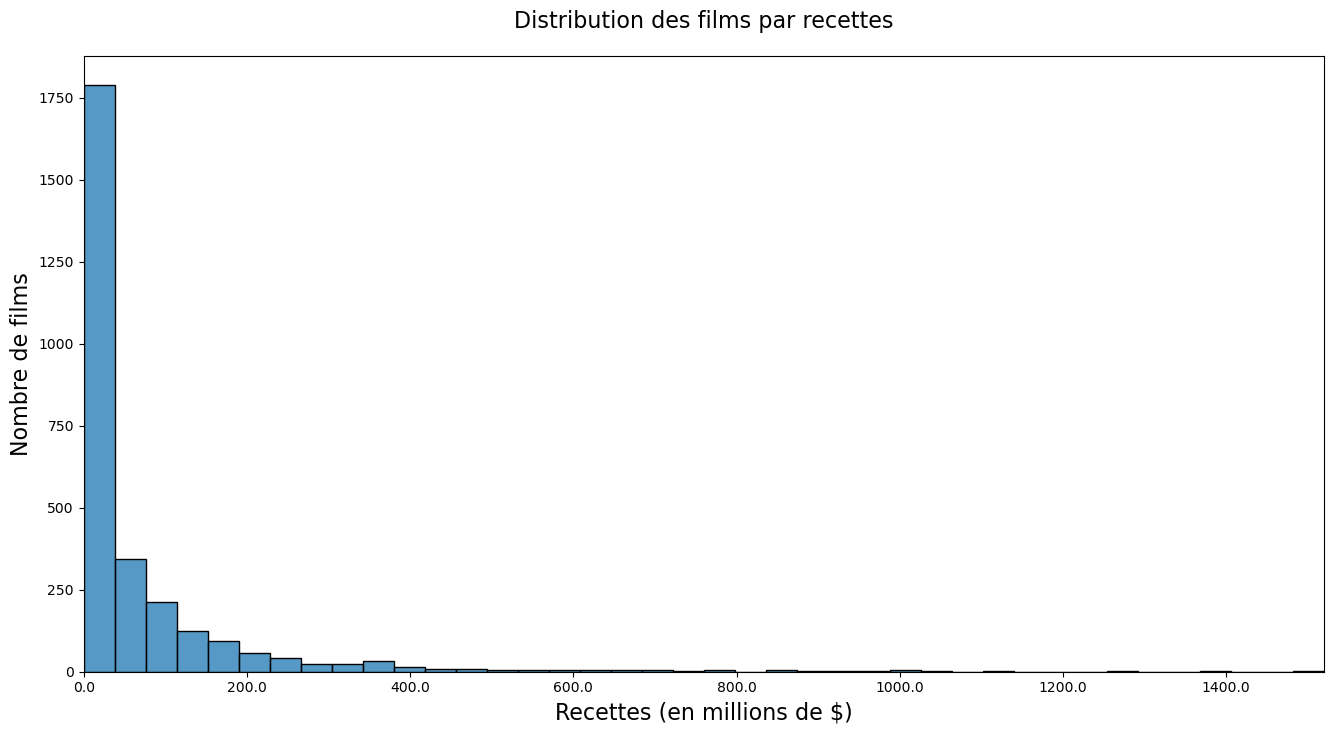

In [37]:
plt.figure(figsize=(16,8))
plot = sns.histplot(x="revenue", data=movies_train,bins=40)
plot.bar_label(plot.containers[0], fmt='%.0f', padding=5)
plt.xlabel("Recettes (en millions de $)", fontsize=16)
plt.xticks(plot.get_xticks(),plot.get_xticks() * 0.000001) # afficher l'unité plutôt que 1e8
plt.xlim(0,max(movies_train.revenue))
plt.ylabel("Nombre de films", fontsize=16)
plt.title("Distribution des films par recettes", fontsize=16, pad=20)
plt.show()


In [38]:
max_revenue = max(movies_train.revenue)
min_revenue = min(movies_train.revenue)
print(f"Le plus petit revenu des films est égal à {min_revenue:,.2f}$ et le plus gros à {max_revenue:,.2f}$.")

Le plus petit revenu des films est égal à 1.00$ et le plus gros à 1,519,557,910.00$.


In [39]:
mean_revenue = int(np.mean(movies_train.revenue))
print (f"La recette moyenne s'élève à {mean_revenue:,.2f}$")

La recette moyenne s'élève à 68,986,491.00$


In [40]:
median_revenue = int(np.median(movies_train.revenue))
print (f"La recette médiane s'élève à {median_revenue:,.2f}$")

La recette médiane s'élève à 18,683,916.00$


Après analyse des données de recettes inférieurs à 10 000 dollars (source https://www.boxofficemojo.com/):
- pour tous les petits budgets (<1000 dollars), on ne sait pas si c'est une erreur ou pas : parfois il faut convertir en milliers, en millions, ou encore c'est en devise étrangère. Le "revenue" étant la variable à prédire, on ne va pas chercher à imputer ces valeurs mais les supprimer.<br>
- Pour les recettes inférieurs à 10000 dollars, sur les 23 films concernés, 5 films ont des données incorrectes. Comme ils sont identifiés, je vais modifier les données directement dans le dataframe.<br>

🚨 **Les données "revenue" sont un peu bancales : parfois c'est le B-O local, parfois le B-O worldwide qui est pris en compte. Comme ce n'est pas possible à indentifier, on considère que les données sont cohérentes, mais ce n'est pas le cas.**

In [41]:
print(movies_train[movies_train.revenue<10000].count()["revenue"], "films ont un budget inférieur à 10,000.00$")
print(movies_train[movies_train.revenue<1000].count()["revenue"], "films ont un budget inférieur à 1,000.00$")
print(movies_train[(movies_train.revenue>=1000) & (movies_train.revenue<=10000)]["revenue"].count(), "films ont un budget supérieur à 1,00.00$ et inférieur à 10,000.00$")

75 films ont un budget inférieur à 10,000.00$
45 films ont un budget inférieur à 1,000.00$
30 films ont un budget supérieur à 1,00.00$ et inférieur à 10,000.00$


Suppression films (recettes < 1000)

In [42]:
movies_train.drop(index=movies_train[movies_train.revenue<1000].index, inplace=True)

Les index de films à corriger : 
* 797 (Ashby) => 122 919
* 1690 (The Dead Lands, recettes locales) => 906 158
* 2810 (Every Thing Will Be Fine,recettes locales) => 473 965
    

In [43]:
movies_train.loc[[797,1690,2810],"revenue"]

797     4631
1690    5240
2810    8034
Name: revenue, dtype: int64

In [44]:
#movies_train[movies_train.id.isin([798,1691,2811])].replace
movies_train.loc[797,"revenue"] = 122919
movies_train.loc[1690,"revenue"] = 906158
movies_train.loc[2810,"revenue"] = 473965 

Vérification

In [45]:
movies_train.loc[[797,1690,2810]]

belongs_to_collection  budget  \
797                    NaN       0   
1690                   NaN       0   
2810                   NaN       0   

                                                                                             genres  \
797   [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]   
1690                                                                 [{'id': 28, 'name': 'Action'}]   
2810                                                                  [{'id': 18, 'name': 'Drama'}]   

     original_language  popularity  \
797                 en    5.159349   
1690                en   10.001517   
2810                en    5.723103   

                                                                                     production_companies  \
797   [{'name': 'Head Gear Films', 'id': 5056}, {'name': 'Metrol Technology', 'id': 25954}, {'name': '...   
1690                                                  [{'name': 'General Film Corporation', 'id': 13742}]   
2810  [{'name': 'Neue Road Movies', 'id': 4503}, {'name': 'Film i Väst', 'id': 17513}, {'name': 'Monta...   

                                                                                     production_countries  \
797                                            [{'iso_3166_1': 'US', 'name': 'United States of America'}]   
1690                                                        [{'iso_3166_1': 'NZ', 'name': 'New Zealand'}]   
2810  [{'iso_3166_1': 'SE', 'name': 'Sweden'}, {'iso_3166_1': 'DE', 'name': 'Germany'}, {'iso_3166_1':...   

     release_date  runtime    status  \
797       4/19/15    102.0  Released   
1690       9/4/14    108.0  Released   
2810       4/2/15    118.0  Released   

                                                                    tagline  \
797                                Life is about knowing how to take a hit.   
1690                                                                    NaN   
2810  A moment. A tragic accident. And nothing will ever be the same again.   

                         title  \
797                      Ashby   
1690            The Dead Lands   
2810  Every Thing Will Be Fine   

                                                                                                     cast  \
797   [{'cast_id': 2, 'character': 'Ashby Holt', 'credit_id': '5500cb37c3a3685b96001ec8', 'gender': 2,...   
1690  [{'cast_id': 2, 'character': 'Hongi', 'credit_id': '53cf92f3c3a36877640073d3', 'gender': 0, 'id'...   
2810  [{'cast_id': 1, 'character': 'Tomas Eldan', 'credit_id': '52fe4f10c3a36847f82bacc5', 'gender': 2...   

                                                                                                     crew  \
797   [{'credit_id': '5500cb1c925141275c001820', 'department': 'Directing', 'gender': 0, 'id': 77723, ...   
1690  [{'credit_id': '53cf9579c3a368776d00734c', 'department': 'Crew', 'gender': 2, 'id': 15290, 'job'...   
2810  [{'credit_id': '52fe4f10c3a36847f82bacd7', 'department': 'Directing', 'gender': 2, 'id': 2303, '...   

      revenue  
797    122919  
1690   906158  
2810   473965

In [46]:
movies_train.revenue.describe()

count    2.783000e+03
mean     7.010251e+07
std      1.385834e+08
min      1.404000e+03
25%      3.569540e+06
50%      1.947811e+07
75%      7.599653e+07
max      1.519558e+09
Name: revenue, dtype: float64

### belongs_to_collection

Je transforme les données de 'belongs_to_collection' en booléen via un  :<br>
- 1 (appartient à une collection) 
- 0 (n'appartient pas à une collection)

Appel de la fonction "encode_and_rename"

In [47]:
encode_and_rename(movies_test)
encode_and_rename(movies_train)

### budget

Les valeurs équivalent à null pour un entier, 0, n'ont pas été détectées par le isnull().<br>
Je vais regarder si on a des valeurs basses et valant 0.

In [48]:
movies_train.budget.describe()

count    2.783000e+03
mean     2.370927e+07
std      3.738656e+07
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+07
75%      3.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

In [49]:
movies_test.budget.describe()

count    4.115000e+03
mean     2.378046e+07
std      3.739868e+07
min      0.000000e+00
25%      0.000000e+00
50%      9.100000e+06
75%      3.000000e+07
max      2.600000e+08
Name: budget, dtype: float64

In [50]:
print ("Il y a",movies_train[movies_train.budget==0].count()["budget"], "films du jeu de données d'entraînement qui ont un budget égal à 0,")
print ("et",movies_test[movies_test.budget==0].count()["budget"], "films du jeu de données de test qui ont un budget égal à 0.")

Il y a 702 films du jeu de données d'entraînement qui ont un budget égal à 0,
et 1054 films du jeu de données de test qui ont un budget égal à 0.


Après analyse des données budget, pour tous les petits budgets, on ne sait pas si c'est une erreur ou pas. On peut juste estimer que pour les extrêmements petit budget, il s'agit d'une erreur.<br>
J'ai pu trouver que 'Quiet City' avait un 'vrai' budget de 2500 dollars. On peut quand même considérer qu'un budget < à 10 000 dollars sera écarté de l'analyse.<br>
Ja calcule le budget moyen des films en enlevant les films dont le budget est inférieur à ce budget arbitraire.

In [51]:
print(movies_train[movies_train.budget<10000].count()["budget"], "films ont un budget inférieur à 10,000.00$")

710 films ont un budget inférieur à 10,000.00$


In [52]:
temp_df = movies_train[movies_train.budget>10000]
mean_budget = int(np.mean(temp_df.budget))
med_budget = int(np.median(temp_df.budget))
print (f"Le budget moyen du jeu d'entraînement (hors film dont le budget est inférieuer à 10,000.00$) vaut {mean_budget:,.2f}$ et le budget médian {med_budget:,.2f}$.")

Le budget moyen du jeu d'entraînement (hors film dont le budget est inférieuer à 10,000.00$) vaut 31,829,661.00$ et le budget médian 18,000,000.00$.


In [53]:
temp_df_test = movies_test[movies_test.budget>10000]
mean_budget_test = int(np.mean(temp_df_test.budget))
med_budget_test = int(np.median(temp_df_test.budget))
print (f"Le budget moyen du jeu de test (hors film dont le budget est inférieuer à 10,000.00$) vaut {mean_budget_test:,.2f}$ et le budget médian {med_budget_test:,.2f}$.")

Le budget moyen du jeu de test (hors film dont le budget est inférieuer à 10,000.00$) vaut 32,263,949.00$ et le budget médian 18,000,000.00$.


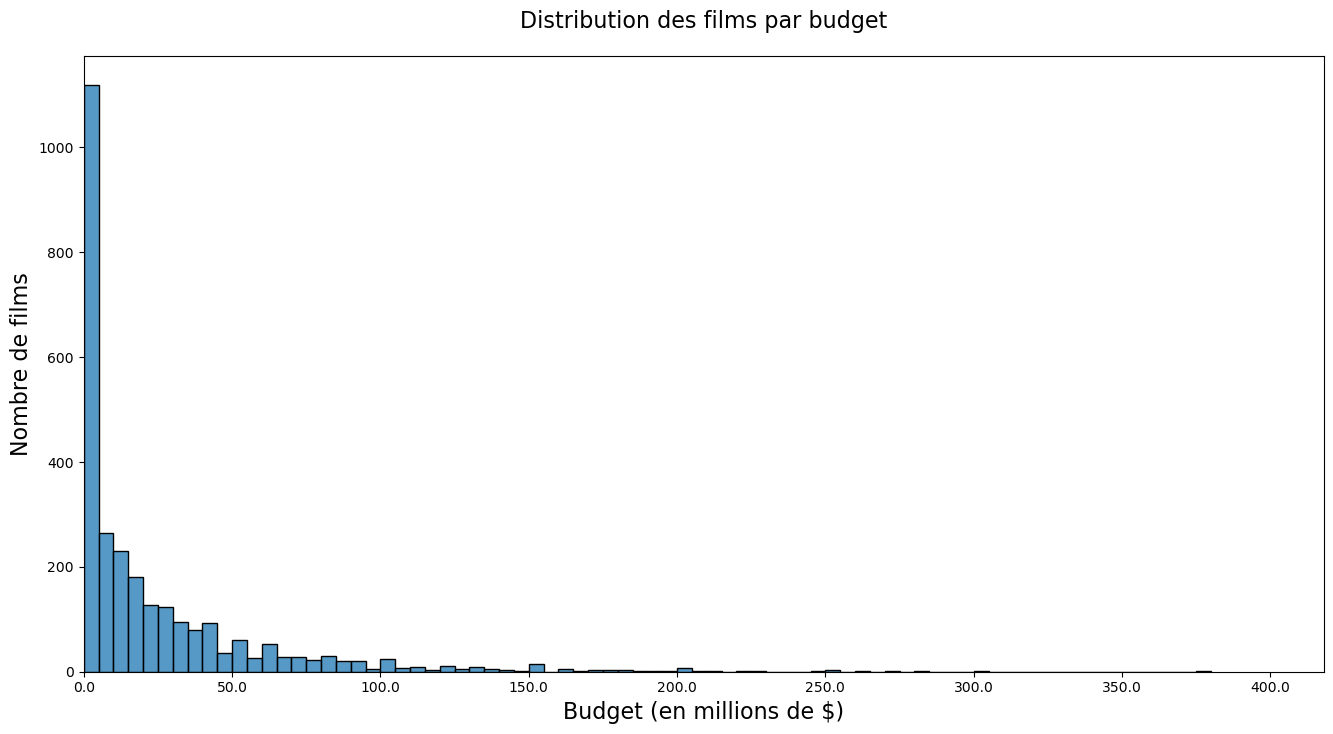

In [54]:
plt.figure(figsize=(16,8))
bins = int(max(movies_train.budget)/10000000)*2
plot = sns.histplot(x="budget", data=movies_train,bins=bins)

plt.xlabel("Budget (en millions de $)", fontsize=16)
plt.xticks(plot.get_xticks(),plot.get_xticks() * 0.000001) # afficher l'unité plutôt que 1e8
plt.xlim(0,max(movies_train.budget)+max(movies_train.budget)*0.1)
plt.ylabel("Nombre de films", fontsize=16)
plt.title("Distribution des films par budget", fontsize=16, pad=20)
plt.show()


J'impute la médiane (non sensibles aux outliers, même si les valeurs moyenne et médiane sont proches) de budget à tous les films dont le budget est inférieur à 10 000$.<br>
Je récupère les index des films concernés pour faire mon imputation.

In [55]:
index_low_budget=movies_train[movies_train.budget<10000].index
for i in index_low_budget:
    movies_train.loc[i, "budget"] = movies_train.budget.loc[i]+med_budget

In [56]:
index_low_budget_test=movies_test[movies_test.budget<10000].index
for i in index_low_budget_test:
    movies_test.loc[i, "budget"] = movies_test.budget.loc[i]+med_budget_test

Vérification de l'imputation

In [57]:
movies_train.loc[[365,2996],:]

is_collection    budget  \
365               0  18007000   
2996              0  18000000   

                                                                                                   genres  \
365   [{'id': 878, 'name': 'Science Fiction'}, {'id': 18, 'name': 'Drama'}, {'id': 53, 'name': 'Thrill...   
2996                                        [{'id': 18, 'name': 'Drama'}, {'id': 10402, 'name': 'Music'}]   

     original_language  popularity  \
365                 en    7.153070   
2996                sv    3.727996   

                                                            production_companies  \
365                                           [{'name': 'Thinkfilm', 'id': 446}]   
2996  [{'name': 'Memfis Film', 'id': 321}, {'name': 'Film i Väst', 'id': 17513}]   

                                                                   production_countries  \
365                          [{'iso_3166_1': 'US', 'name': 'United States of America'}]   
2996  [{'iso_3166_1': 'DK', 'name': 'Denmark'}, {'iso_3166_1': 'SE', 'name': 'Sweden'}]   

     release_date  runtime    status                             tagline  \
365       10/8/04     77.0  Released  What happens if it actually works?   
2996      3/28/13    102.0  Released                                 NaN   

                 title  \
365             Primer   
2996  We Are the Best!   

                                                                                                     cast  \
365   [{'cast_id': 1, 'character': 'Aaron', 'credit_id': '52fe45e79251416c75066787', 'gender': 2, 'id'...   
2996  [{'cast_id': 5, 'character': 'Bobo', 'credit_id': '52fe4c7f9251416c910f6c4d', 'gender': 0, 'id':...   

                                                                                                     crew  \
365   [{'credit_id': '52fe45e79251416c75066791', 'department': 'Directing', 'gender': 2, 'id': 76624, ...   
2996  [{'credit_id': '5716b72ac3a3686678012c84', 'department': 'Production', 'gender': 0, 'id': 6338, ...   

      revenue  
365    424760  
2996   180590

Je regarde s'il y a beaucoup d'écart entre le budget min et le budget max.

In [58]:
max_budget = max(movies_train.budget)
min_budget = min(movies_train.budget)

print (f"""
- Le plus gros budget s'éleve à {max_budget}$
- Le plus petit budget est de {min_budget}$.
""")


- Le plus gros budget s'éleve à 380000000$
- Le plus petit budget est de 11178$.



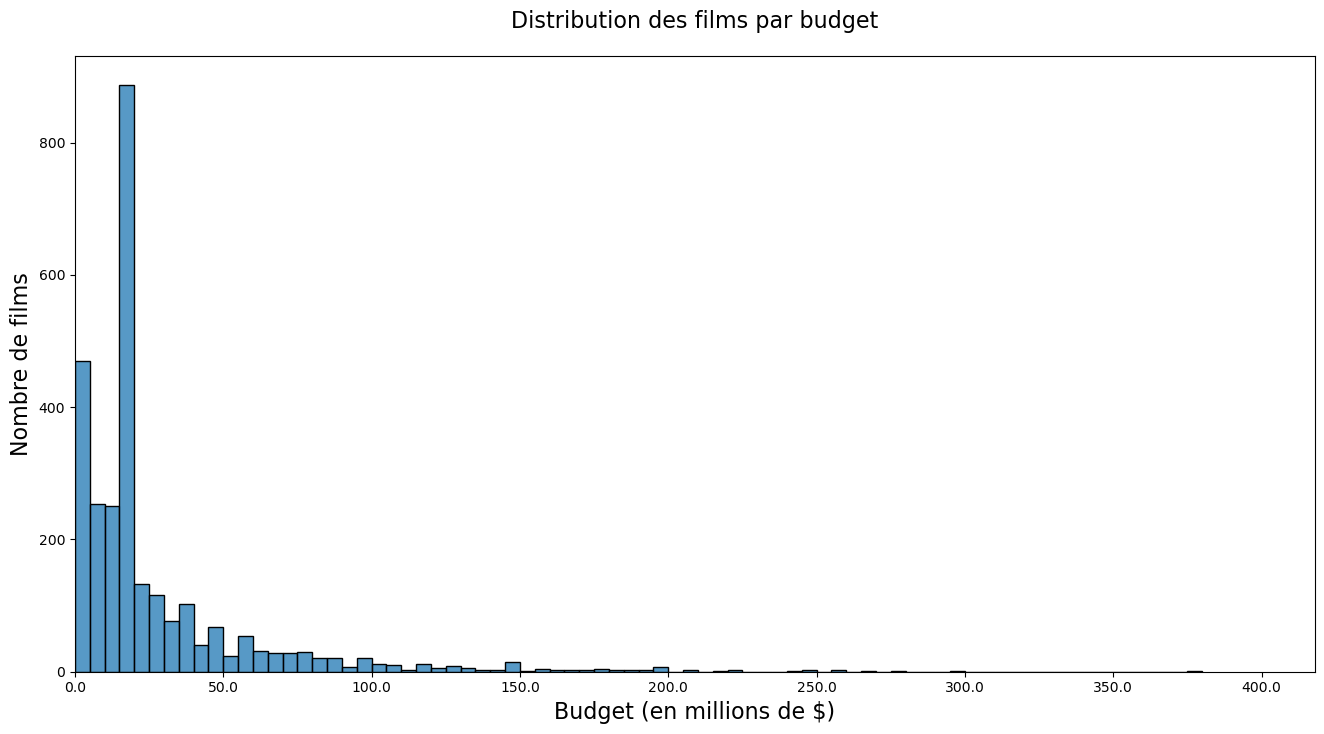

In [59]:
plt.figure(figsize=(16,8))
bins = int(max_budget/10000000)*2
plot = sns.histplot(x="budget", data=movies_train,bins=bins)

plt.xlabel("Budget (en millions de $)", fontsize=16)
plt.xticks(plot.get_xticks(),plot.get_xticks() * 0.000001) # afficher en normal plutôt que 1e8
plt.xlim(0,max_budget+max_budget*0.1) 
plt.ylabel("Nombre de films", fontsize=16)
plt.title("Distribution des films par budget", fontsize=16, pad=20)
plt.show()

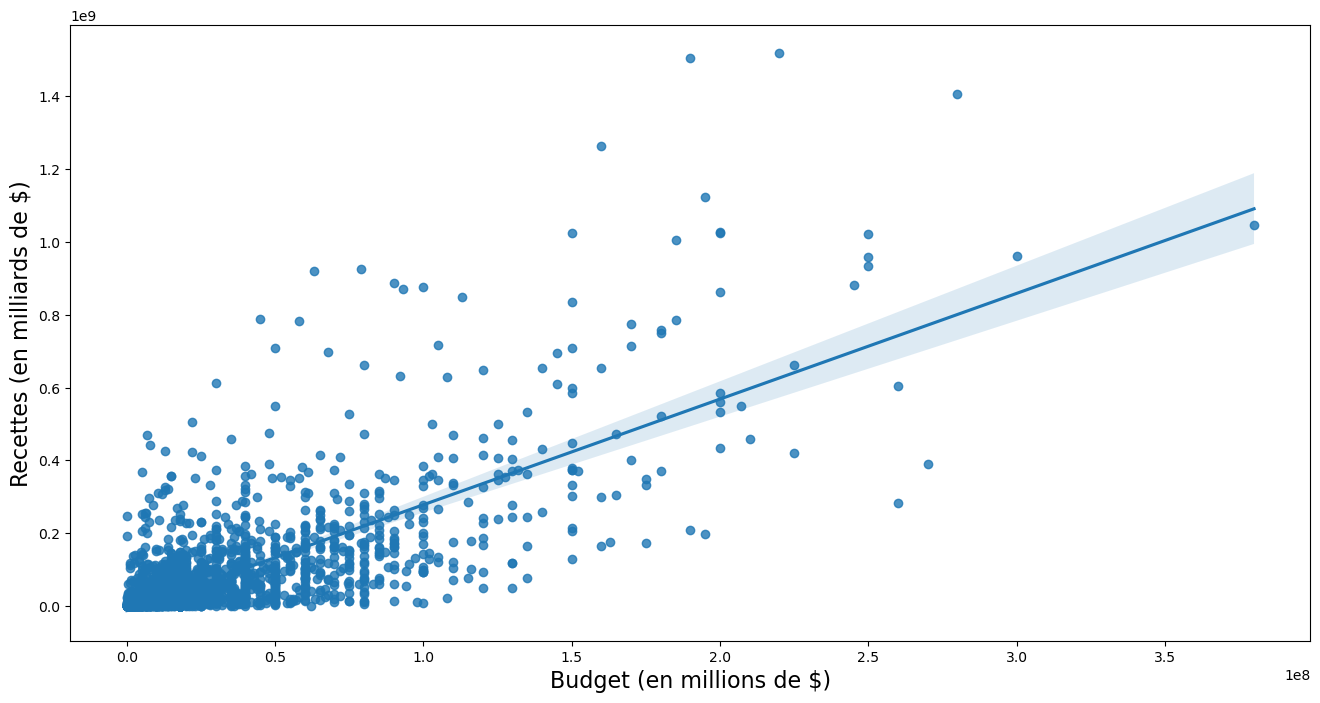

In [60]:
plt.figure(figsize=(16,8))
sns.regplot(x="budget", y="revenue", data=movies_train)
#plt.xticks(plot.get_xticks(),plot.get_xticks() * 0.000001) # afficher en millions plutôt que 1e8
plt.xlabel("Budget (en millions de $)", fontsize=16)
plt.ylabel("Recettes (en milliards de $)", fontsize=16)
plt.show()

Comme il y a une grande disparité entre le budget min et le budget max, j'ajoute  une colonne budget_log qui tranforme le budget en logartihme du budget.

In [61]:
movies_train["budget_log"] = np.log(movies_train.budget)

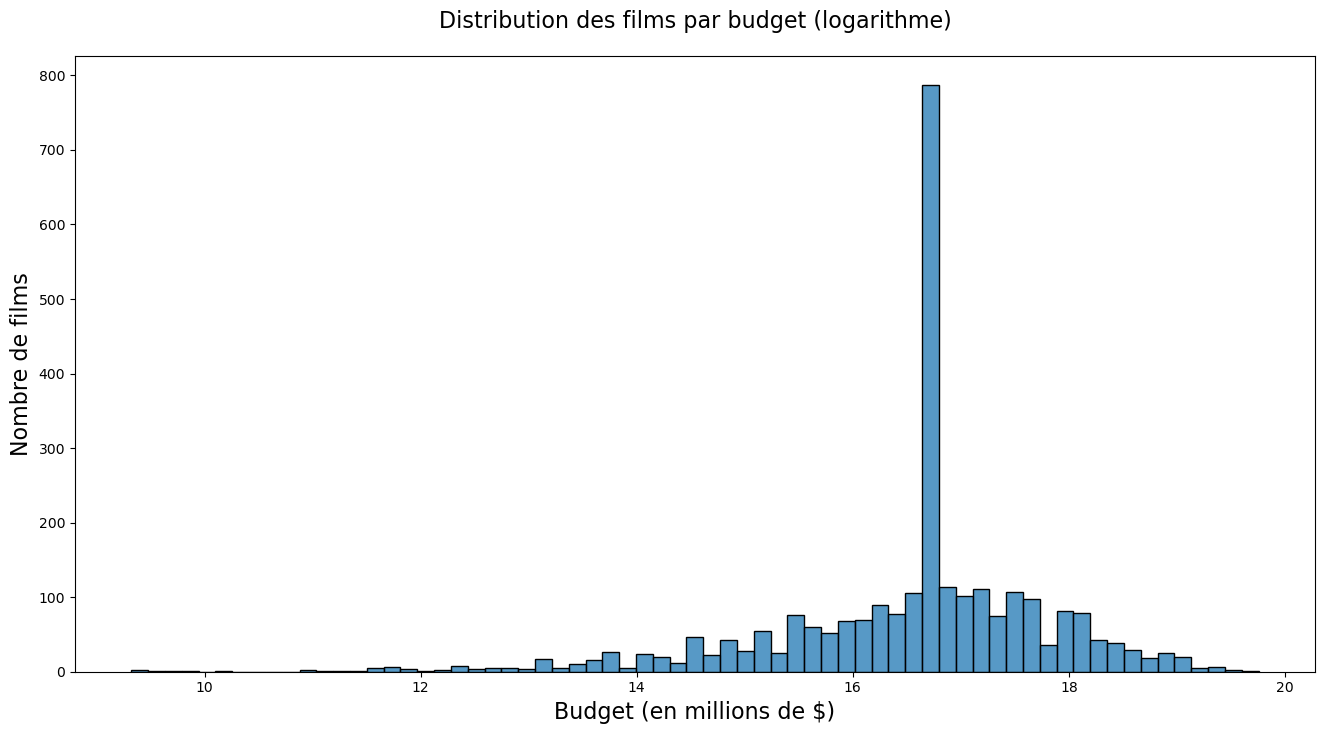

In [62]:
plt.figure(figsize=(16,8))
plot = sns.histplot(x="budget_log", data=movies_train,bins='auto')
plt.xlabel("Budget (en millions de $)", fontsize=16)
plt.ylabel("Nombre de films", fontsize=16)
plt.title("Distribution des films par budget (logarithme)", fontsize=16, pad=20)
plt.show()

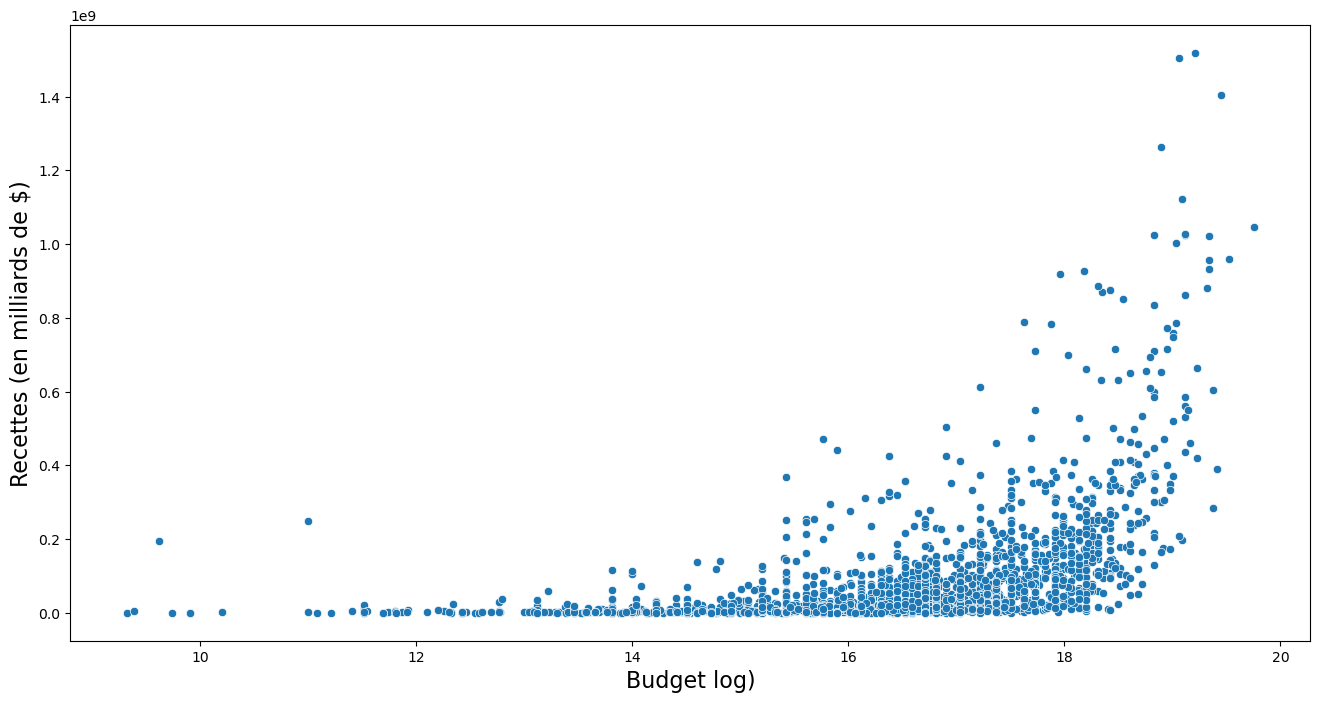

In [63]:
plt.figure(figsize=(16,8))
sns.scatterplot(x="budget_log", y="revenue", data=movies_train)
plt.xlabel("Budget log)", fontsize=16)
plt.ylabel("Recettes (en milliards de $)", fontsize=16)
plt.show()

**Observation**<br>
On note un lien entre le budget et le BO.

Je peux supprimer la colonne "budget_log" qui m'a servi à représenter le budget graphiquement pour savoir si oui ou non on gardait la donnée.

In [64]:
movies_train.drop(columns="budget_log", inplace=True)

### genres

Nous sommes encore face à un dictionnaire un peu bancal (pas un json, mais un peu).<br>
On va récupérer tous les genres pour créer une colonne par genre, et créer un nouvelle colonne contenant le nombre de genre différent pour chaque film.

In [65]:
movies_train.head(5)

is_collection    budget  \
0              1  14000000   
1              1  40000000   
2              0   3300000   
6              0  14000000   
8              1  18000000   

                                                                                                genres  \
0                                                                       [{'id': 35, 'name': 'Comedy'}]   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'i...   
2                                                                        [{'id': 18, 'name': 'Drama'}]   
6                                       [{'id': 27, 'name': 'Horror'}, {'id': 53, 'name': 'Thriller'}]   
8  [{'id': 28, 'name': 'Action'}, {'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}, {'i...   

  original_language  popularity  \
0                en    6.575393   
1                en    8.248895   
2                en   64.299990   
6                en    7.286477   
8                en    6.902423   

                                                                                  production_companies  \
0  [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-...   
1                                                          [{'name': 'Walt Disney Pictures', 'id': 2}]   
2  [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Ri...   
6        [{'name': 'Ghost House Pictures', 'id': 768}, {'name': 'North Box Productions', 'id': 22637}]   
8  [{'name': 'Walt Disney Pictures', 'id': 2}, {'name': 'Jim Henson Productions', 'id': 2504}, {'na...   

                                                                                 production_countries  \
0                                          [{'iso_3166_1': 'US', 'name': 'United States of America'}]   
1                                          [{'iso_3166_1': 'US', 'name': 'United States of America'}]   
2                                          [{'iso_3166_1': 'US', 'name': 'United States of America'}]   
6  [{'iso_3166_1': 'US', 'name': 'United States of America'}, {'iso_3166_1': 'CA', 'name': 'Canada'}]   
8                                          [{'iso_3166_1': 'US', 'name': 'United States of America'}]   

  release_date  runtime    status  \
0      2/20/15     93.0  Released   
1       8/6/04    113.0  Released   
2     10/10/14    105.0  Released   
6      8/30/12     92.0  Released   
8      2/16/96    100.0  Released   

                                                        tagline  \
0          The Laws of Space and Time are About to be Violated.   
1  It can take a lifetime to find true love; she's got 30 days!   
2               The road to greatness can take you to the edge.   
6                          Fear The Demon That Doesn't Fear God   
8                                   Set sail for Muppet mayhem!   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
6                            The Possession   
8                    Muppet Treasure Island   

                                                                                                  cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': ...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis', 'credit_id': '52fe43fe9251416c7502561f', 'gender...   
2  [{'cast_id': 5, 'character': 'Andrew Neimann', 'credit_id': '52fe4ef7c3a36847f82b3fc3', 'gender'...   
6  [{'cast_id': 23, 'character': 'Clyde', 'credit_id': '52fe4981c3a368484e12ee17', 'gender': 2, 'id...   
8  [{'cast_id': 1, 'character': 'Long John Silver', 'credit_id': '52fe43c89251416c7501dea1', 'gende...   

                                                                                                  crew  \
0  [{'credit_id': '59ac067c92514107af02c8c8', 'departm

J'appelle la fonction qui crée d'abord autant de colonne Genre qu'il y a de genre, puis qui remplit avec 1 si le genre est présent.<br>
Je procède à l'équivalent du *OneHotEncoder* de scikitlearn que je n'ai pas pu utiliser du fait du format des données. Chaque genre est représenté de façon binaire dans une colonne qui lui est propre => on aura autant de colonnes que de genre. 
J'aurais pu aussi utiliser, après avoir récupéré dans une liste tous les genres pour un film, le *OrdinalEncoder* (et pas le *LabelEncoder* qui ne fonctionne que sur une donnée).

In [66]:
movies_train['count_genres']=''
fill_genres_columns(movies_train)

In [67]:
movies_test['count_genres']=''
fill_genres_columns(movies_test)

Je supprime la colonne 'genres'

In [68]:
movies_train.drop(columns='genres', inplace=True)
movies_test.drop(columns='genres', inplace=True)

Je remplace, dans toutes les colonnes de forme "genre_" que je viens de créer, les vides par "0".

In [69]:
movies_train.loc[:,movies_train.columns.str.contains('genre_')]=movies_train.loc[:,movies_train.columns.str.contains('genre_')].apply(lambda x : x.replace('',0))
movies_test.loc[:,movies_test.columns.str.contains('genre_')]=movies_test.loc[:,movies_test.columns.str.contains('genre_')].apply(lambda x : x.replace('',0))

Vérification sur le jeu d'entraînement

In [70]:
movies_train.loc[1,movies_train.columns.str.contains('genre_')]

genre_Comedy             1
genre_Drama              1
genre_Family             1
genre_Romance            1
genre_Horror             0
genre_Thriller           0
genre_Action             0
genre_Music              0
genre_Adventure          0
genre_Crime              0
genre_Science Fiction    0
genre_Mystery            0
genre_Foreign            0
genre_Animation          0
genre_Fantasy            0
genre_War                0
genre_Western            0
genre_Documentary        0
genre_History            0
genre_TV Movie           0
Name: 1, dtype: object

In [71]:
movies_train[movies_train.genre_Comedy == 1]["revenue"].aggregate('sum')

61688930690

Je récupère la liste de mes colonnes de type "genre_"

In [72]:
col_list = movies_train.columns
genres_list=[]
for col_name in col_list:
    if 'genre_' in col_name :
        genres_list.append(col_name)

J'itère sur toutes les colonnes "genre_" et je récupère la somme des revenues par genre et le total de films.

In [73]:
info_genre_list=[]
for genre in genres_list:
    info_genre_list.append({"Genre":genre,
                  "Revenue":movies_train[movies_train[genre] == 1]["revenue"].aggregate('sum'),
                         "Total":movies_train[movies_train[genre] == 1]["title"].aggregate('count')
                 })
info_genre_df=pd.DataFrame(info_genre_list)
info_genre_df.Genre= info_genre_df['Genre'].str.split('_').str[1]
info_genre_df=info_genre_df.sort_values(by="Revenue", ascending=False)
info_genre_df

Genre      Revenue  Total
6            Action  78597301563    701
8         Adventure  75622559043    423
1             Drama  66647935451   1421
0            Comedy  61688930690    956
5          Thriller  51888645890    747
2            Family  35992511754    244
10  Science Fiction  34133183016    279
14          Fantasy  33452360214    222
3           Romance  29550972550    531
9             Crime  26148316352    446
13        Animation  20777329573    135
4            Horror  15846797874    292
11          Mystery  13339438310    221
18          History   5047428151    124
15              War   4991560984     98
7             Music   3838020066     92
16          Western   2208730486     40
17      Documentary    371360196     56
12          Foreign     50679396     17
19         TV Movie     42000000      1

Je regarde la distribution genre/revenue

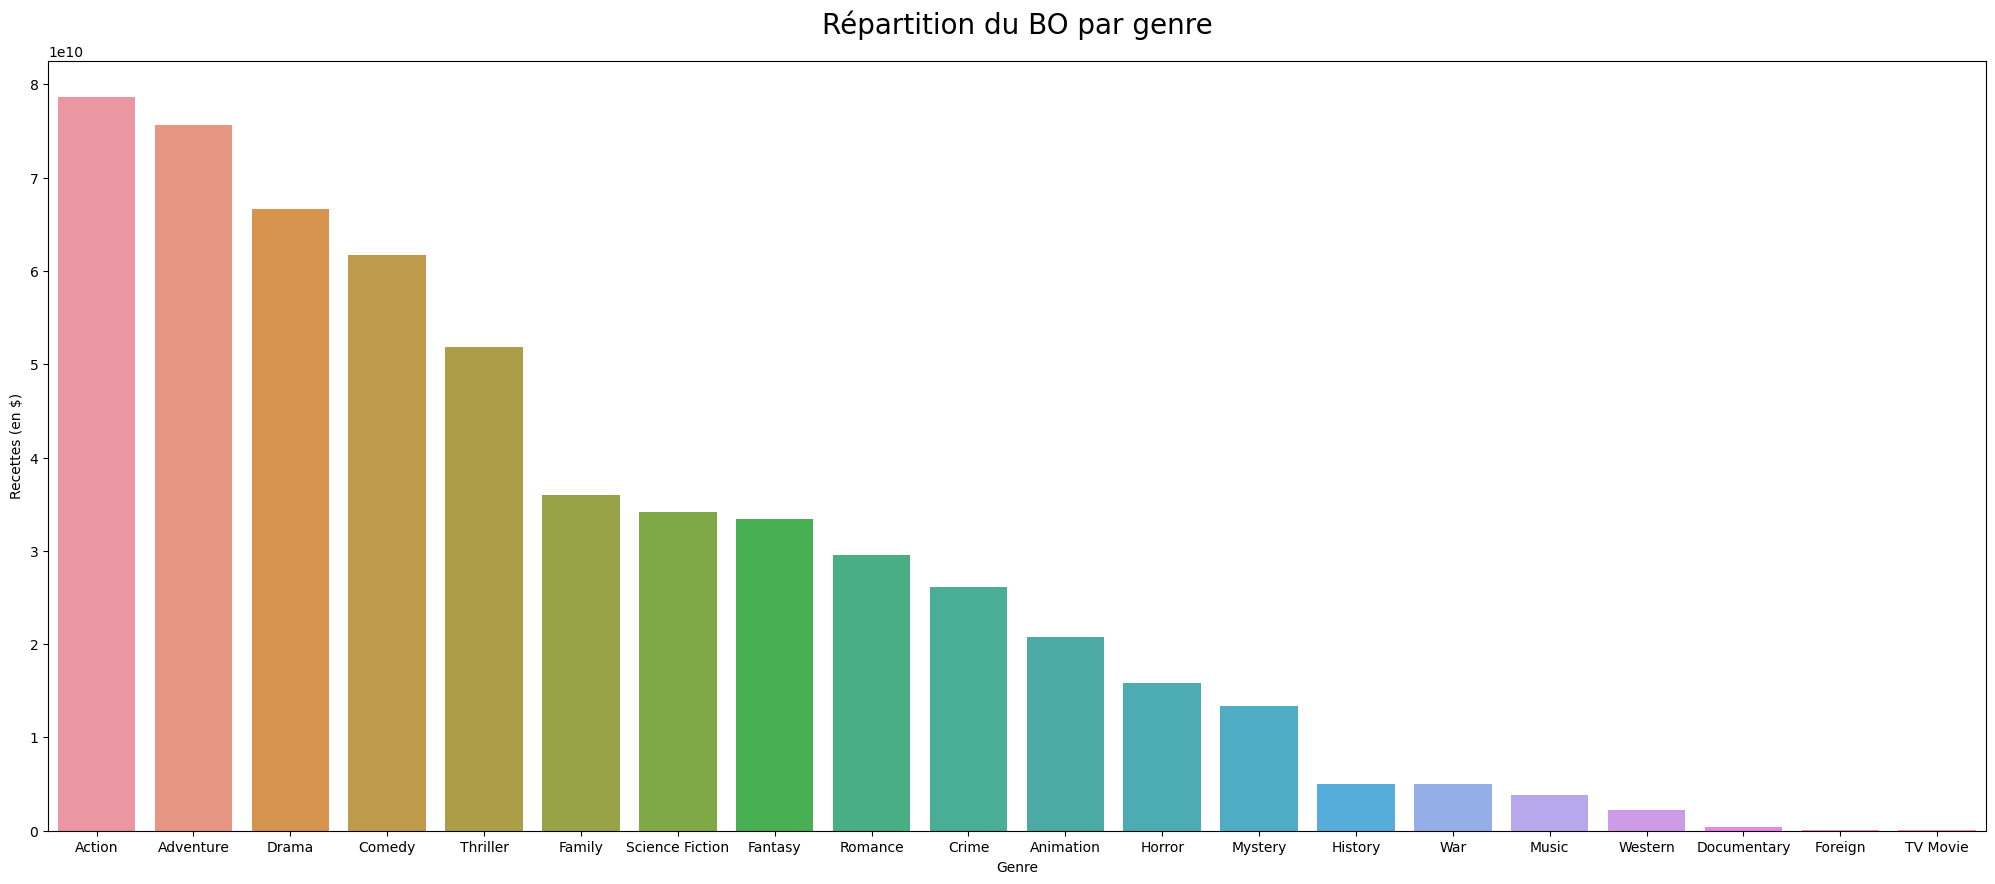

In [74]:
plt.figure(figsize=(25,10))
sns.barplot(x="Genre", y="Revenue", data=info_genre_df, estimator=sum)
plt.ylabel("Recettes (en $)")
plt.title("Répartition du BO par genre", pad = 20, size = 20)
plt.show()

**Observation**<br>
Les films dont au moins un des genres est Action ou Aventure font le plus d'entrées au BO.<br>
Cette variable est intéressante à conserver.

### original_language

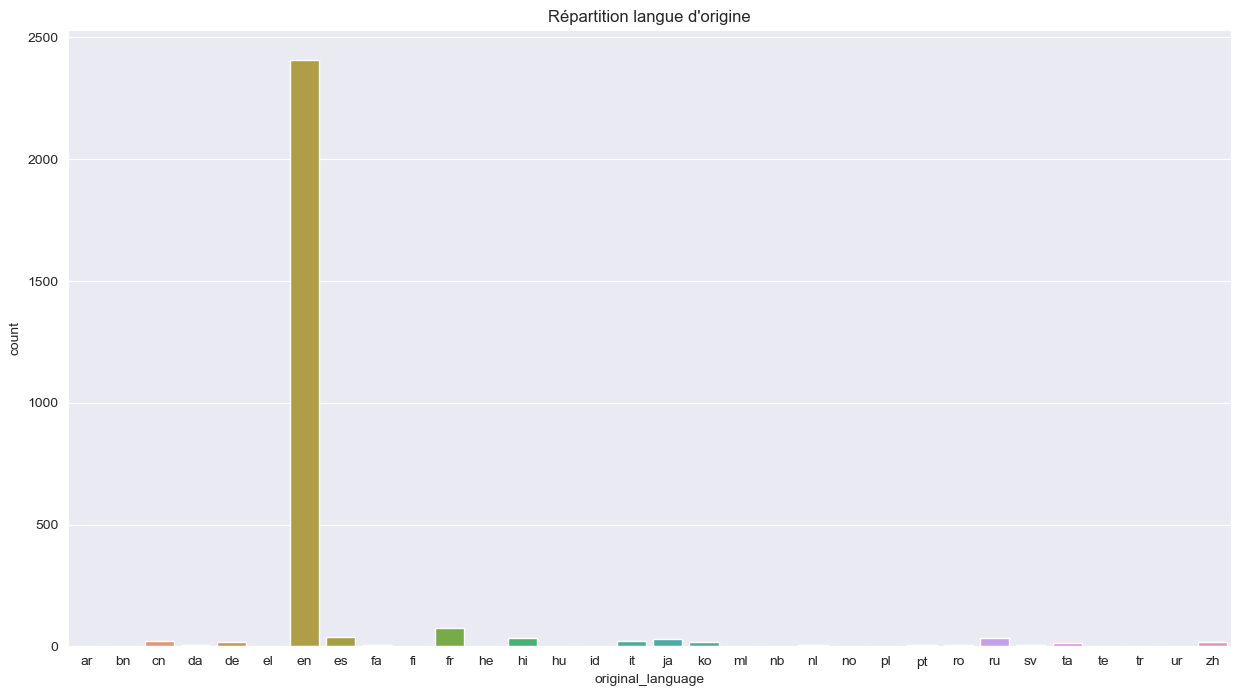

In [75]:
sns.set({'figure.figsize':(15,8)})
sns.countplot(x='original_language', data=movies_train.sort_values(by="original_language"))
plt.title("Répartition langue d'origine")
plt.show()


**Observation**<br>
La majorité des films étant en langue anglaise, on peut créer une variable de type booléen : 
- 1 pour un film en langue anglaise
- sinon 0

Je calcule puis représente la répartition

In [76]:
movies_en = movies_train[movies_train.original_language=="en"]["original_language"].count()
print (f"Il y a {(movies_en/movies_train.shape[0]):.2%} de films (jeu d'entraînement) en langue anglaise.")

movies_en_test = movies_test[movies_test.original_language=="en"]["original_language"].count()
print (f"Il y a {(movies_en_test/movies_test.shape[0]):.2%} de films (jeu de test) en langue anglaise.")

Il y a 86.56% de films (jeu d'entraînement) en langue anglaise.
Il y a 86.66% de films (jeu de test) en langue anglaise.


In [77]:
language_df=movies_train.groupby("original_language").agg(Total=("original_language" , 'count'))
language_df.sort_values(by="Total",ascending=False)

Total
original_language       
en                  2409
fr                    75
es                    40
ru                    36
hi                    35
ja                    32
it                    21
cn                    20
ko                    18
zh                    16
de                    16
ta                    14
sv                     7
pt                     6
da                     5
fa                     5
nl                     4
ro                     4
hu                     3
no                     2
tr                     2
ml                     2
pl                     2
ur                     1
te                     1
fi                     1
he                     1
nb                     1
bn                     1
el                     1
id                     1
ar                     1

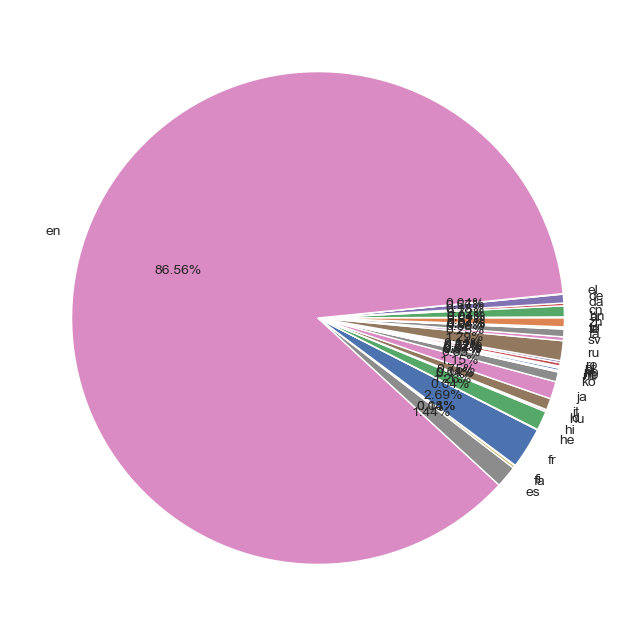

In [78]:
plt.pie(x=language_df.Total,labels=language_df.index,autopct='%.2f%%')
plt.show()


J'applique mon encodage

In [79]:
movies_train["english_language"] = np.where(movies_train.original_language == "en",1,0)
movies_train.drop(columns="original_language", inplace=True)

movies_test["english_language"] = np.where(movies_test.original_language == "en",1,0)
movies_test.drop(columns="original_language", inplace=True)

Vérification

In [80]:
movies_train.head(1)

is_collection    budget  popularity  \
0              1  14000000    6.575393   

                                                                                  production_companies  \
0  [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-...   

                                         production_countries release_date  \
0  [{'iso_3166_1': 'US', 'name': 'United States of America'}]      2/20/15   

   runtime    status                                               tagline  \
0     93.0  Released  The Laws of Space and Time are About to be Violated.   

                    title  \
0  Hot Tub Time Machine 2   

                                                                                                  cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': ...   

                                                                                                  crew  \
0  [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071...   

    revenue count_genres  genre_Comedy  genre_Drama  genre_Family  \
0  12314651            1             1            0             0   

   genre_Romance  genre_Horror  genre_Thriller  genre_Action  genre_Music  \
0              0             0               0             0            0   

   genre_Adventure  genre_Crime  genre_Science Fiction  genre_Mystery  \
0                0            0                      0              0   

   genre_Foreign  genre_Animation  genre_Fantasy  genre_War  genre_Western  \
0              0                0              0          0              0   

   genre_Documentary  genre_History  genre_TV Movie  english_language  
0                  0              0               0                 1

Je refais une représentation en camembert qui sera nettement plus claire

In [81]:
language_df=movies_train.groupby("english_language").agg(Total=("title" , 'count'))
language_df

Total
english_language       
0                   374
1                  2409

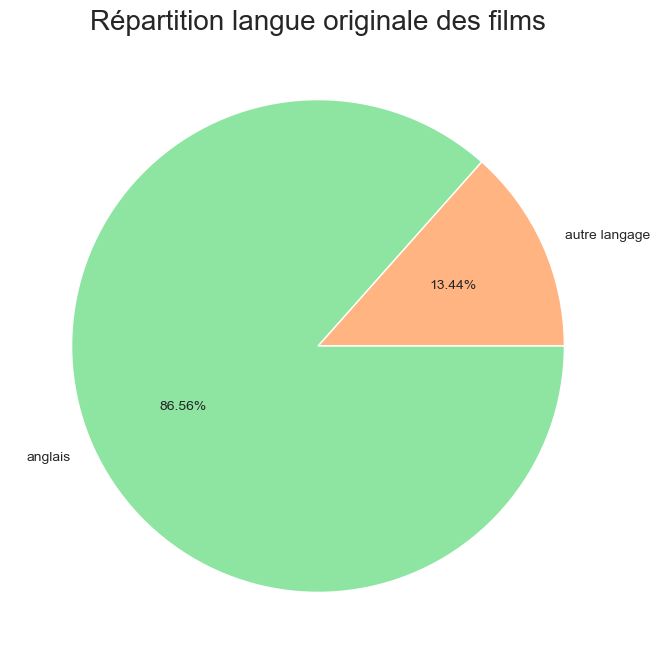

In [82]:
color=sns.color_palette('pastel')[1:3]
labels = ["autre langage","anglais"]
plt.pie(x=language_df.Total,autopct='%.2f%%', colors=color, labels=labels)
plt.title("Répartition langue originale des films", size=20)
plt.show()

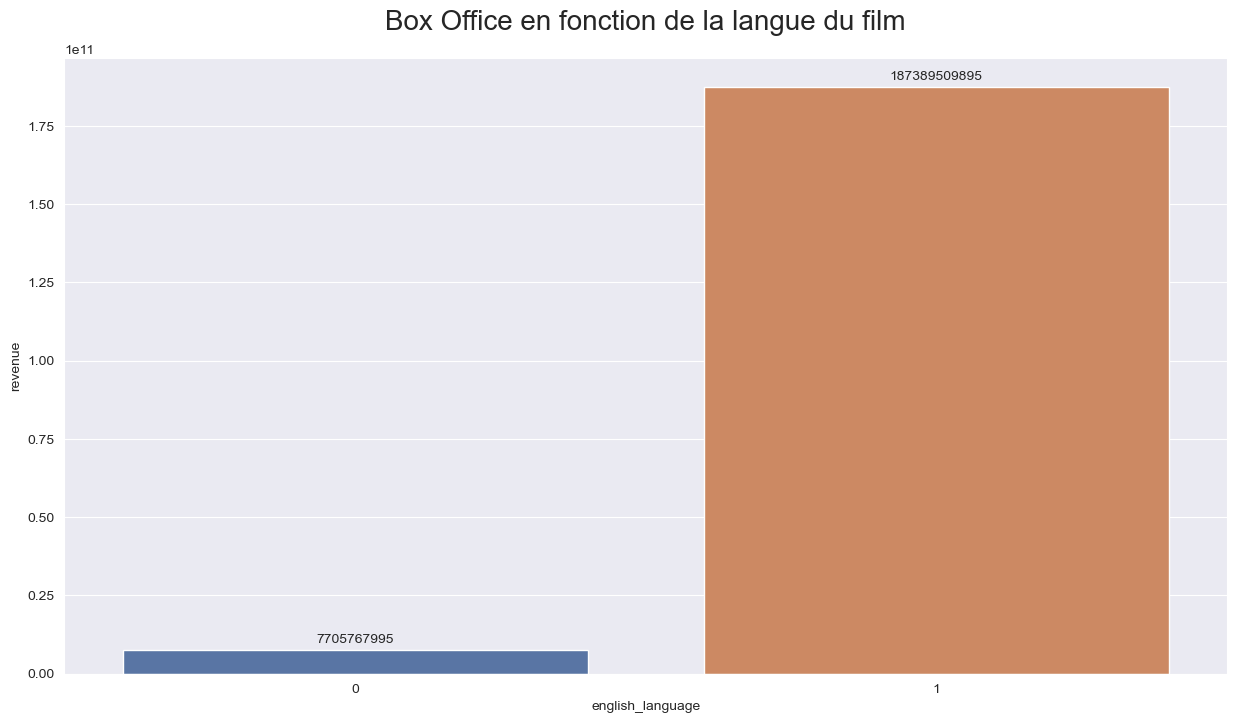

In [83]:
ax=sns.barplot(x="english_language", y="revenue", data=movies_train, estimator=sum, errorbar=None)
plt.title("Box Office en fonction de la langue du film", pad=20, size=20)
ax.bar_label(ax.containers[0], fmt='%.0f', padding=3)
plt.show()

In [84]:
revenue_language_en = movies_train[movies_train.english_language==1]["revenue"].aggregate('sum')
revenue_other_language = movies_train[movies_train.english_language==0]["revenue"].aggregate('sum')
global_revenue = movies_train.revenue.sum()

print (f"La langue a une influence sur les recettes puisque les longs métrages en langues anglaises représentent {revenue_language_en/global_revenue:.2%} de parts au BO.")
print("Mais c'est peut-être tout simplement parce que la majortié des films de la liste sont américains.")

La langue a une influence sur les recettes puisque les longs métrages en langues anglaises représentent 96.05% de parts au BO.
Mais c'est peut-être tout simplement parce que la majortié des films de la liste sont américains.


### production_companies
On comptabilise le nombre de compagnie de productions par film.<br>
On ne va pas lister les compagnies comme pour les genres, il y aurait trop de variables qui ne seraient pas forcément pertinentes même si quelques studios font toujours de très bon chiffres au B-O.

In [85]:
movies_train["count_prod_companies"]=""
count_occurence(movies_train,movies_train.production_companies,"count_prod_companies")
movies_train.drop(columns="production_companies", inplace=True)

In [86]:
movies_test["count_prod_companies"]=""
count_occurence(movies_test,movies_test.production_companies,"count_prod_companies")
movies_test.drop(columns="production_companies", inplace=True)

Vérification sur jeu d'entraînement

In [87]:
movies_train.tail(1)

is_collection    budget  popularity  \
2999              0  35000000   10.512109   

                                            production_countries release_date  \
2999  [{'iso_3166_1': 'US', 'name': 'United States of America'}]      9/22/11   

      runtime    status                                    tagline      title  \
2999    106.0  Released  They stole his life. He's taking it back.  Abduction   

                                                                                                     cast  \
2999  [{'cast_id': 2, 'character': 'Nathan Harper', 'credit_id': '52fe49a5c3a36847f81a5137', 'gender':...   

                                                                                                     crew  \
2999  [{'credit_id': '5391990d0e0a260fb5001629', 'department': 'Production', 'gender': 2, 'id': 1593, ...   

       revenue count_genres  genre_Comedy  genre_Drama  genre_Family  \
2999  82087155            3             0            0             0   

      genre_Romance  genre_Horror  genre_Thriller  genre_Action  genre_Music  \
2999              0             0               1             1            0   

      genre_Adventure  genre_Crime  genre_Science Fiction  genre_Mystery  \
2999                0            0                      0              1   

      genre_Foreign  genre_Animation  genre_Fantasy  genre_War  genre_Western  \
2999              0                0              0          0              0   

      genre_Documentary  genre_History  genre_TV Movie  english_language  \
2999                  0              0               0                 1   

     count_prod_companies  
2999                    6

Le type de données est resté 'Object'. Je convertis la colonne en entier numérique.

In [88]:
movies_train.count_prod_companies=movies_train.count_prod_companies.astype(int)
movies_test.count_prod_companies=movies_test.count_prod_companies.astype(int)
#Vérification
movies_train.count_prod_companies.dtype

dtype('int64')

On regarde la répartition du box-office en fonction du nombre de compagnies de production

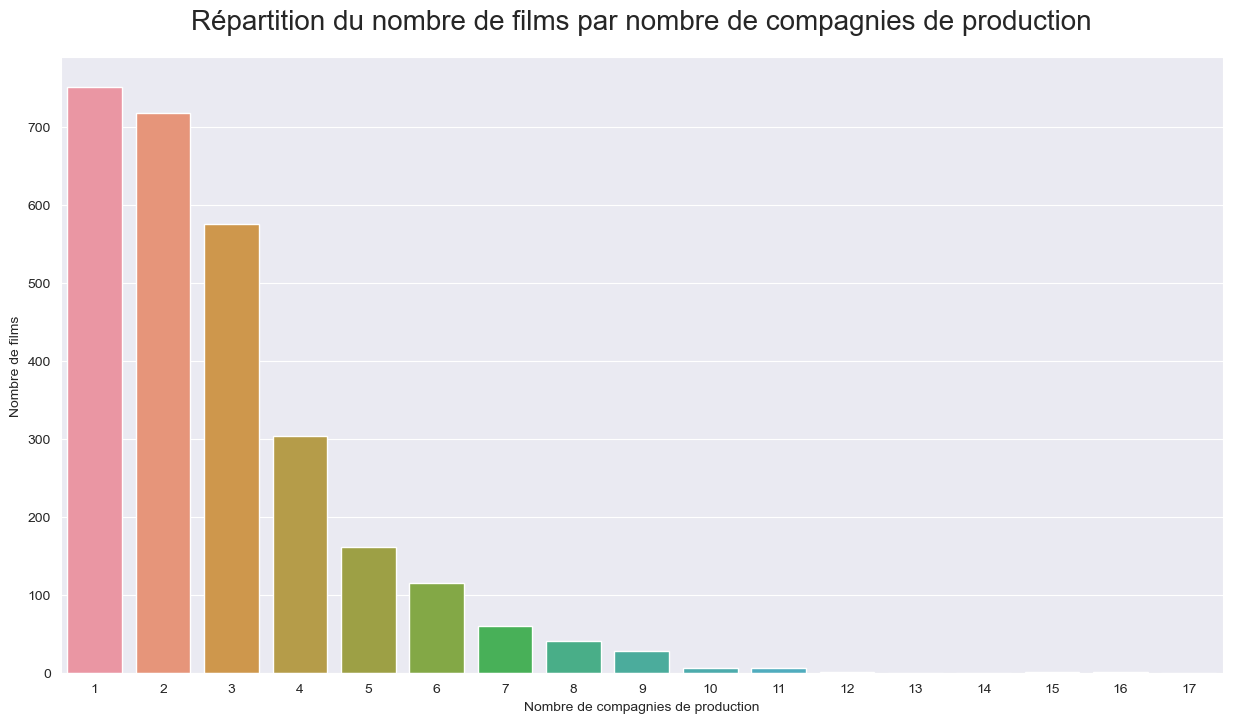

In [89]:
sns.countplot(x="count_prod_companies", data=movies_train)
plt.title("Répartition du nombre de films par nombre de compagnies de production", pad=20, size=20)
plt.xlabel("Nombre de compagnies de production")
plt.ylabel('Nombre de films')
plt.show()

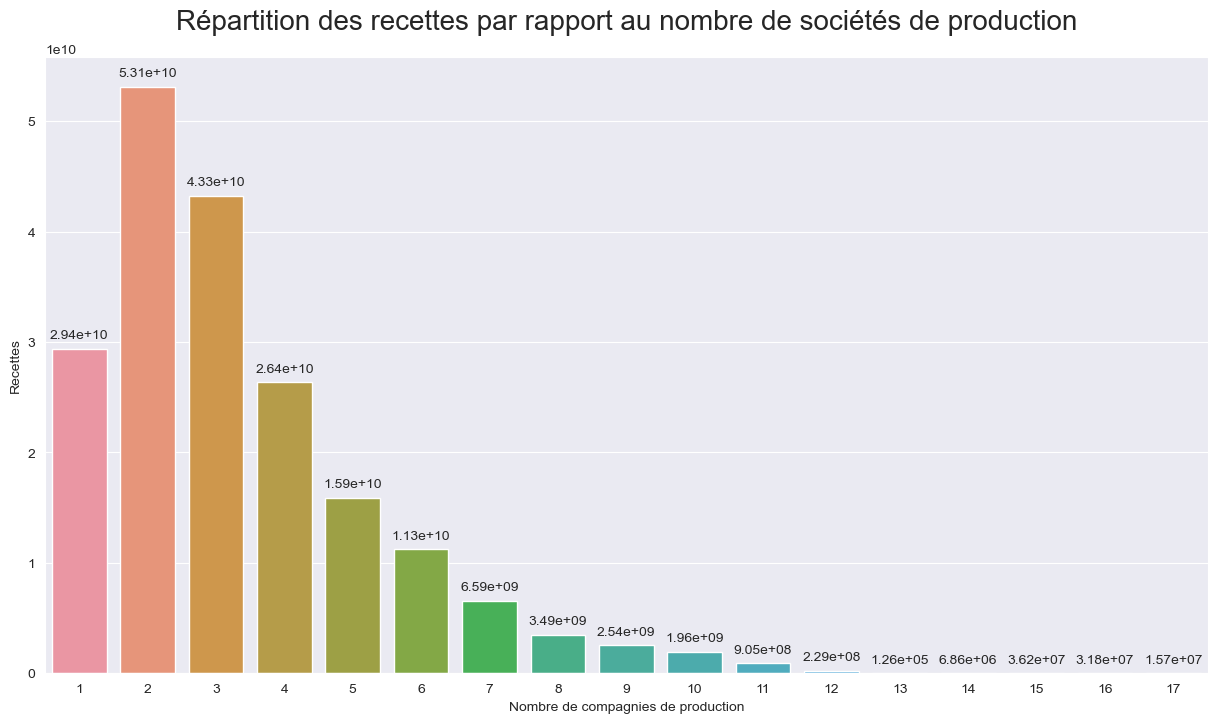

In [90]:
ax=sns.barplot(x="count_prod_companies",y="revenue", data=movies_train, estimator=sum, errorbar=None)
ax.bar_label(ax.containers[0], fmt='%.2e', padding=5)
plt.title('Répartition des recettes par rapport au nombre de sociétés de production', pad=20, size=20)
plt.xlabel("Nombre de compagnies de production")
plt.ylabel('Recettes')
plt.show()

**Observation**<br>
Trop de compagnies de production n'est pas un bon signe pour la rentabilité : c'est vraisemblablement signe de difficulté à monter le film.<br>
Le nombre de producteur idéal semble être 2 ou 3.<br>
Ca donnera un indicateur supplémentaire et intéressant pour la prédiction.

### production_countries
Encore un dictionnaire de données qu'il faut parser.

In [91]:
movies_train["count_prod_countries"] = ""
count_occurence(movies_train,movies_train.production_countries, "count_prod_countries")

movies_test["count_prod_countries"] = ""
count_occurence(movies_test,movies_test.production_countries, "count_prod_countries")

In [92]:
movies_train.groupby("count_prod_countries").agg(Revenue=("revenue",'sum'), Occurence=("revenue",'count'))

Revenue  Occurence
count_prod_countries                         
0                         73606250         11
1                     135903496123       2076
2                      44602464693        503
3                       8203621411        112
4                       4948313144         56
5                       1338146005         21
6                          8873892          3
8                         16756372          1

J'avais laissé les données nulles de production_countries.<br>
Je vais procéder à l'imputation des valeurs manquantes par la modalité (la valeur la plus présente).

In [93]:
movies_test[movies_test.count_prod_countries==0]["count_prod_countries"].count()

19

In [94]:
print (f"Il y a {movies_train[movies_train.count_prod_countries==0]['count_prod_countries'].count()} film(s) du jeu d'entraînement avec aucun pays de production et {movies_test[movies_test.count_prod_countries==0]['count_prod_countries'].count()} film(s) dans le jeu de test.")

Il y a 11 film(s) du jeu d'entraînement avec aucun pays de production et 19 film(s) dans le jeu de test.


In [95]:
cpc_to_replace=movies_train[movies_train.count_prod_countries==0]["count_prod_countries"].tolist()
movies_train["count_prod_countries"].replace(cpc_to_replace,stats.mode(movies_train.count_prod_countries), inplace=True)
movies_train.drop(columns=["production_countries"], inplace=True)

In [96]:
cpc_to_replace_test=movies_test[movies_test.count_prod_countries==0]["count_prod_countries"].tolist()
movies_test["count_prod_countries"].replace(cpc_to_replace_test,stats.mode(movies_test.count_prod_countries), inplace=True)
movies_test.drop(columns=["production_countries"], inplace=True)

Vérification

In [97]:
movies_train.groupby("count_prod_countries").agg(Revenue=("revenue",'sum'), Occurence=("revenue",'count'))

Revenue  Occurence
count_prod_countries                         
1                     135977102373       2087
2                      44602464693        503
3                       8203621411        112
4                       4948313144         56
5                       1338146005         21
6                          8873892          3
8                         16756372          1

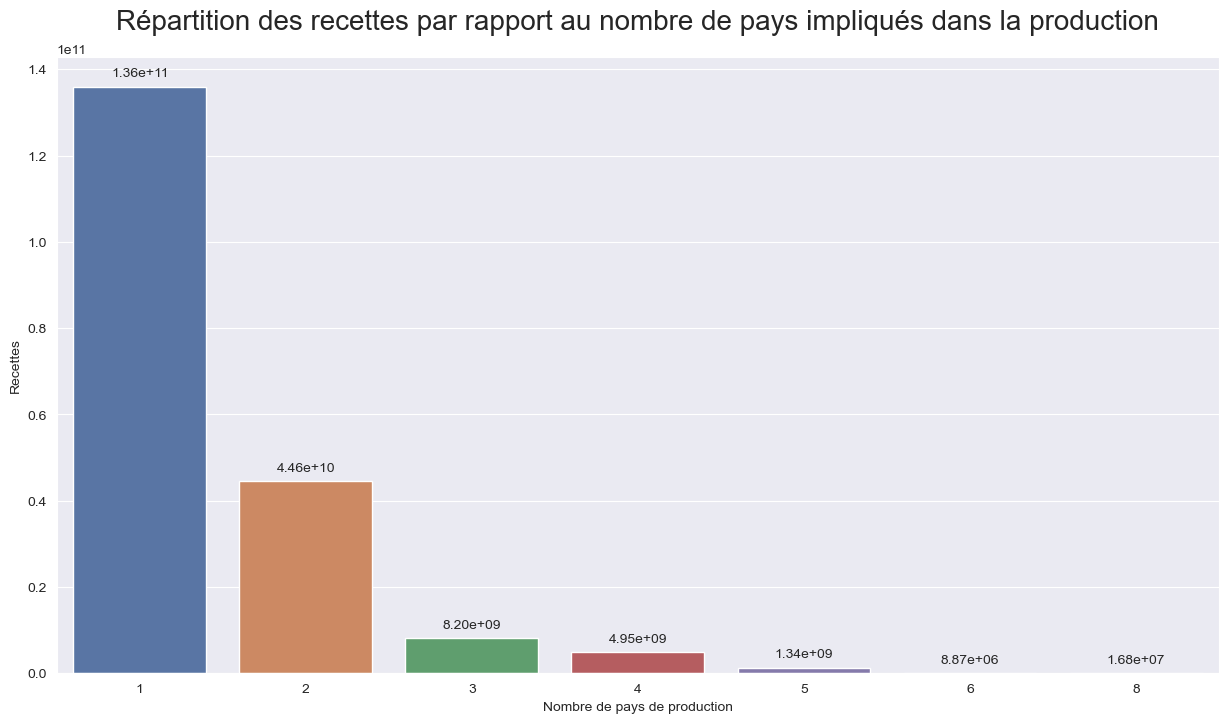

In [98]:
ax=sns.barplot(x="count_prod_countries",y="revenue", data=movies_train, estimator=sum,  errorbar=None)
#movies_train.groupby(["count_prod_countries"]).sum().plot(kind='bar', y='revenue')
ax.bar_label(ax.containers[0], fmt='%.2e', padding=5)
plt.title('Répartition des recettes par rapport au nombre de pays impliqués dans la production', pad=20, size=20)
plt.xlabel("Nombre de pays de production")
plt.ylabel('Recettes')
plt.show()


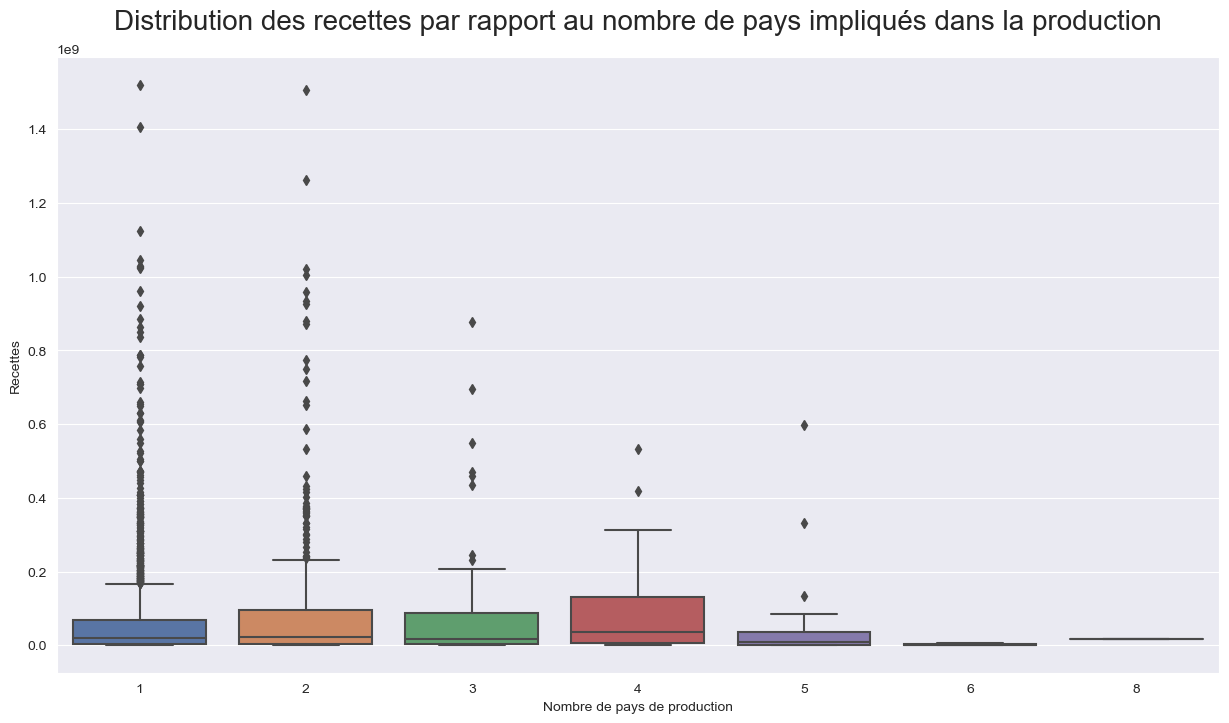

In [99]:
ax=sns.boxplot(data=movies_train, x=movies_train.count_prod_countries, y="revenue")
plt.title('Distribution des recettes par rapport au nombre de pays impliqués dans la production', pad=20, size=20)
plt.xlabel("Nombre de pays de production")
plt.ylabel('Recettes')
plt.show()

**Note**<br>
Il y a un lien entre le revenue et le nombre de pays de production.

### release_date 
On va transformer la données qui sont de type Object en Date pour avoir accès aux jour / mois / année de la date.<br>
Exemple = df['Datetime'] = pd.to_datetime(df['Datetime'], format="%m/%d/%Y, %H:%M:%S")

In [100]:
movies_train.release_date.dtype

dtype('O')

In [101]:
movies_train.release_date = pd.to_datetime(movies_train['release_date'], format="%m/%d/%y")
movies_test.release_date = pd.to_datetime(movies_test['release_date'], format="%m/%d/%y")

Vérification

In [102]:
movies_train.release_date.dtype

dtype('<M8[ns]')

In [103]:
movies_train["release_day_of_the_week"] = movies_train['release_date'].dt.strftime("%w").astype(int)
movies_train["release_month"] = movies_train['release_date'].dt.month
movies_train["release_year"] = movies_train["release_date"].apply(lambda x: x.strftime('%Y')).astype(int)
movies_train["release_week_of_year"] = movies_train["release_date"].dt.isocalendar().week.astype(int) #je rajoute la conversion en int pour ne pas avoir UInt32

In [104]:
movies_train.head(1)

is_collection    budget  popularity release_date  runtime    status  \
0              1  14000000    6.575393   2015-02-20     93.0  Released   

                                                tagline  \
0  The Laws of Space and Time are About to be Violated.   

                    title  \
0  Hot Tub Time Machine 2   

                                                                                                  cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': ...   

                                                                                                  crew  \
0  [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071...   

    revenue count_genres  genre_Comedy  genre_Drama  genre_Family  \
0  12314651            1             1            0             0   

   genre_Romance  genre_Horror  genre_Thriller  genre_Action  genre_Music  \
0              0             0               0             0            0   

   genre_Adventure  genre_Crime  genre_Science Fiction  genre_Mystery  \
0                0            0                      0              0   

   genre_Foreign  genre_Animation  genre_Fantasy  genre_War  genre_Western  \
0              0                0              0          0              0   

   genre_Documentary  genre_History  genre_TV Movie  english_language  \
0                  0              0               0                 1   

   count_prod_companies  count_prod_countries  release_day_of_the_week  \
0                     3                     1                        5   

   release_month  release_year  release_week_of_year  
0              2          2015                     8

In [105]:
movies_train.dtypes

is_collection                       int64
budget                              int64
popularity                        float64
release_date               datetime64[ns]
runtime                           float64
status                             object
tagline                            object
title                              object
cast                               object
crew                               object
revenue                             int64
count_genres                       object
genre_Comedy                        int64
genre_Drama                         int64
genre_Family                        int64
genre_Romance                       int64
genre_Horror                        int64
genre_Thriller                      int64
genre_Action                        int64
genre_Music                         int64
genre_Adventure                     int64
genre_Crime                         int64
genre_Science Fiction               int64
genre_Mystery                     

Je vérifie l'année de sortie des films.<br>
Le challenge a été proposé en 2019. J'identifie d'abord tous les films ayant une date de sortie après 06/02/2019 (date de début de la compétition) avant de décider quoi en faire.

In [106]:
movies_train[movies_train.release_date>="2019-02-06"].shape

(139, 39)

In [107]:
movies_train[movies_train.release_date>="2019-02-06"][["title", "release_date"]].sort_values("release_date")

title release_date
1763                           The Kid   2021-01-21
2992               The Thief of Bagdad   2024-03-18
1361               Battleship Potemkin   2025-12-24
2680                          Sparrows   2026-05-14
2946                      My Best Girl   2027-10-31
1760               Across to Singapore   2028-04-07
187                   West of Zanzibar   2028-11-24
2323                        L'Âge d'Or   2030-10-28
844                            Dracula   2031-02-12
939                          Mata Hari   2031-12-26
555                           Scarface   2032-04-09
1287                       Grand Hotel   2032-05-25
301                       I'm No Angel   2033-10-06
2007                   Queen Christina   2033-12-26
992                            Top Hat   2035-09-06
849                       Modern Times   2036-02-05
821                         Swing Time   2036-08-27
1189                The Gorgeous Hussy   2036-08-28
1245   The Charge of the Light Brigade   2036-10-20
2031          Alexander's Ragtime Band   2038-05-24
2190                         The Women   2039-01-01
2106                        Stagecoach   2039-03-02
2910                         Ninotchka   2039-10-06
456                            Rebecca   2040-04-12
2652                The Great Dictator   2040-10-15
1269                 For Me and My Gal   2042-10-21
1143                        Casablanca   2042-11-26
2054                        Cat People   2042-12-05
1621                  Cabin in the Sky   2043-04-09
1956              Five Graves to Cairo   2043-05-03
2046                   A Guy Named Joe   2044-03-01
648                       Going My Way   2044-05-15
2230            The Valley of Decision   2045-06-01
1592                  The Lost Weekend   2045-11-25
2879           The Bells of St. Mary's   2045-12-27
2487                    Scarlet Street   2045-12-28
2554                 Quai des Orfèvres   2047-10-03
2225             Gentleman's Agreement   2047-11-11
1804  The Treasure of the Sierra Madre   2048-01-24
2758                           Miranda   2048-04-06
2578                              Rope   2048-08-23
1686                         Red River   2048-08-26
2088                      3 Godfathers   2048-12-01
1667                     The Third Man   2049-08-31
333                Twelve O'Clock High   2049-12-21
1480                  Sunset Boulevard   2050-08-10
1650                     All About Eve   2050-11-09
2450                   Ace in the Hole   2051-06-29
1888                         Show Boat   2051-07-13
736                          Quo Vadis   2051-11-08
1580                 The African Queen   2051-12-03
644                              Ikiru   2052-10-09
1166                           Niagara   2053-01-26
1169                         Peter Pan   2053-02-05
2169                      House of Wax   2053-04-10
2321                           Titanic   2053-04-11
1468     The Beast from 20,000 Fathoms   2053-06-13
530                           The Robe   2053-09-16
480                        Red Garters   2054-02-09
1289    Creature from the Black Lagoon   2054-03-05
510                  On the Waterfront   2054-06-22
2888                  The Caine Mutiny   2054-06-24
705                        Rear Window   2054-08-01
2189                The Silver Chalice   2054-12-20
685              Bad Day at Black Rock   2055-01-07
1623                            Rififi   2055-04-13
1570                Lady and the Tramp   2055-06-16
679                   To Catch a Thief   2055-08-03
2224                   Pather Panchali   2055-08-26
1367            The Trouble with Harry   2055-10-03
61                             Trapeze   2056-05-30
2446                         Moby Dick   2056-06-27
523               The Ten Commandments   2056-10-05
257                     Love Me Tender   2056-11-15
504        Gunfight at the O.K. Corral   2057-05-30
1764      The Bridge on the River Kwai   2057-10-02
1227                Legend of

**Note**<br>
Après vérification d'une dizaine de titres, ce sont des films avec une erreur de 100 ans sur l'année de sortie.<br>
Je corrige donc en retirant 100 ans à l'année de sortie.

In [108]:
movies_train.loc[2649,["title", "release_date", "release_year"]]

title                       Shalako
release_date    2068-11-06 00:00:00
release_year                   2068
Name: 2649, dtype: object

In [109]:
movies_train.loc[movies_train.release_date>="2019-02-06","release_year"]= movies_train.release_year-100

Vérification

In [110]:
movies_train.loc[2649,["title", "release_date", "release_year"]]

title                       Shalako
release_date    2068-11-06 00:00:00
release_year                   1968
Name: 2649, dtype: object

#### Jour de sortie

Je prépare mes labels pour les jours de sorties pour éviter d'avoir des chiffres.

In [111]:
days_of_the_week=["Dimanche", "Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi"]

Jours de la semaine avec le chiffre correspondant 

In [112]:
figures_days_of_the_week=sorted(movies_train.release_day_of_the_week.unique())

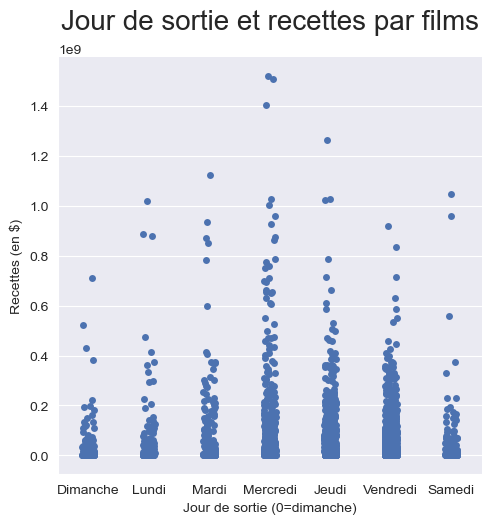

In [113]:
sns.catplot(x="release_day_of_the_week", y="revenue", data=movies_train)
plt.xlabel("Jour de sortie (0=dimanche)")
plt.ylabel("Recettes (en $)")
plt.xticks(ticks=figures_days_of_the_week, labels=days_of_the_week)
plt.title ("Jour de sortie et recettes par films", pad=20, size=20)
plt.show()
        

In [114]:
movies_train.groupby("release_day_of_the_week")["release_day_of_the_week"].agg('count')

release_day_of_the_week
0     109
1     119
2     182
3     422
4     564
5    1248
6     139
Name: release_day_of_the_week, dtype: int64

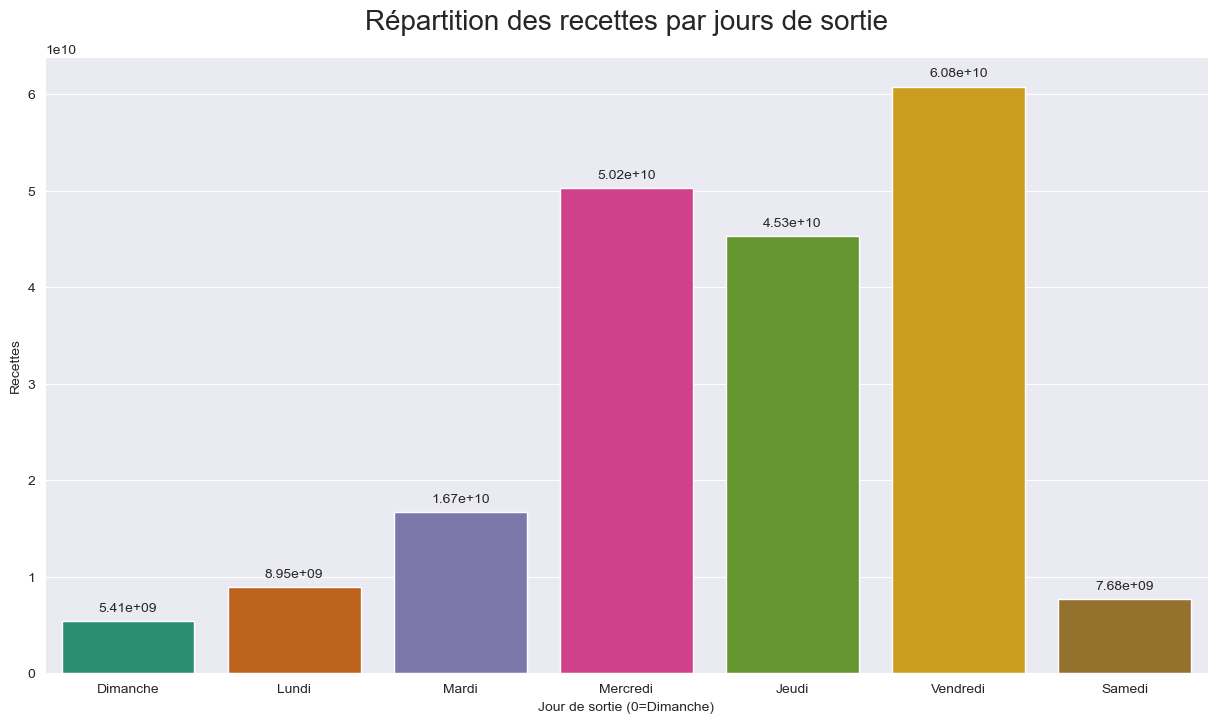

In [115]:
ax=sns.barplot(x="release_day_of_the_week",y="revenue", data=movies_train, palette='Dark2', estimator=sum, errorbar=None)
ax.bar_label(ax.containers[0], fmt='%.2e', padding=5)
plt.title('Répartition des recettes par jours de sortie', pad=20, size=20)
plt.xticks(ticks=figures_days_of_the_week, labels=days_of_the_week)
plt.xlabel("Jour de sortie (0=Dimanche)")
plt.ylabel('Recettes')
plt.show()

#### Semaine de sortie

In [116]:
release_week_count_df=movies_train.groupby("release_week_of_year").agg(occurence=("title",'count'), revenue=("revenue","sum"))
release_week_count_df

occurence     revenue
release_week_of_year                       
1                            17   225131965
2                            44  2165975955
3                            49  1761992333
4                            39  1104715783
5                            63  2712282304
6                            63  5245944551
7                            53  2023521337
8                            40  2291313681
9                            47  3630533677
10                           57  4050262222
11                           50  4505690525
12                           49  4873634891
13                           37  1317530732
14                           64  4249949846
15                           57  1758838618
16                           56  2875434244
17                           49  4699123264
18                           34  1243790527
19                           46  3751270586
20                           57  6512351910
21                           50  5247779439
22                           47  4483056481
23                           47  6552788119
24                           56  6478575132
25                           44  7923840423
26                           59  6458879764
27                           50  4439997317
28                           38  4418712710
29                           43  4135490885
30                           48  4530357587
31                           53  4192122634
32                           70  4270641898
33                           47  1282973389
34                           49  1447932155
35                           52  1500436747
36                           89  1788076440
37                          106  4690795733
38                           58  1867587750
39                           64  3622751351
40                           69  3426482205
41                           68  2922912130
42                           61  2707857550
43                           59  2034168585
44                           52  4251043966
45                           45  3164618792
46                           54  5516240329
47                           46  3614459477
48                           36  3013049314
49                           44  4942799662
50                           67  8245928456
51                           81  7343137161
52                           53  3555542938
53                            7    24952420

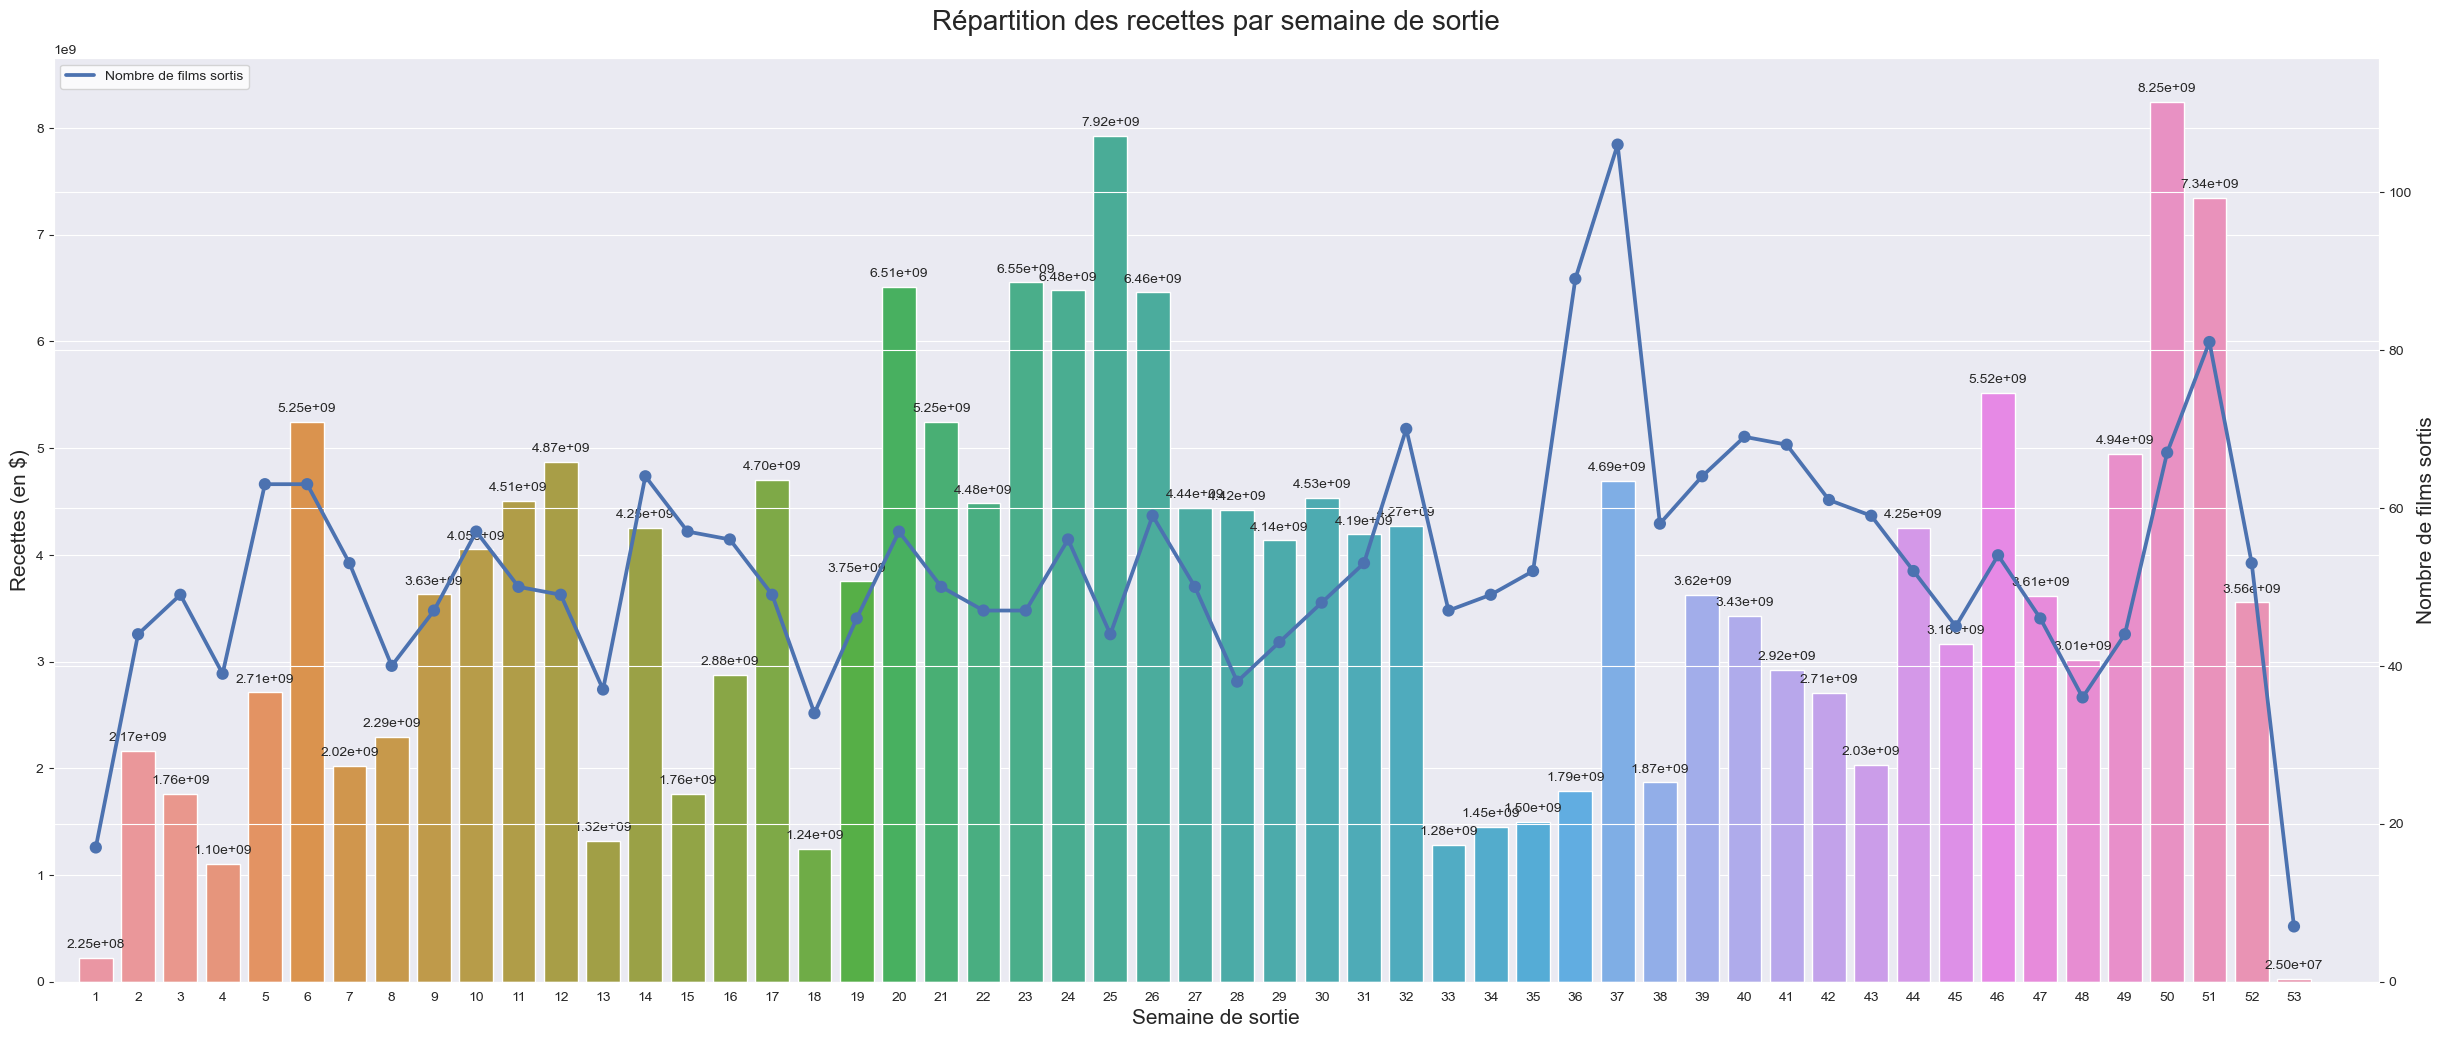

In [117]:
fig, ax = plt.subplots(figsize=(30,12))

ax=sns.barplot(data=movies_train, x="release_week_of_year",y="revenue", estimator=sum, errorbar=None)
ax.bar_label(ax.containers[0], fmt='%.2e', padding=5)
ax.set_ylabel('Recettes (en $)', size = 15)
ax.set_xlabel('Semaine de sortie', size = 15)

ax2 = ax.twinx() #pour que chaque graphe ait son échelle 
ax2=sns.pointplot(data=release_week_count_df, x=release_week_count_df.index,y="occurence", ax=ax2) # si j'utilise lineplot, j'ai un décalage de l'axe des x de 1. Avec matplotlib c'est ok
ax2.set_ylabel('Nombre de films sortis', size = 15)

ax2.legend(['Nombre de films sortis'], facecolor='w', loc='upper left')

# Je vérifie l'alignement des 0 sur les axes y
#ax2.axhline(0)
#ax.axhline(0)

# Pour aligner les 0 des 2 axes y, je définis les limites
ax2.set_ylim(0,math.ceil(max(release_week_count_df.occurence)*1.1))

# J'ajoute de l'espace avant et après le graphe sur l'axe x
ax.set_xlim(min(movies_train.release_week_of_year)-2,max(movies_train.release_week_of_year)+1)

plt.title('Répartition des recettes par semaine de sortie', pad=20, size=20)

plt.show()
plt.close()

**Note**<br>
Le nombre de films sortis n'a pas d'influence sur le B-O, contrairement à la période de sortie du film.<br>
On va le confirmer avec l'analise du B-O sur les mois.

#### Mois de sortie

In [118]:
movies_train.groupby("release_month")["release_month"].agg('count')

release_month
1     189
2     203
3     224
4     231
5     209
6     223
7     195
8     239
9     330
10    287
11    202
12    251
Name: release_month, dtype: int64

In [119]:
#release_month_df=movies_train.groupby("release_month").agg({'revenue':'sum'})
#release_month_df

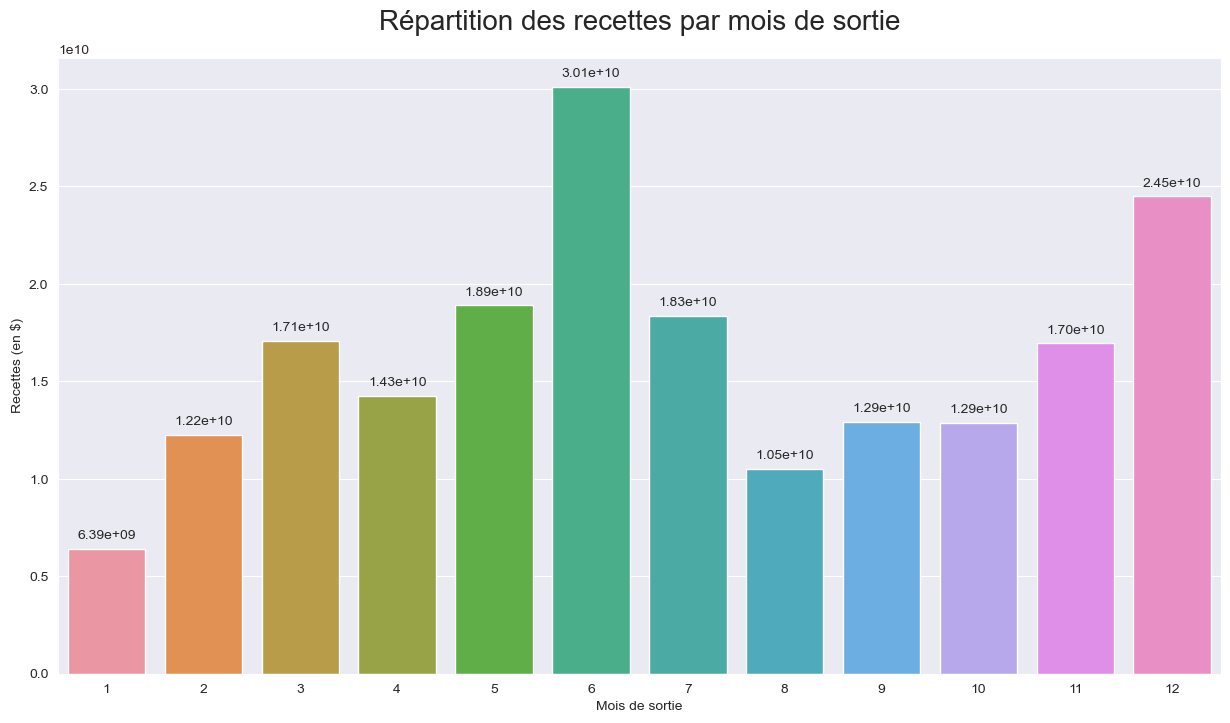

In [120]:
ax=sns.barplot(x="release_month",y="revenue", data=movies_train, estimator=sum, errorbar=None)
ax.bar_label(ax.containers[0], fmt='%.2e', padding=5)
plt.title('Répartition des recettes par mois de sortie', pad=20, size=20)
plt.xlabel("Mois de sortie")
plt.ylabel('Recettes (en $)')
plt.show()

#### Année de sortie

Je créé la variable décennie.<br>
Pour calculer la décennie, je divise l'année de sortie par 10, je convertis en entier numérique pour me débarasser de ce qu'il y a après la virgule puis je remultiplie par 10.

In [121]:
movies_train['release_decade']= movies_train["release_year"].apply(lambda x: int(x/10)*10)

In [122]:
movies_train.head(2)

is_collection    budget  popularity release_date  runtime    status  \
0              1  14000000    6.575393   2015-02-20     93.0  Released   
1              1  40000000    8.248895   2004-08-06    113.0  Released   

                                                        tagline  \
0          The Laws of Space and Time are About to be Violated.   
1  It can take a lifetime to find true love; she's got 30 days!   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   

                                                                                                  cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': ...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis', 'credit_id': '52fe43fe9251416c7502561f', 'gender...   

                                                                                                  crew  \
0  [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071...   
1  [{'credit_id': '52fe43fe9251416c7502563d', 'department': 'Directing', 'gender': 2, 'id': 1201, '...   

    revenue count_genres  genre_Comedy  genre_Drama  genre_Family  \
0  12314651            1             1            0             0   
1  95149435            4             1            1             1   

   genre_Romance  genre_Horror  genre_Thriller  genre_Action  genre_Music  \
0              0             0               0             0            0   
1              1             0               0             0            0   

   genre_Adventure  genre_Crime  genre_Science Fiction  genre_Mystery  \
0                0            0                      0              0   
1                0            0                      0              0   

   genre_Foreign  genre_Animation  genre_Fantasy  genre_War  genre_Western  \
0              0                0              0          0              0   
1              0                0              0          0              0   

   genre_Documentary  genre_History  genre_TV Movie  english_language  \
0                  0              0               0                 1   
1                  0              0               0                 1   

   count_prod_companies  count_prod_countries  release_day_of_the_week  \
0                     3                     1                        5   
1                     1                     1                        5   

   release_month  release_year  release_week_of_year  release_decade  
0              2          2015                     8            2010  
1              8          2004                    32            2000

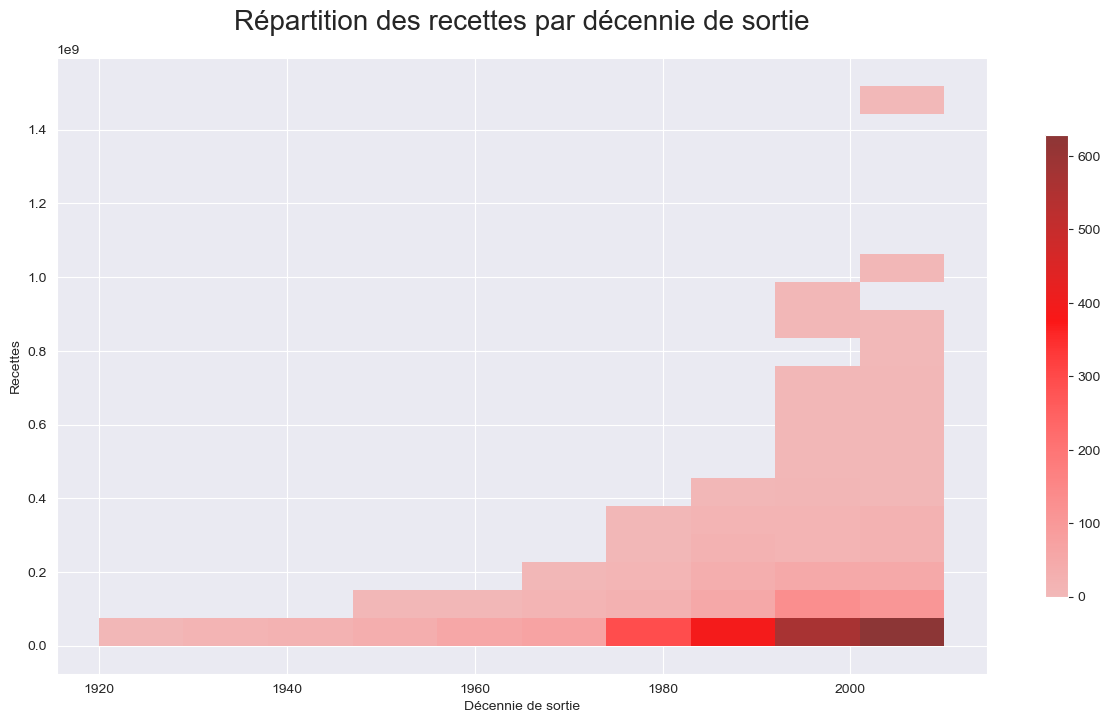

In [123]:
bins=movies_train.release_decade.nunique()
ax=sns.histplot(data=movies_train, x="release_decade", y="revenue",  bins=[bins,20], thresh=1, color="Red",cbar=True, cbar_kws=dict(shrink=.75))

#ax.bar_label(ax.containers[0],  padding=5)
plt.title('Répartition des recettes par décennie de sortie', pad=20, size=20)
plt.xlabel("Décennie de sortie")
plt.ylabel('Recettes')
plt.show()
plt.close()

In [124]:
movies_train.groupby("release_decade")["revenue"].sum()

release_decade
1920        7270615
1930       40610886
1940      135652152
1950      815515661
1960     1436528663
1970     4841033750
1980    13690692444
1990    32417867220
2000    68334515718
2010    73375590781
Name: revenue, dtype: int64

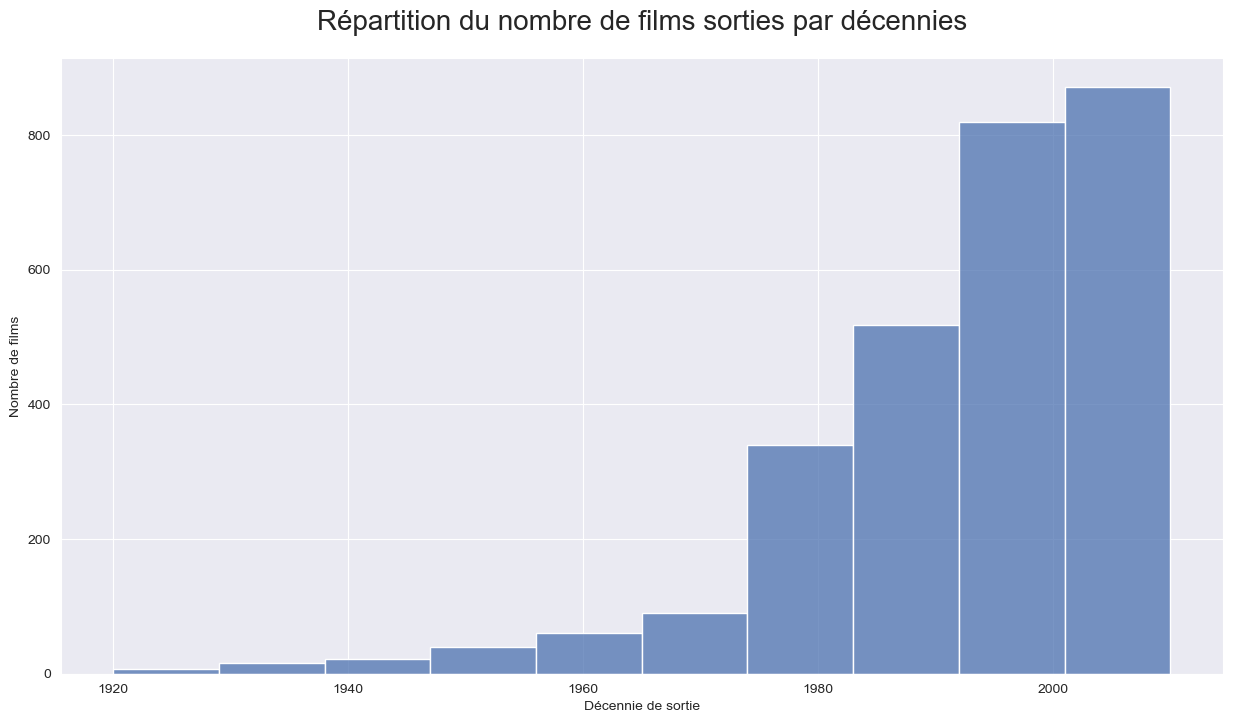

In [125]:
bins=movies_train.release_decade.nunique()
ax=sns.histplot(data=movies_train, x="release_decade", bins=bins)
ax.bar_label(ax.containers[0],  padding=5)
plt.title('Répartition du nombre de films sorties par décennies', pad=20, size=20)
plt.xlabel("Décennie de sortie")
plt.ylabel('Nombre de films')
plt.show()
plt.close()

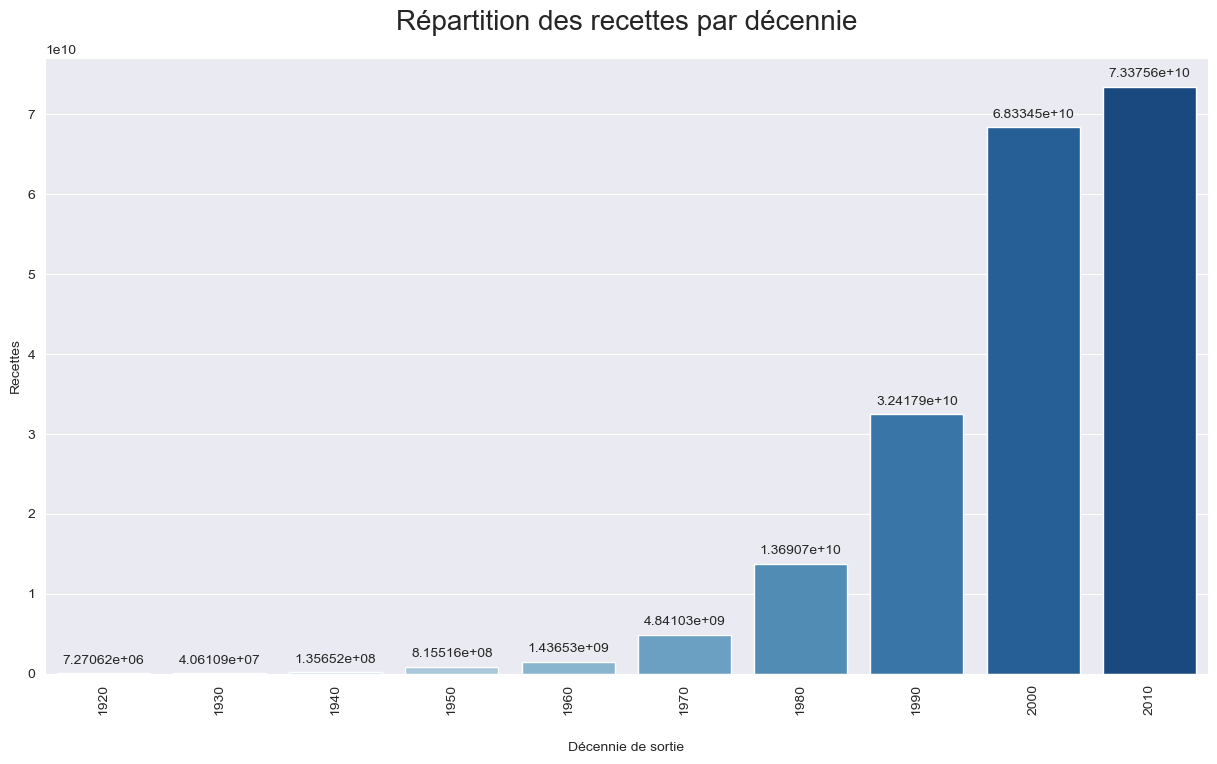

In [126]:
ax=sns.barplot(data=movies_train, x="release_decade", y="revenue", errorbar=None, estimator=sum, palette="Blues")
ax.bar_label(ax.containers[0],  padding=5)
plt.title('Répartition des recettes par décennie', pad=20, size=20)
plt.xlabel("Décennie de sortie", labelpad=20)
plt.xticks(rotation=90)
plt.ylabel('Recettes')
plt.show()
plt.close()

**Synthèse**<br>
- *Jour de sortie*<br>
Le jour de la sortie dépend du pays de sortie. Ainsi, on voit que c'est le vendredi qui comptabilise le plus de recettes car c'est le jour de sorties de films aux E-U.<br>
Cette donnée n'est donc pas pertinente même si elle nous renseigne sur le fait que les films américains font le plus d'entées.<br>
👉🏼 Suppression   
- *Semaine de sortie*<br>
Il y a une influence sur les revenues
- *Mois de sortie*<br>
Même observation, même si moins fine, que la semaine de sortie.
- *Année de sortie*<br>
L'année de sortie n'est pas significative. On observe que plus il y a de sorties de films, plus le B-O augmente. Ce qui est logique.
Il n'y a pas de lien entre les recettes et l'année de sortie. Enfin l'inflation joue forcément un rôle lorsqu'on compte en devise et pas en entrée.<br>
👉🏼 Suppression
- *Date de sortie*
Après avoir explosé la date de sortie pour l'analyser, je n'ai plus besoin de la donnée d'origine.<br>
👉🏼 Suppression

Je supprime les données jour, année, décennie de sortie

In [127]:
movies_train.drop(columns="release_day_of_the_week" ,inplace=True)
movies_train.drop(columns="release_year" ,inplace=True)
movies_train.drop(columns="release_decade" ,inplace=True)

J'ajoute au fichier de test les colonnes semaine de sortie et mois de sortie.

In [128]:
movies_test["release_month"] = movies_test['release_date'].dt.month
movies_test["release_week_of_year"] = movies_test["release_date"].dt.isocalendar().week.astype(int) #je rajoute la conversion en int pour ne pas avoir UInt32

Je n'ai plus besoin de la date de sortie, je peux supprimer la colonne

In [129]:
movies_train.drop(columns="release_date", inplace=True)
movies_test.drop(columns="release_date", inplace=True)

### popularity

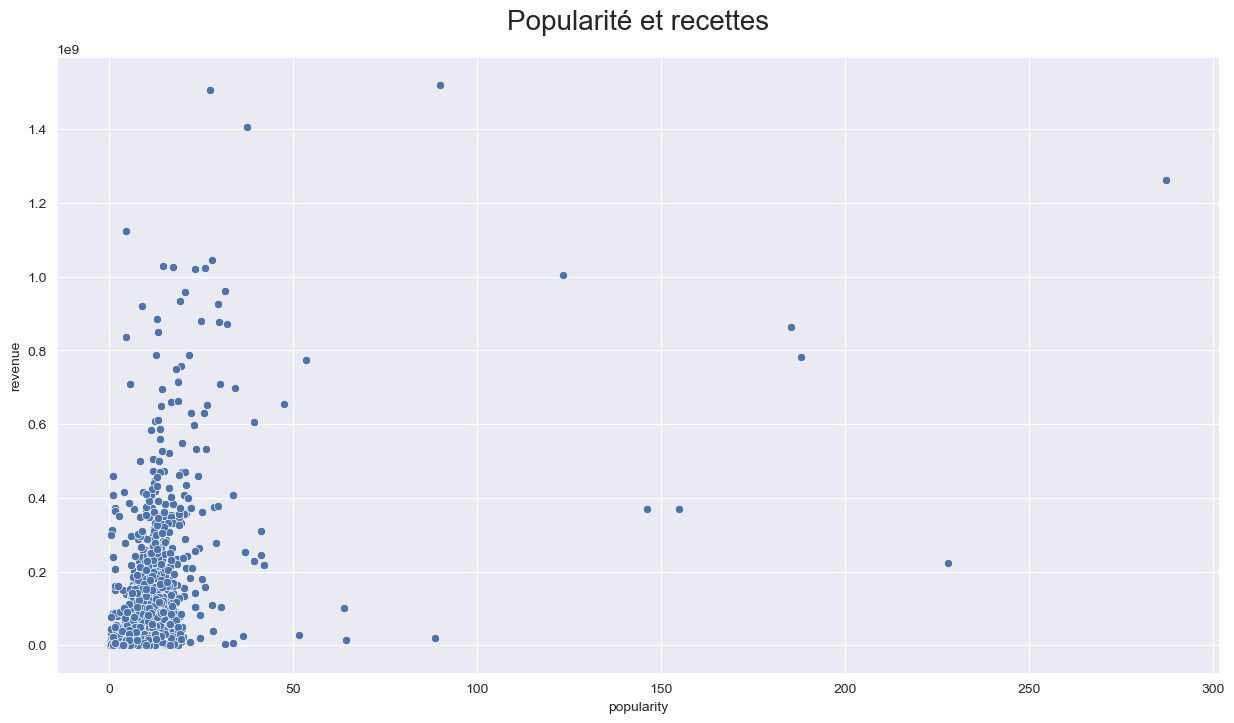

In [130]:
sns.scatterplot(data=movies_train, x="popularity", y="revenue")
plt.title ("Popularité et recettes", pad=20, size=20)
plt.show()
plt.close()

**Note**<br>
On ne sait pas vraiment concrètement cette variable ni comment la note est établie.<br> 
Mais c'est une variable importante pour TMDB (voir doc api) qui doit aider à prédire le budget.<br>
Pour une prédiction sur des films à venir, je pense que cette donnée n'est pas disponible et le modèle ne serait pas correct. Mais là la donnée est présente dans le fichier test.

In [131]:
#movies_train.drop(columns="popularity",inplace=True)

#movies_test.drop(columns="popularity",inplace=True)

### runtime

On a identifié en début d'analyse des données manquantes dans le jeu de test : on va regarder l'influence de la durée sur le budget et imputer une valeur si la variable est pertinente pour la prédiction.

In [132]:
movies_train[movies_train.runtime.isnull()].shape[0]

0

In [133]:
movies_test[movies_test.runtime.isnull()].shape[0]

3

Je rempalce pour le moment les Nan par 0.

In [134]:
movies_test.runtime.fillna(0, inplace=True)

Vérification

In [135]:
movies_test[movies_test.runtime.isnull()].shape[0]

0

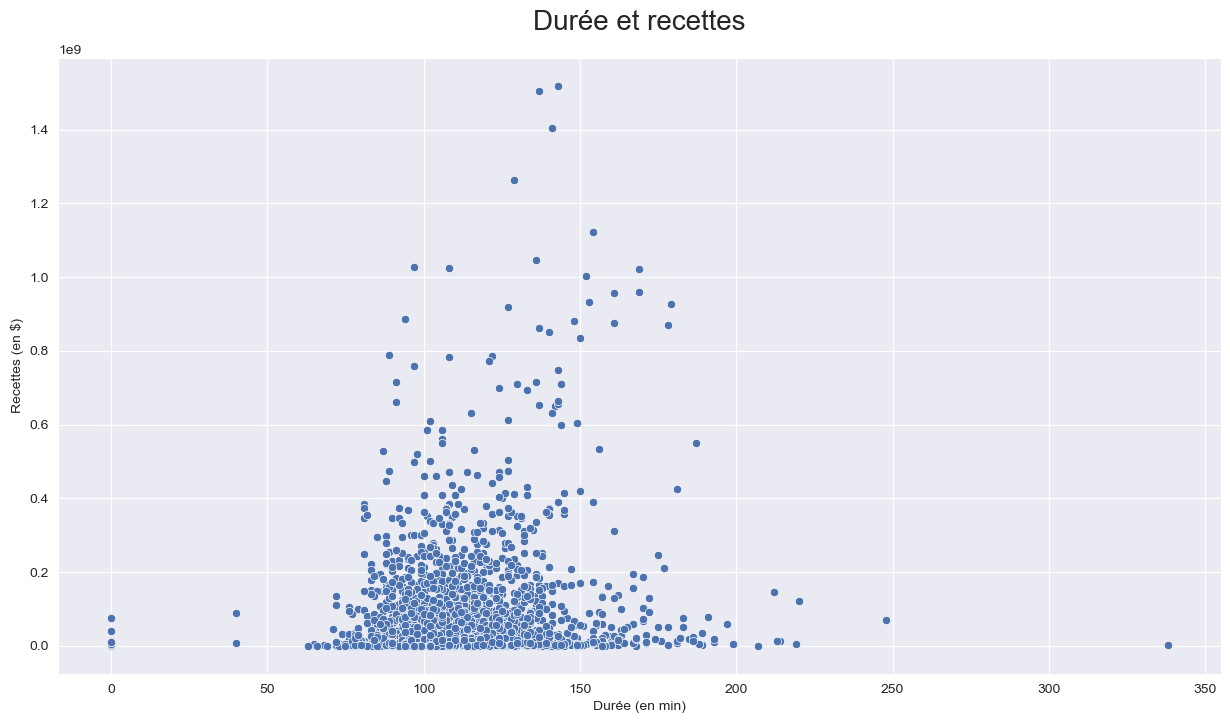

In [136]:
sns.scatterplot(data=movies_train, x="runtime", y="revenue")
plt.title ("Durée et recettes", pad=20, size=20)
plt.xlabel("Durée (en min)")
plt.ylabel("Recettes (en $)")
plt.show()
plt.close()

**Note**<br>
On voit quelques films dont la durée vaut 0. Il faudra les traiter comme des données manquantes.<br>
Il y a également 2 films dont la durée est inférieure à ce qui fait d'une oeuvre un long métrage (58min et 29 s) : ce sont des documentaires et la durée est normale.

In [137]:
movies_train[(movies_train.runtime==0)]

is_collection    budget  popularity  runtime    status tagline  \
390               0   6843500    3.800073      0.0  Released     NaN   
591               0  18000000    0.402368      0.0  Released     NaN   
924               0  18000000    1.926826      0.0  Released     NaN   
977               0  11000000    5.010563      0.0  Released     NaN   
1255              0  18000000    1.623440      0.0  Released     NaN   
2150              0   5000000    0.414793      0.0  Released     NaN   
2645              0  18000000    0.504000      0.0  Released     NaN   
2785              0  18000000    0.625099      0.0  Released     NaN   
2865              1   5579750    2.208906      0.0  Released     NaN   

                                    title  \
390        The Worst Christmas of My Life   
591               А поутру они проснулись   
924                  ¿Quién mató a Bambi?   
977   La peggior settimana della mia vita   
1255                          Cry, Onion!   
2150                          Mechenosets   
2645                     My Old Classmate   
2785                           Revelation   
2865            Tutto tutto niente niente   

                                                                                                     cast  \
390   [{'cast_id': 2, 'character': 'Alberto', 'credit_id': '52fe4bb79251416c7510bc7d', 'gender': 2, 'i...   
591   [{'cast_id': 8, 'character': '', 'credit_id': '52fe4d449251416c91110417', 'gender': 2, 'id': 810...   
924   [{'cast_id': 3, 'character': 'David', 'credit_id': '52fe4e31c3a368484e213713', 'gender': 0, 'id'...   
977   [{'cast_id': 4, 'character': 'Paolo', 'credit_id': '52fe4984c3a368484e12f92f', 'gender': 2, 'id'...   
1255  [{'cast_id': 14, 'character': 'Onion Stark', 'credit_id': '52fe493a9251416c750c16bf', 'gender': ...   
2150  [{'cast_id': 2, 'character': 'Sasha', 'credit_id': '52fe46bec3a368484e0a14fb', 'gender': 0, 'id'...   
2645  [{'cast_id': 0, 'character': 'Zhou Xiao Zhi', 'credit_id': '54064d4d0e0a2658de00e038', 'gender':...   
2785  [{'cast_id': 1, 'character': 'Jake Martel', 'credit_id': '52fe4981c3a36847f819d967', 'gender': 2...   
2865  [{'cast_id': 1, 'character': 'Cetto La Qualunque / Rodolfo Favaretto / Frengo Stoppato', 'credit...   

                                                                                                     crew  \
390   [{'credit_id': '52fe4bb79251416c7510bc79', 'department': 'Directing', 'gender': 0, 'id': 129106,...   
591   [{'credit_id': '52fe4d449251416c911103f5', 'department': 'Directing', 'gender': 2, 'id': 124757,...   
924   [{'credit_id': '52fe4e31c3a368484e21370b', 'department': 'Directing', 'gender': 0, 'id': 562915,...   
977   [{'credit_id': '52fe4984c3a368484e12f923', 'department': 'Directing', 'gender': 0, 'id': 129106,...   
1255  [{'credit_id': '52fe493a9251416c750c169b', 'department': 'Directing', 'gender': 2, 'id': 50739, ...   
2150  [{'credit_id': '52fe46bec3a368484e0a14f7', 'department': 'Directing', 'gender': 0, 'id': 55516, ...   
2645  [{'credit_id': '54064dd90e0a2658d800d8d9', 'department': 'Production', 'gender': 0, 'id': 588386...   
2785  [{'credit_id': '52fe4981c3a36847f819d97d', 'department': 'Directing', 'gender': 0, 'id': 133210,...   
2865  [{'credit_id': '52fe4c48c3a36847f82269b9', 'department': 'Directing', 'gender': 0, 'id': 223965,...   

       revenue count_genres  genre_Comedy  genre_Drama  genre_Family  \
390   10703234            1             1            0             0   
591     234748            2             1            1             0   
924     850259            1             1            0             0   
977   12935800            1             1            0             0   
1255  39598448            1             0            0             0   
2150   3919731            4             0            0             0   
2645  76000000            1             0            0             0   
2785  10000000            4             0            0             0   
2865

In [138]:
movies_test[(movies_test.runtime==0)]

is_collection    budget  popularity  runtime    status tagline  \
243               0  18000000    0.000464      0.0  Released     NaN   
1489              0  18000000    0.661399      0.0  Released     NaN   
1632              0  18000000    0.281500      0.0  Released     NaN   
2844              0  18000000    2.144310      0.0  Released     NaN   
3209              0   3800000    0.072704      0.0  Released     NaN   
4320              0  18000000    0.191219      0.0  Released     NaN   

                            title  \
243     La caliente niña Julietta   
1489  Pancho, el perro millonario   
1632      Nunca en horas de clase   
2844        Frau Müller muss weg!   
3209              The Last Breath   
4320           El truco del manco   

                                                                                                     cast  \
243   [{'cast_id': 7, 'character': 'Julietta Santigosa', 'credit_id': '55678d96c3a3681c6b000710', 'gen...   
1489  [{'cast_id': 3, 'character': 'Alberto', 'credit_id': '52fe4e1c9251416c91126d21', 'gender': 0, 'i...   
1632  [{'cast_id': 6, 'character': 'Susy', 'credit_id': '544d2e0f0e0a2608d00028d1', 'gender': 1, 'id':...   
2844  [{'cast_id': 0, 'character': 'Frau M√ºller', 'credit_id': '54a6e528925141236b00e966', 'gender': ...   
3209  [{'cast_id': 0, 'character': 'Lauren Vaillancourt', 'credit_id': '53e55db8c3a368443f000240', 'ge...   
4320  [{'cast_id': 6, 'character': "Quique Heredia 'El Cuajo'", 'credit_id': '52fe4b059251416c750f5b0b...   

                                                                                                     crew  \
243   [{'credit_id': '55678cf992514156b600069f', 'department': 'Writing', 'gender': 0, 'id': 53943, 'j...   
1489  [{'credit_id': '52fe4e1c9251416c91126d43', 'department': 'Directing', 'gender': 2, 'id': 113417,...   
1632  [{'credit_id': '544d2dd20e0a2608c2002879', 'department': 'Crew', 'gender': 0, 'id': 33800, 'job'...   
2844  [{'credit_id': '56b5e384c3a36806f8007f78', 'department': 'Production', 'gender': 2, 'id': 674, '...   
3209  [{'credit_id': '53e55e69c3a3684442000231', 'department': 'Directing', 'gender': 0, 'id': 39713, ...   
4320  [{'credit_id': '5509f03cc3a3682832000044', 'department': 'Art', 'gender': 0, 'id': 15606, 'job':...   

     count_genres  genre_Horror  genre_Science Fiction  genre_Comedy  \
243             1             0                      0             1   
1489            1             0                      0             1   
1632            1             0                      0             1   
2844            1             0                      0             1   
3209            2             0                      0             0   
4320            1             0                      0             0   

      genre_Romance  genre_Drama  genre_War  genre_Mystery  genre_Animation  \
243               0            0          0              0                0   
1489              0            0          0              0                0   
1632              0            0          0              0                0   
2844              0            0          0              0                0   
3209              0            1          0              0                0   
4320              0            1          0              0                0   

      genre_Family  genre_Thriller  genre_Action  genre_Adventure  \
243              0               0             0                0   
1489             0               0             0                0   
1632             0               0             0                0   
2844             0               0             0                0   
3209             0               0             0                0   
4320             0               0             0                0   

      genre_Music  genre_Crime  genre_Fantasy  genre_Western  \
243             0            0              0              0   
1489            0            0            

In [139]:
mean_runtime=int(np.mean(movies_train.runtime))
mean_runtime_test=int(np.mean(movies_test.runtime))
median_runtime=int(np.median(movies_train.runtime))
median_runtime_test=int(np.median(movies_test.runtime))
mod_runtime=int(stats.mode(movies_train.runtime))
mod_runtime_test=int(stats.mode(movies_test.runtime))

print (f"""Pour les films du jeu d'entraînement, la durée
- moyenne vaut {mean_runtime} min,
- médiane vaut {median_runtime} min,
- modale vaut {mod_runtime} min.
Pour les films du jeu de test, la durée
- moyenne vaut {mean_runtime_test} min,
- médiane vaut {median_runtime_test} min,
- modale vaut {mod_runtime_test} min.
""")

Pour les films du jeu d'entraînement, la durée
- moyenne vaut 108 min,
- médiane vaut 105 min,
- modale vaut 100 min.
Pour les films du jeu de test, la durée
- moyenne vaut 107 min,
- médiane vaut 104 min,
- modale vaut 100 min.



Les valeurs se valent. Je vais prendre la valeur médiane pour procéder à mon imputation.

In [140]:
movies_train.loc[(movies_train.runtime==0),"runtime"]= median_runtime
movies_test.loc[(movies_test.runtime==0),"runtime"] = median_runtime_test

Vérification

In [141]:
movies_test.loc[390, "runtime"]

129.0

In [142]:
movies_test.loc[243, "runtime"]

104.0

Je convertis la colonne en entier numérique.

In [143]:
movies_test.runtime=movies_test.runtime.astype(int)
movies_train.runtime=movies_train.runtime.astype(int)

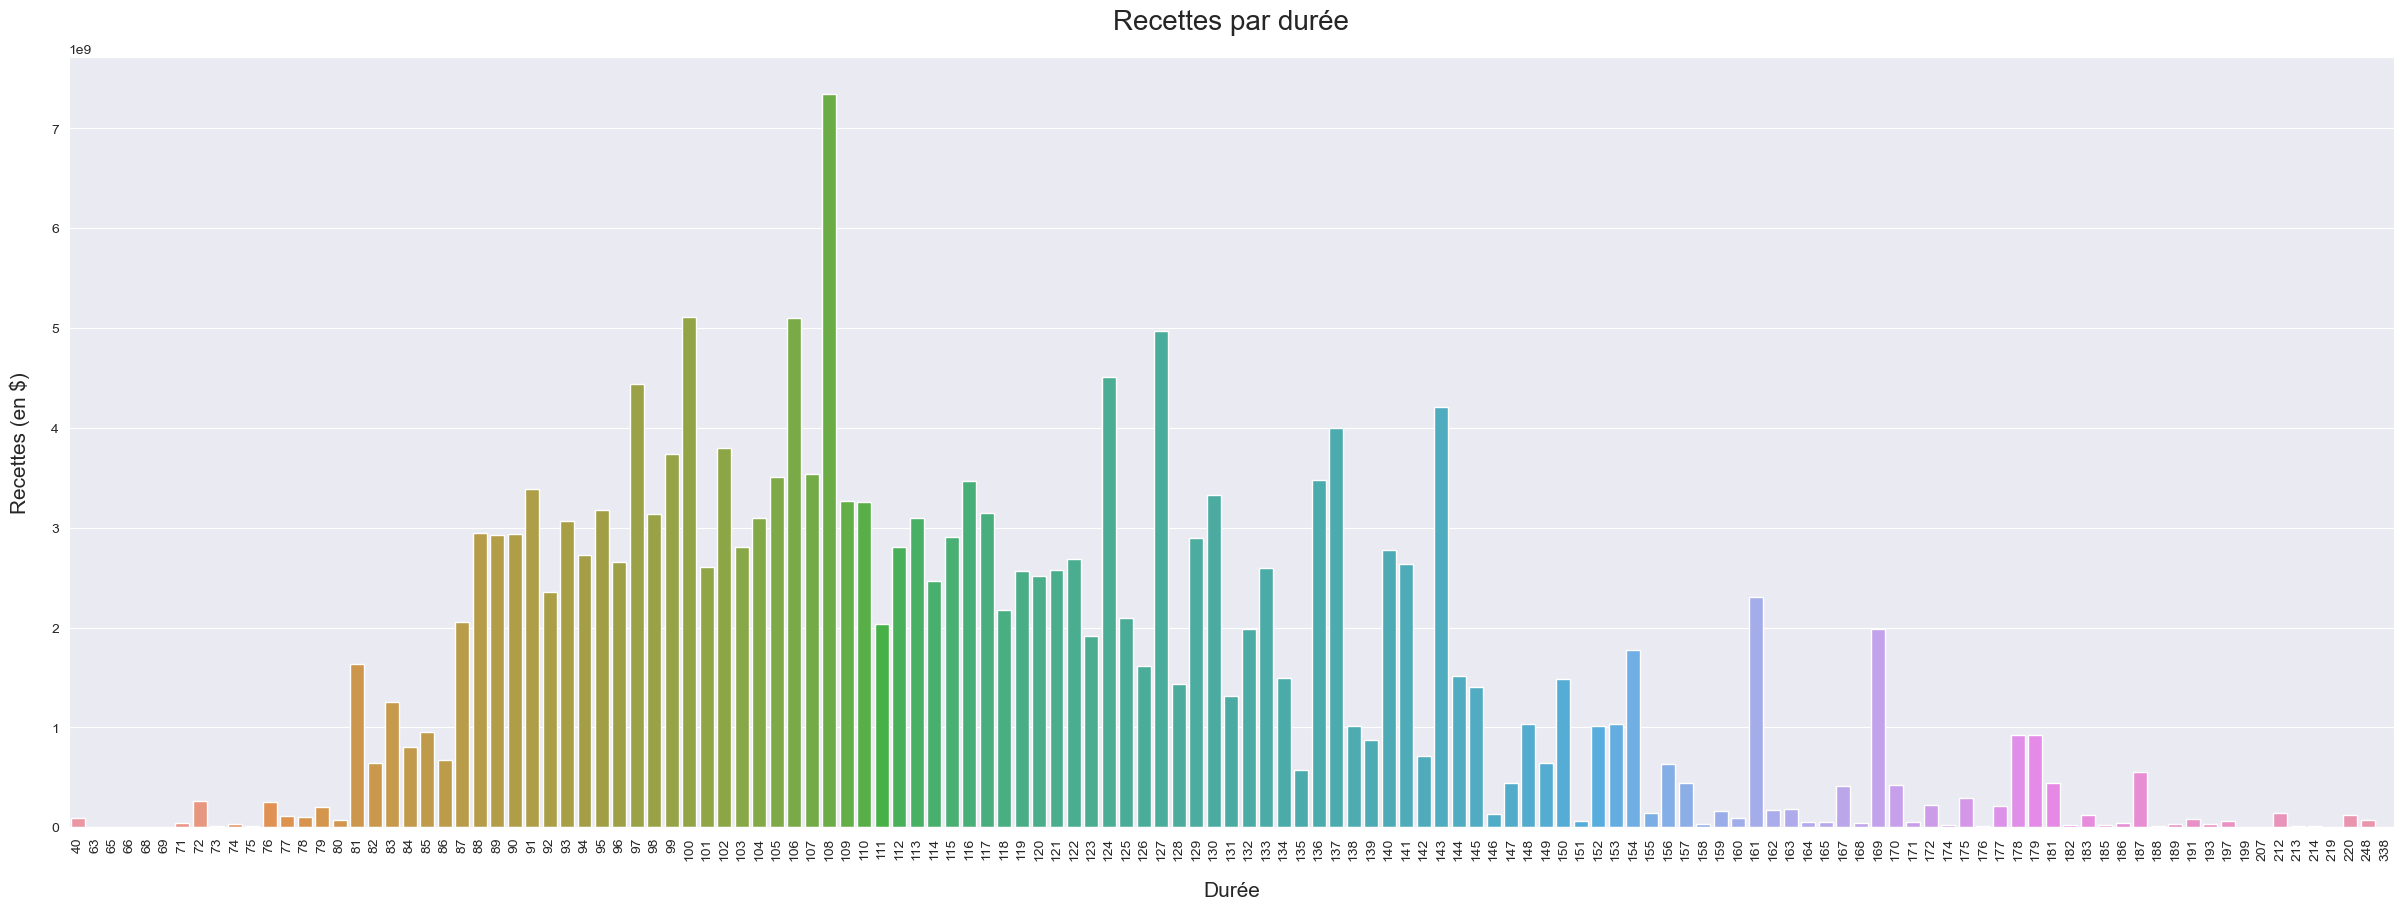

In [144]:
plt.figure(figsize=(30,10))
sns.barplot(data=movies_train, x="runtime", y ="revenue", errorbar=None, estimator=sum)
plt.title("Recettes par durée", size=20, pad=20)
plt.xlabel("Durée", size = 15, labelpad=15)
plt.ylabel("Recettes (en $)", size = 15, labelpad=15)
plt.xlabel("Durée", size = 15, labelpad=15)
plt.xticks(rotation=90)
plt.show()

### cast

Les données présentes dans cast sont contenues dans un dictionnaire ou Json, comme pour 'genres'.
Nous allons récupérer les données qui nous intéresse.<br>
- Récupérer les 2 premiers acteurs (order : 0 et 1, name)
- Récupérer le nombre total d'acteurs, le nombre d'actrices, le nombre d'acteurs et leur genre

Je récupère le nom et le genre des 2 acteurs principaux

In [145]:
for df in (movies_test, movies_train):
    df["actor_1"]=""
    df["actor_2"]=""
    df["actor_1_gender"]=""
    df["actor_2_gender"]=""
    for index, values in df.cast.items():
        if df.cast.loc[index]!="[]":
            actor=retrieve_person(values, "actor")
            df.loc[df.index==index, "actor_1"]=actor[0]
            df.loc[df.index==index, "actor_2"]=actor[1]
            df.loc[df.index==index, "actor_1_gender"]=actor[2]
            df.loc[df.index==index, "actor_2_gender"]=actor[3]
        else:
            df.loc[df.index==index, "actor_1"]=""
            df.loc[df.index==index, "actor_2"]=""
            df.loc[df.index==index, "actor_1_gender"]=0
            df.loc[df.index==index, "actor_2_gender"]=0

Je récupère le nombre d'acteurs

In [146]:
for df in (movies_train, movies_test):
    df["number_of_cast_members"]=""
    df["nb_actor"]=""
    df["nb_actress"]=""
    for index, values in df.cast.items():
        if df.cast.loc[index]!="[]":
            actor=retrieve_number_of_person(values, "actor")
            df.loc[df.index==index, "number_of_cast_members"]=actor[0]
            df.loc[df.index==index, "nb_actress"]=actor[1]
            df.loc[df.index==index, "nb_actor"]=actor[2]
            
        else:
            df.loc[df.index==index, "number_of_cast_members"]=0
            df.loc[df.index==index, "nb_actress"]=0
            df.loc[df.index==index, "nb_actor"]=0

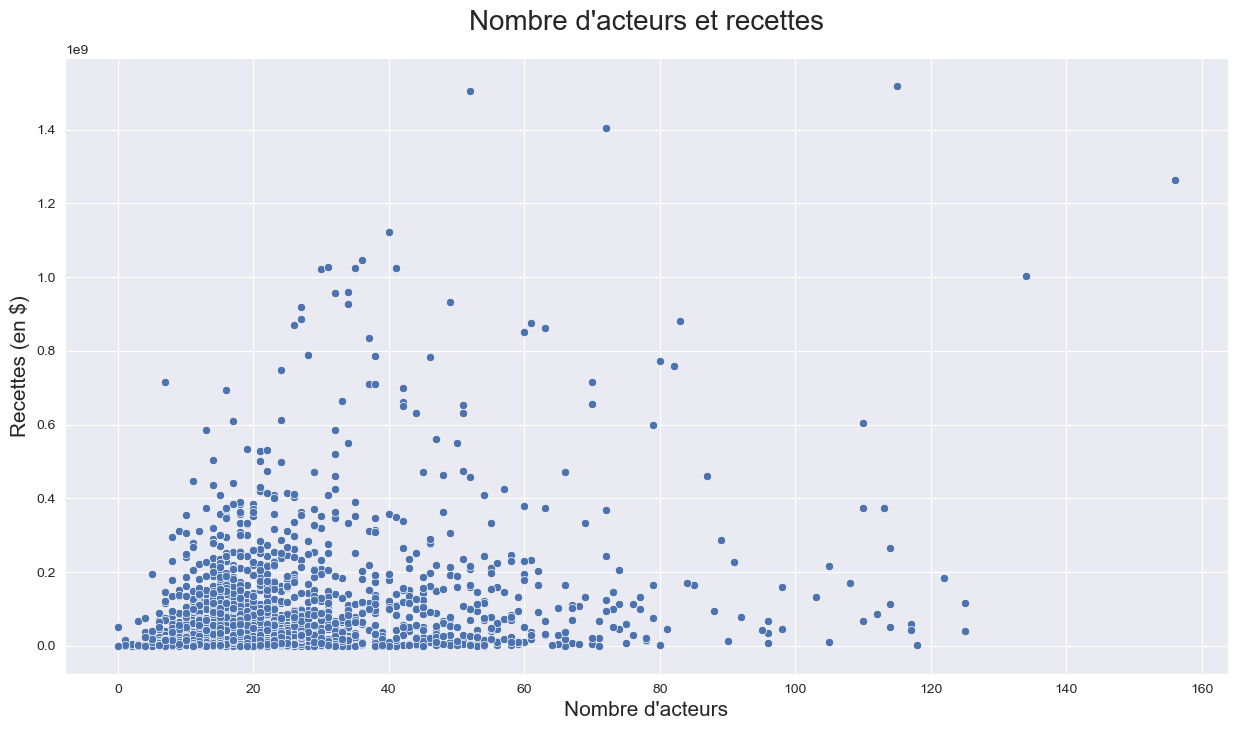

In [147]:
sns.scatterplot(data=movies_train, x="number_of_cast_members", y="revenue")
plt.title("Nombre d'acteurs et recettes", pad=20, size=20)
plt.xlabel("Nombre d'acteurs", size = 15)
plt.ylabel("Recettes (en $)", size = 15)
plt.show()
plt.close()

**Note**<br>
Il y a eu influence entre le nombre d'acteurs et le Box Office.<br>
Regardons plus en détail les résultats entre acteurs et actrices.

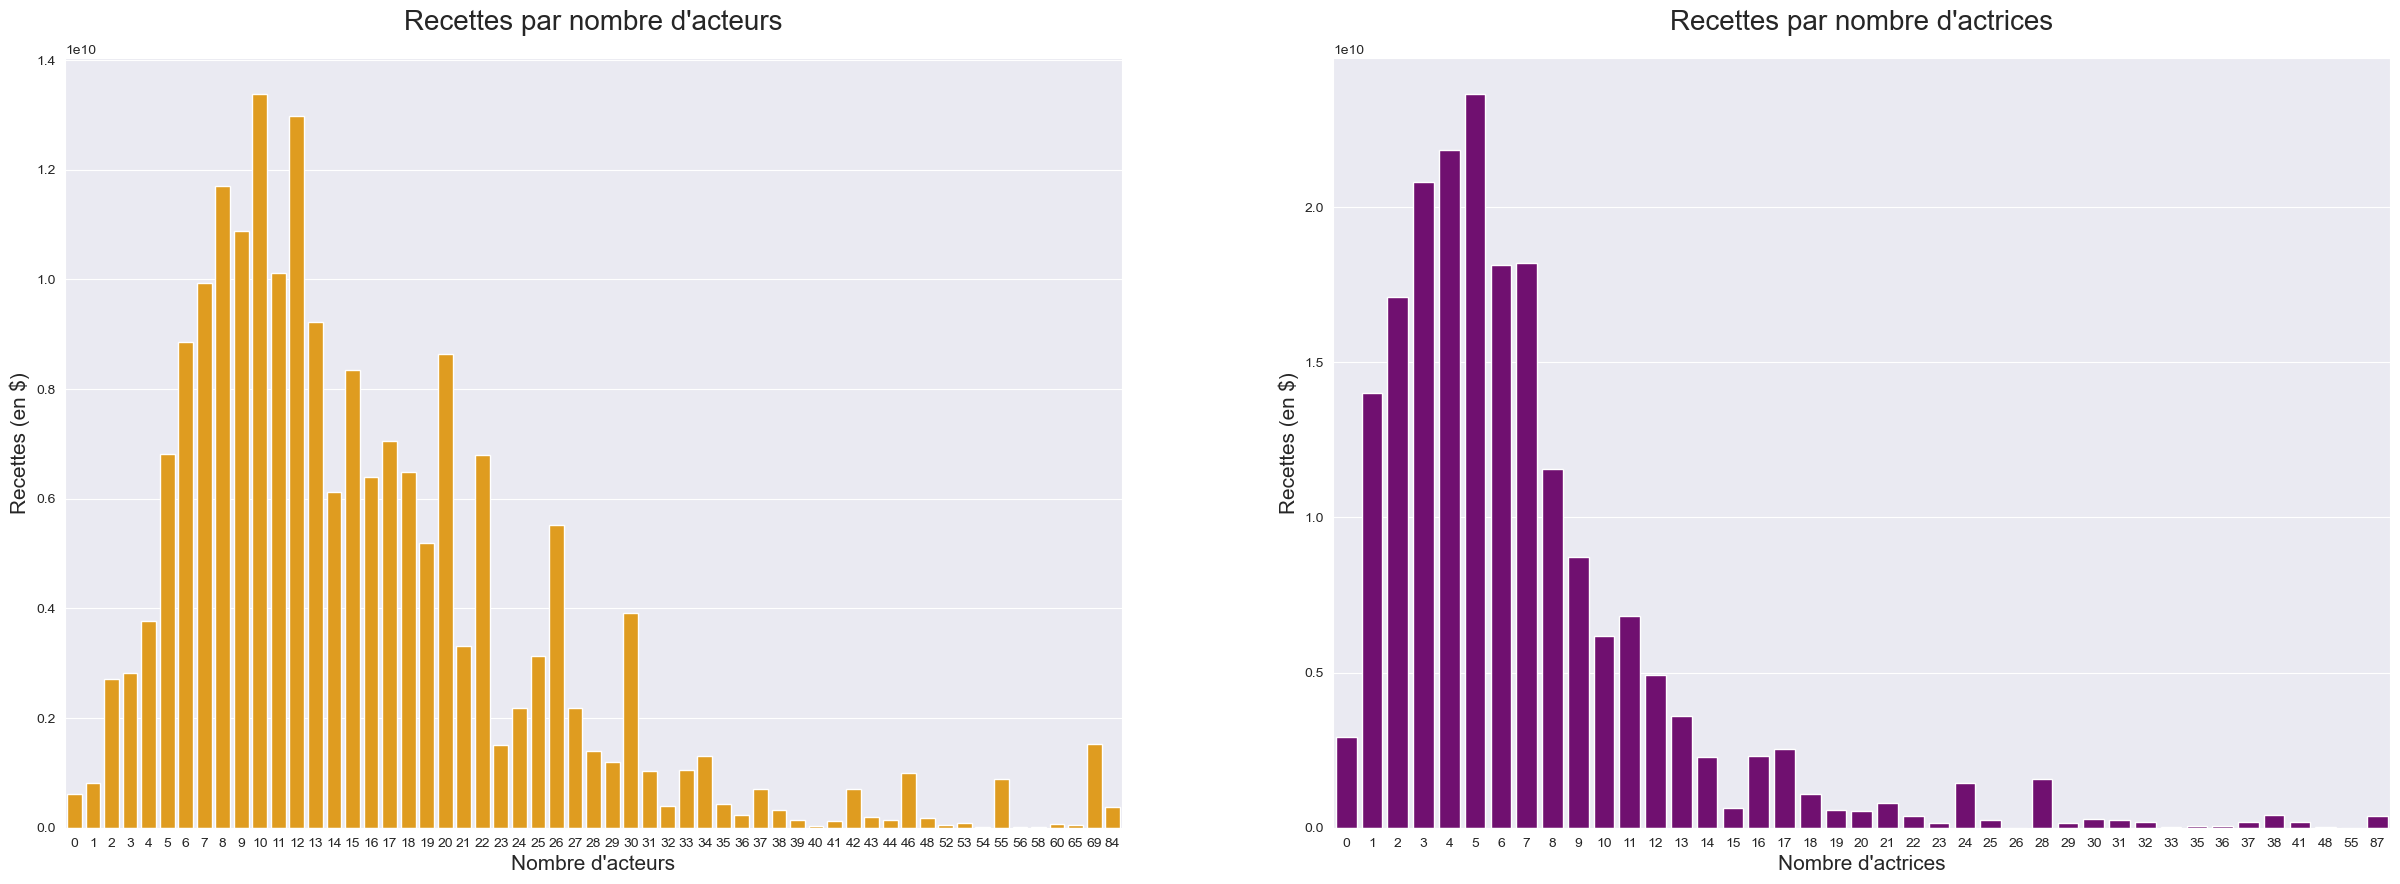

In [148]:
plt.figure(figsize=(30,10))

plt.subplot(1,2,1)
sns.barplot(data=movies_train, x="nb_actor", y="revenue", color="orange", estimator=sum, errorbar=None)
plt.title("Recettes par nombre d'acteurs", pad=20, size=20)
plt.xlabel("Nombre d'acteurs", size = 15)
plt.ylabel("Recettes (en $)", size = 15)

plt.subplot(1,2,2)
sns.barplot(data=movies_train, x="nb_actress", y="revenue", color="purple", estimator=sum, errorbar=None)
plt.title("Recettes par nombre d'actrices", pad=20, size=20)
plt.xlabel("Nombre d'actrices", size = 15)
plt.ylabel("Recettes (en $)", size = 15)

plt.show()
plt.close()

**Note**<br>
Il est difficile de faire parler ces 2 graphiques car on ne connaît pas la proportion de l'autre sexe dans chaque films : pour les films avec 5 actrices on a les recettes les plus élevés. Mais peut-être qu'il y a 20 acteurs en moyenne dans ces films.<br>
On observe que les hommes engrangent plus de recettes au total que les femmes.<br>
<hr>

Je regarde la répartition des hommes et femmes dans tous les films

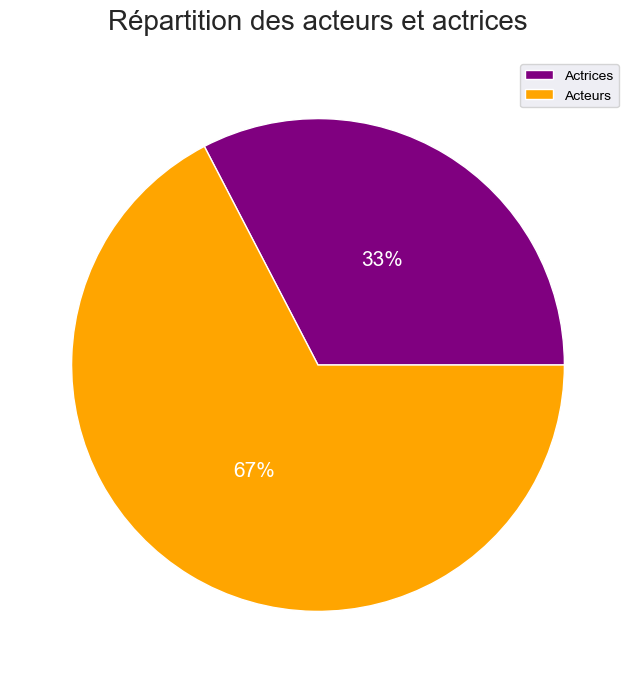

In [149]:
colors = ['purple',"orange"]
labels = ["Actrices","Acteurs"]
plt.pie(movies_train.agg({'nb_actress':'sum','nb_actor':'sum'}), 
        colors=colors, 
        startangle = 0, 
        pctdistance=0.5, 
        autopct='%1.f%%', 
        textprops={'color':"w", 'size':15}, 
        labeldistance =1)

plt.title("Répartition des acteurs et actrices", size=20, pad=20 )
plt.legend(labels, loc="best",labelcolor='black', frameon=True)
plt.show()
plt.close()

Je vais maintenant regarder ce qu'il se passe au niveau de la répartition des genres pour les 2 têtes d'affiche.

In [150]:
temp_genre_df=movies_train.query('actor_1_gender !=0 and actor_2_gender != 0')
temp_genre_df=temp_genre_df.groupby(["actor_1_gender", "actor_2_gender"]).agg(nombre_films=("title" , 'count'),box_office=("revenue","sum")).reset_index()
temp_genre_df

actor_1_gender  actor_2_gender  nombre_films   box_office
0               1               1           155   8792742014
1               1               2           450  29727969605
2               2               1           845  64667254421
3               2               2           964  83132406240

In [151]:
temp_genre_df["gender"]=""
for i in range(len(temp_genre_df)):
    if (temp_genre_df["actor_1_gender"][i]==1) & (temp_genre_df["actor_2_gender"][i]==1) == True:

        temp_genre_df.loc[i,"gender"] = "women"
    elif (temp_genre_df.actor_1_gender[i]==2) & (temp_genre_df.actor_2_gender[i]==2) == True:
        temp_genre_df.loc[i,"gender"] = "men"
    else :
        temp_genre_df.loc[i,"gender"] = "mixte"
    

In [152]:
temp_genre_df

actor_1_gender  actor_2_gender  nombre_films   box_office gender
0               1               1           155   8792742014  women
1               1               2           450  29727969605  mixte
2               2               1           845  64667254421  mixte
3               2               2           964  83132406240    men

Je modifie le dataframe pour pouvoir grouper les index 1 et 2.

In [153]:
temp_genre_df.loc[2,"actor_1_gender"]=1
temp_genre_df.loc[2,"actor_2_gender"]=2
temp_genre_df=temp_genre_df.groupby(["gender"]).agg({"nombre_films":'sum',"box_office":"sum"}).reset_index()
temp_genre_df

gender  nombre_films   box_office
0    men           964  83132406240
1  mixte          1295  94395224026
2  women           155   8792742014

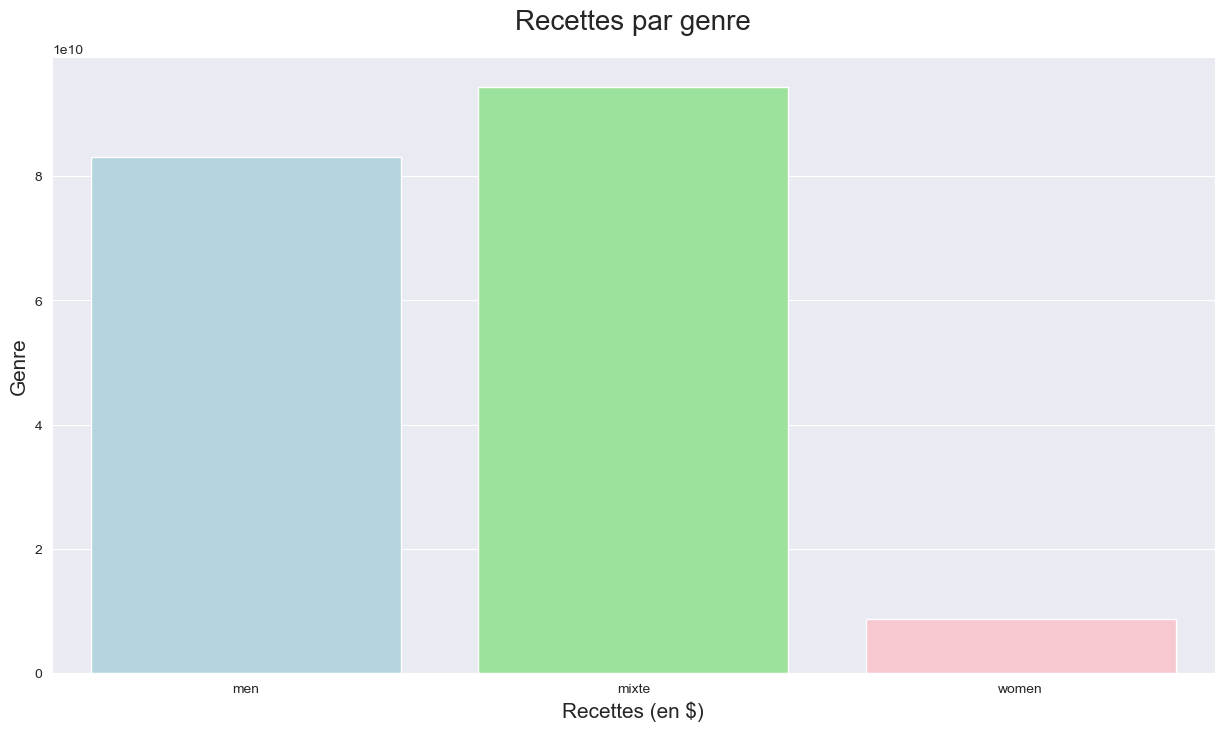

In [154]:
sns.barplot(data=temp_genre_df, x="gender", y="box_office", palette=["lightblue","lightgreen","pink"])
plt.xlabel("Recettes (en $)", size = 15)
plt.ylabel("Genre", size = 15)
plt.title("Recettes par genre", size = 20, pad=20)
plt.show()
plt.close()

In [155]:
temp_genre_df["moyenne_recettes"] = temp_genre_df.box_office/temp_genre_df.nombre_films
temp_genre_df

gender  nombre_films   box_office  moyenne_recettes
0    men           964  83132406240      8.623694e+07
1  mixte          1295  94395224026      7.289206e+07
2  women           155   8792742014      5.672737e+07

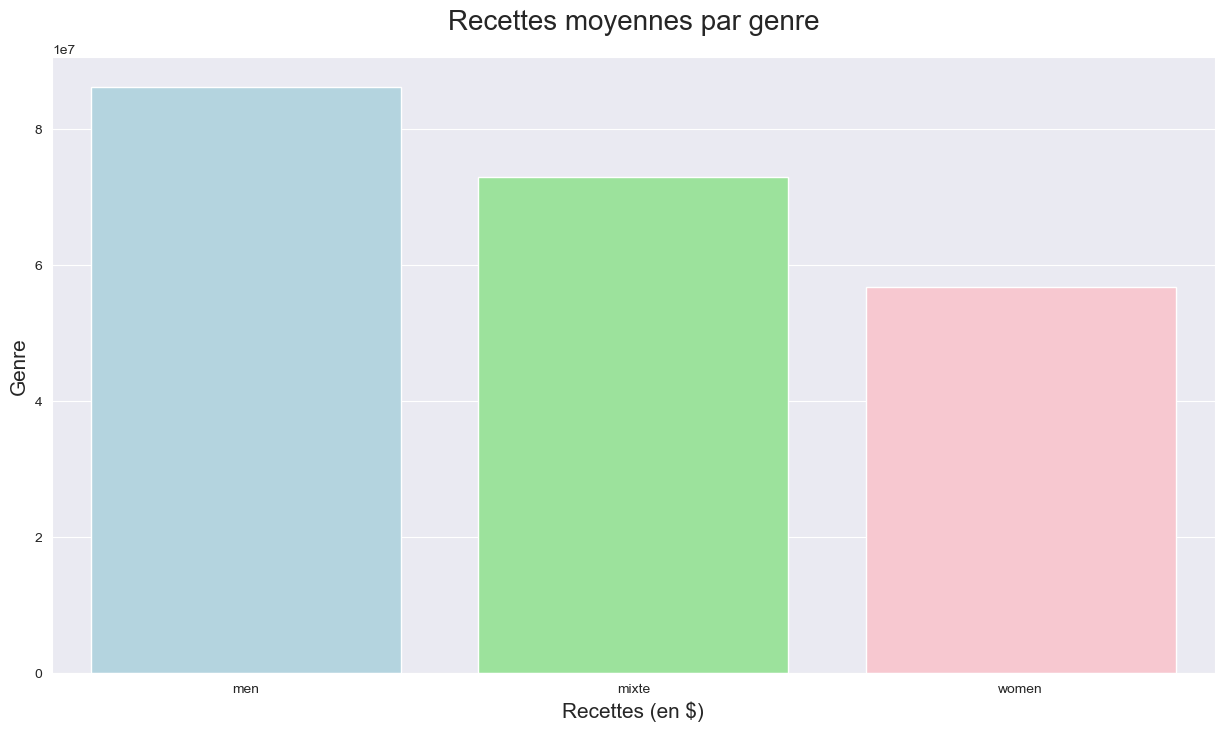

In [156]:
sns.barplot(data=temp_genre_df, x="gender", y="moyenne_recettes", palette=["lightblue","lightgreen","pink"])
plt.xlabel("Recettes (en $)", size = 15)
plt.ylabel("Genre", size = 15)
plt.title("Recettes moyennes par genre", size = 20, pad=20)
plt.show()
plt.close()

**Note**<br>
On voit que le genre a un impact sur le box-office : un film dont les 2 acteurs principaux sont des hommes fera plus d'entrées qu'un films avec 2 héroïnes, au total et en moyenne.<br>
Un film avec un homme et une femme en acteurs principaux reste ce qui fait le plus recette au total.

Je supprime les noms des acteurs ainsi que le nombre d'acteurs et actrices + la colonne originelle 'cast'

In [157]:
movies_train.drop(columns=["cast","actor_1", "actor_2", "nb_actor", "nb_actress"], inplace=True)
movies_test.drop(columns=["cast","actor_1", "actor_2", "nb_actor", "nb_actress"], inplace=True)

### crew

Les données présentes dans crew sont contenues dans un dictionnaire ou Json, comme pour 'genres'. Je récupère des données sur les réalisateurs.<br>
- Parse sur job : Director, puis récupération du 'name' et nombre de réalisateurs par films
- Nombre de réalisateurs par films


Je récupère le nom du réalisateur principal

In [158]:
for df in (movies_test, movies_train):
    df["director"]=""

for index, values in df.crew.items():
    #if index ==33:
    if df.crew.loc[index]!="[]":
        director=retrieve_person(values, "director")

        df.loc[df.index==index, "director"]=director
    else:
        df.loc[df.index==index, "director"]=""

Je récupère le nombre de réalisateurs

In [159]:
for df in (movies_test, movies_train):
    df["number_of_directors"]=""

    for index, values in df.crew.items():
        #if index ==33:
        if df.crew.loc[index]!="[]":
            num_director=retrieve_number_of_person(values, "director")

            df.loc[df.index==index, "number_of_directors"]=num_director
        else:
            df.loc[df.index==index, "number_of_directors"]=0

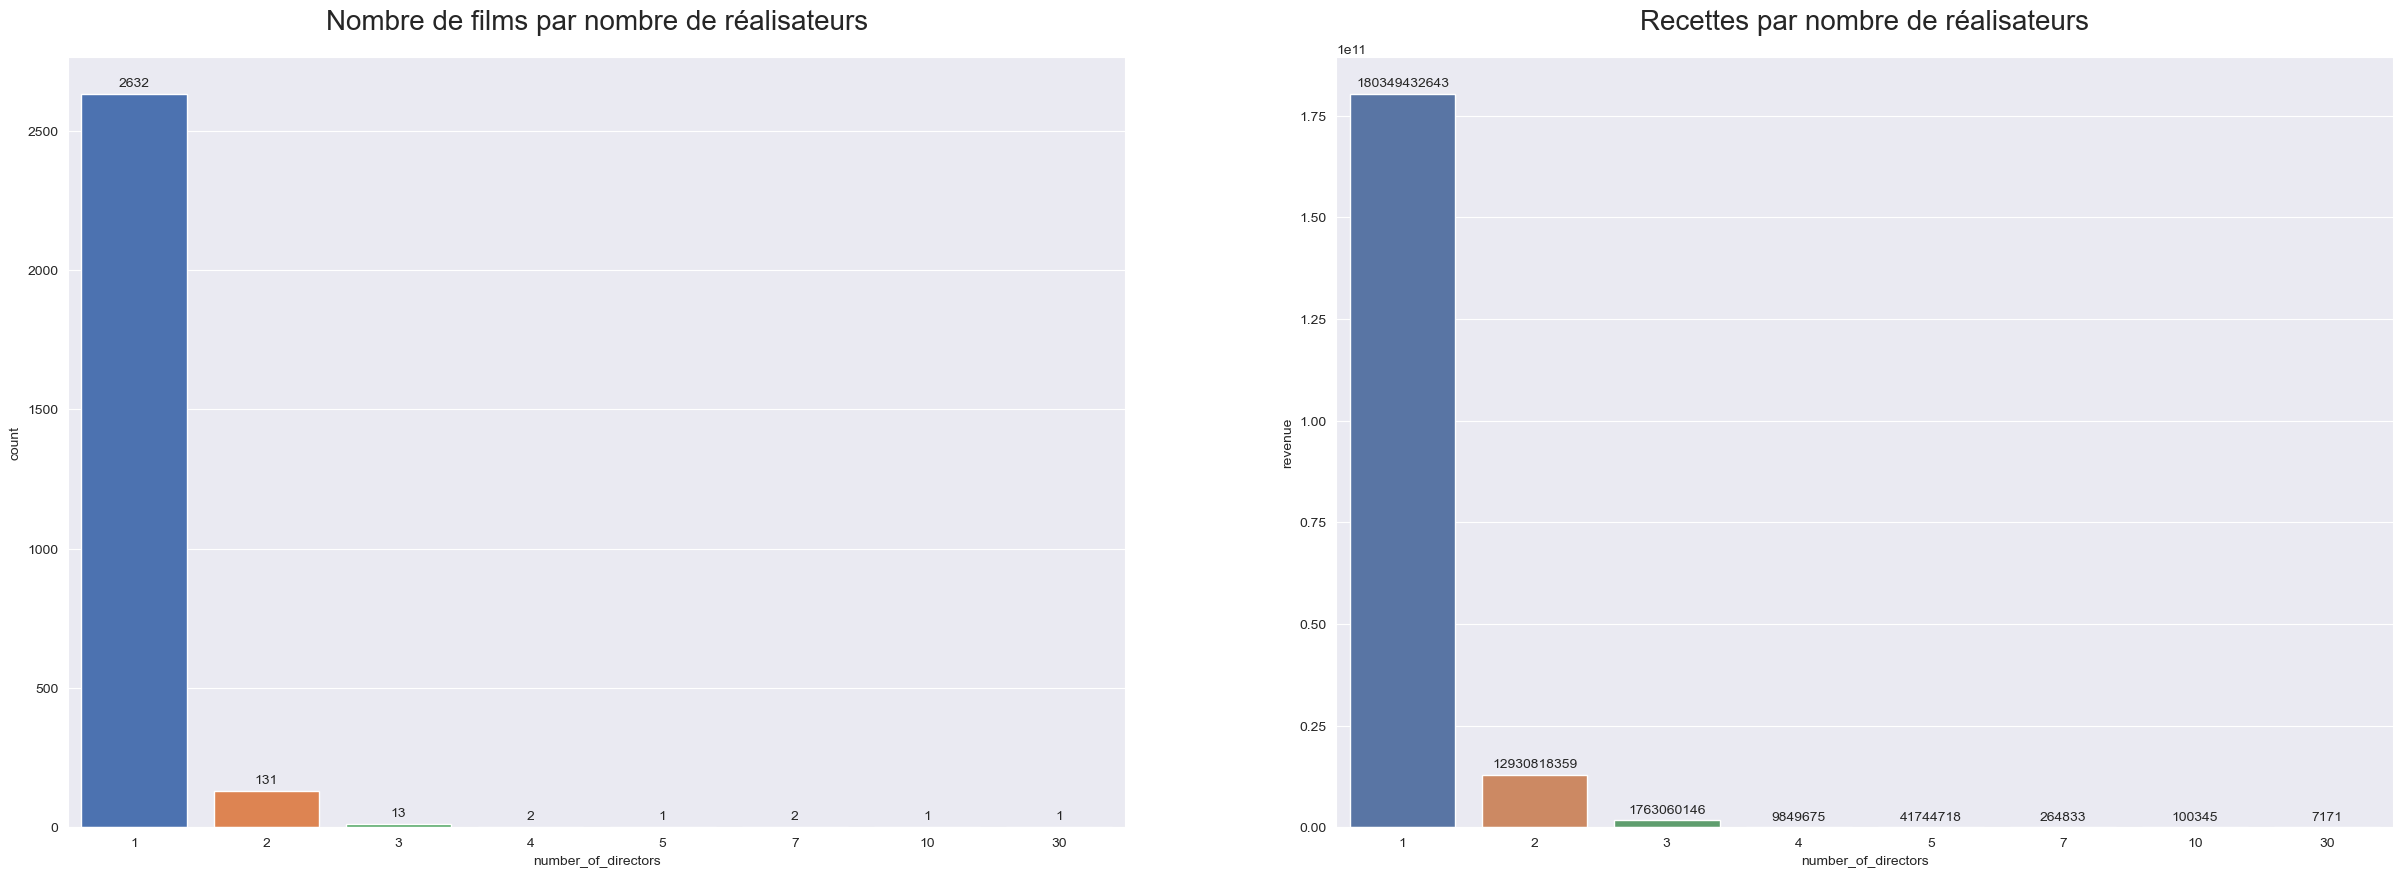

In [160]:
plt.figure(figsize=(30,10))

plt.subplot(1,2,1)
ax=sns.countplot(data=movies_train,x="number_of_directors", saturation=1)
ax.bar_label(ax.containers[0], padding=3)
plt.title("Nombre de films par nombre de réalisateurs", pad=20, size=20)

plt.subplot(1,2,2)
ax=sns.barplot(data=movies_train, x="number_of_directors", y="revenue", estimator=sum, errorbar=None)
ax.bar_label(ax.containers[0], fmt='%.0f', padding=3)
plt.title("Recettes par nombre de réalisateurs", pad=20, size=20)

plt.show()


In [161]:
temp_dir_df=movies_train.groupby("number_of_directors").agg(Total=('number_of_directors','count'), Recettes=('revenue','sum'))
temp_dir_df

Total      Recettes
number_of_directors                     
1                     2632  180349432643
2                      131   12930818359
3                       13    1763060146
4                        2       9849675
5                        1      41744718
7                        2        264833
10                       1        100345
30                       1          7171

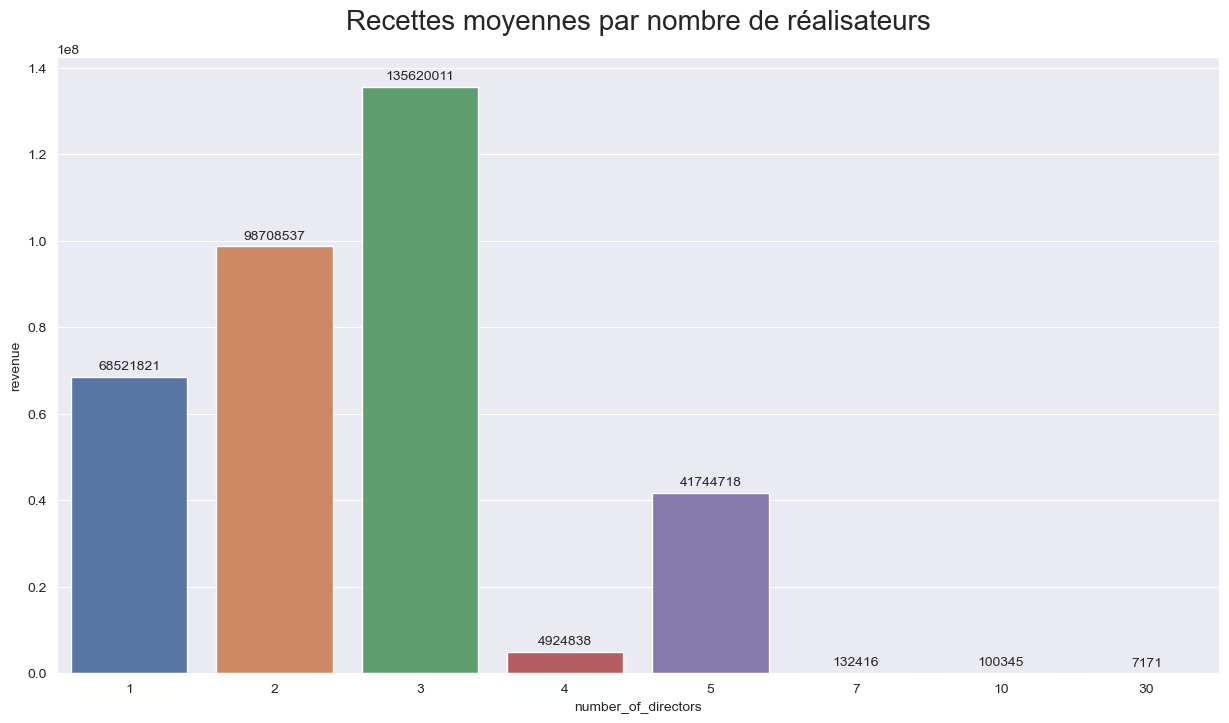

In [162]:
ax=sns.barplot(data=movies_train, x="number_of_directors", y="revenue", errorbar=None)
ax.bar_label(ax.containers[0], fmt='%.0f', padding=3)
plt.title("Recettes moyennes par nombre de réalisateurs", pad=20, size=20)
plt.show()


In [163]:
movies_train[movies_train.number_of_directors==3][["title","revenue"]].sort_values("revenue",ascending=False)

title     revenue
734                                Zootopia  1023784195
1407                    The Prince of Egypt   218613188
2631                            Cloud Atlas   130482868
1570                     Lady and the Tramp    93600000
1169                              Peter Pan    87404651
2665                        Ruthless People    71624879
2346                        The Longest Day    50100000
2306  Evangelion: 2.0 You Can (Not) Advance    41162041
898                         Everyone's Hero    16627188
1845                              Kickboxer    14697005
2151                         The Pagemaster    13670688
1718                        Boris - Il film     1248748
2590         Requiem for the American Dream       44695

**Note**<br>
Même si la moyenne de recettes est plus élevée pour 3 réalisateurs, grâce notamment à "Zootopia", on ne peut pas dire que le nombre de réalisateurs a une influence sur le B-O.<br>
La courbe de recette vs. celle du nombre de films est la même 👉🏼 **Je supprime les colonnes réalisateurs**.

Je supprime maintenant la colonne crew + celles qui ne m'intéressent pas.

In [164]:
movies_train.drop(columns=["crew","number_of_directors", "director"], inplace=True)
movies_test.drop(columns=["crew","number_of_directors", "director"], inplace=True)

### status
Cette colonne ne sert à rien, tous les statuts sont maintenant "released"

In [165]:
movies_train.drop(columns="status", inplace=True)
movies_test.drop(columns="status", inplace=True)

### tagline
Je vais utiliser le workcloud pour visualiser les mots.<br>
*Installation : conda install -c https://conda.anaconda.org/conda-forge wordcloud*

Je télécharge une liste de mots à exclure dans la langue de mes données (anglais) : https://countwordsfree.com/stopwords/<br>
Je transforme mon dataframe en une liste de mot.

In [166]:
own_stopwords = pd.read_json("stop_words_english.json")

own_stopwords_list=[]
for i in own_stopwords[0]:
    own_stopwords_list.append(i)

Récupération du masque pour la forme de mon nuage

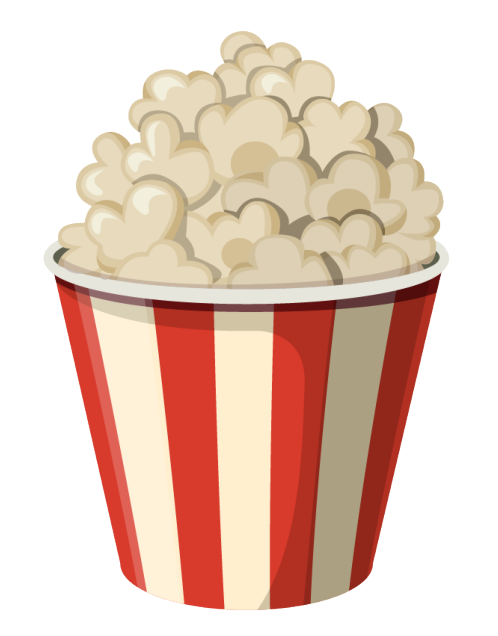

In [167]:
mask = np.array(Image.open("popcorn_mask.png"))
plt.imshow(mask)
plt.axis("off")
plt.show()
plt.close()

Je contruis un "text" contenant toutes les taglines à la suite.<br>
J'affiche mon nuage de mots avec la forme du masque chargé.

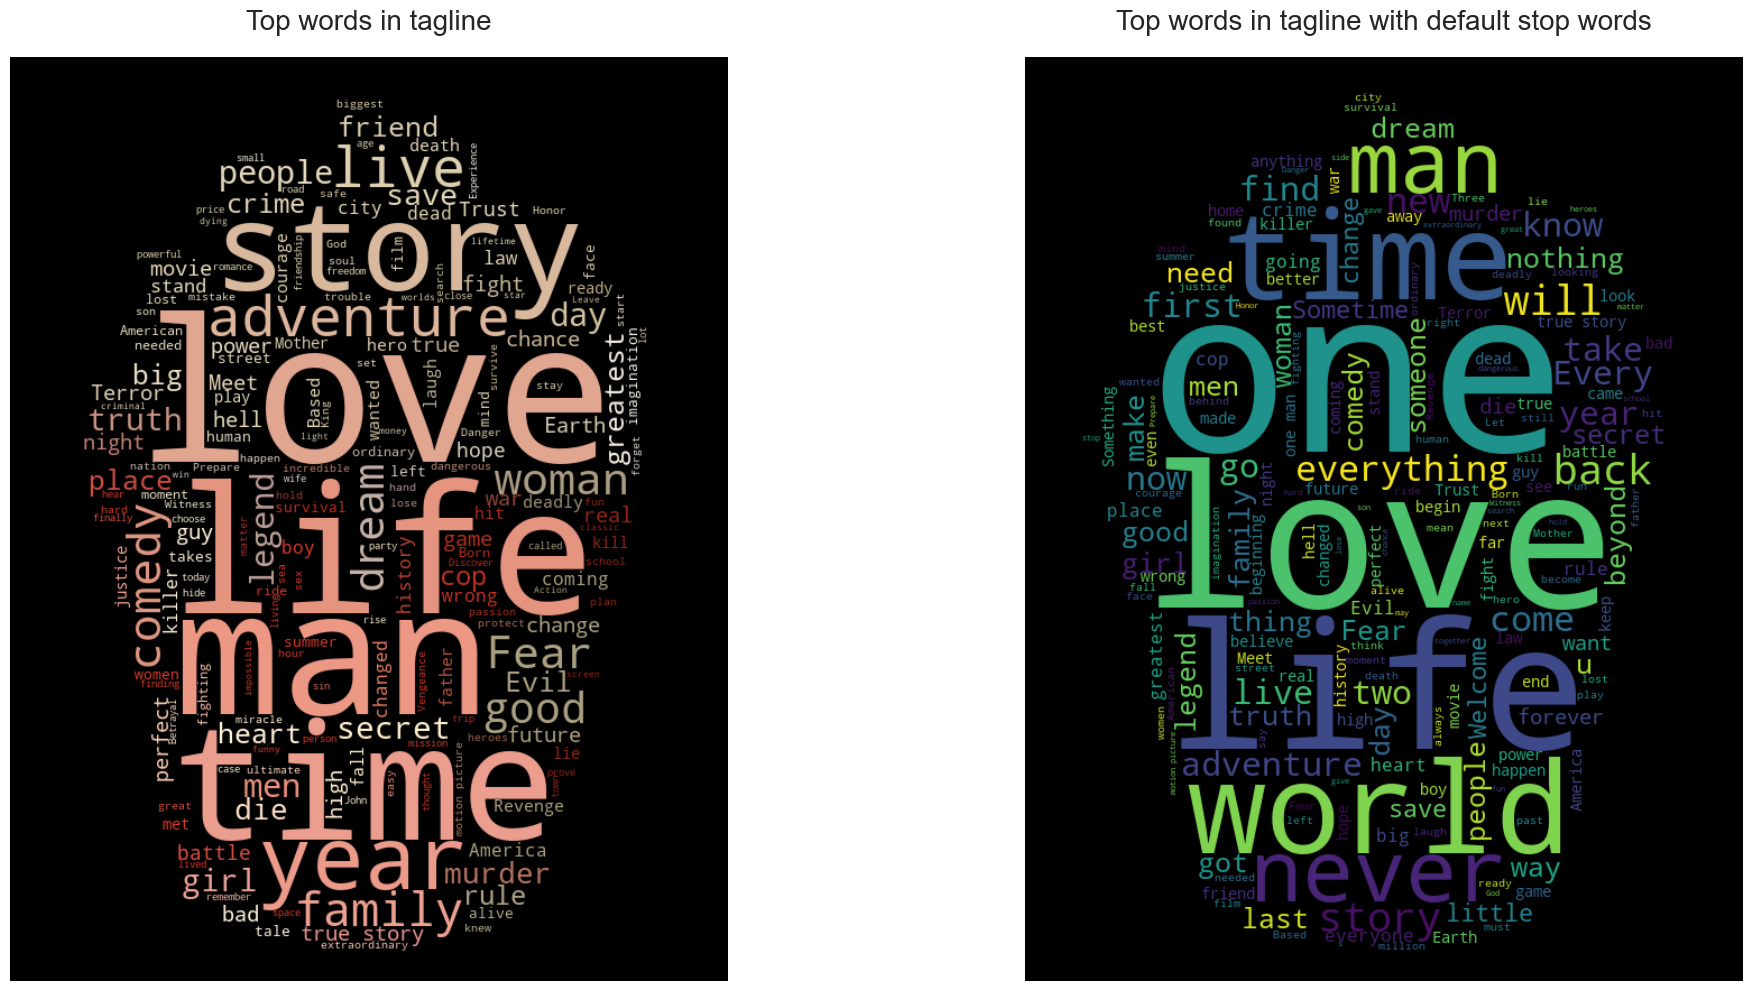

In [168]:
text = ' '.join(movies_train['tagline'].fillna('').values)

fig, ax = plt.subplots(1, 2, figsize=(24, 12))

#J'ajoute mes mots à exclure à la liste par défaut (STOPWORDS)
plt.subplot(1,2,1)

stopwords_newlist = own_stopwords_list + list(STOPWORDS)  

wordcloud = WordCloud(stopwords=stopwords_newlist, background_color="black", width=1280, height=720, mask=mask, random_state=42 )
wordcloud.generate((text))

image_colors = ImageColorGenerator(mask)

plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.title('Top words in tagline', size=20, pad=20)
plt.axis("off")

# Avec uniquement les mots à exclure par défaut 
plt.subplot(1,2,2)

wordcloud = WordCloud(stopwords=None, max_font_size=None, background_color='black', width=1280, height=720, colormap="viridis",random_state=42,mask = mask).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top words in tagline with default stop words', size=20, pad=20)
plt.axis("off")


plt.show()
plt.close()

**Note**<br>
Les mots les plus représentés dans les taglines des films sont apparentés au champ lexical de la comédie romantique ou comédie dramatique.<br>
Comme nous avons déjà récupéré le genre des films, on peut supprimer cette colonne.

In [169]:
movies_train.drop(columns="tagline", inplace=True)
movies_test.drop(columns="tagline", inplace=True)

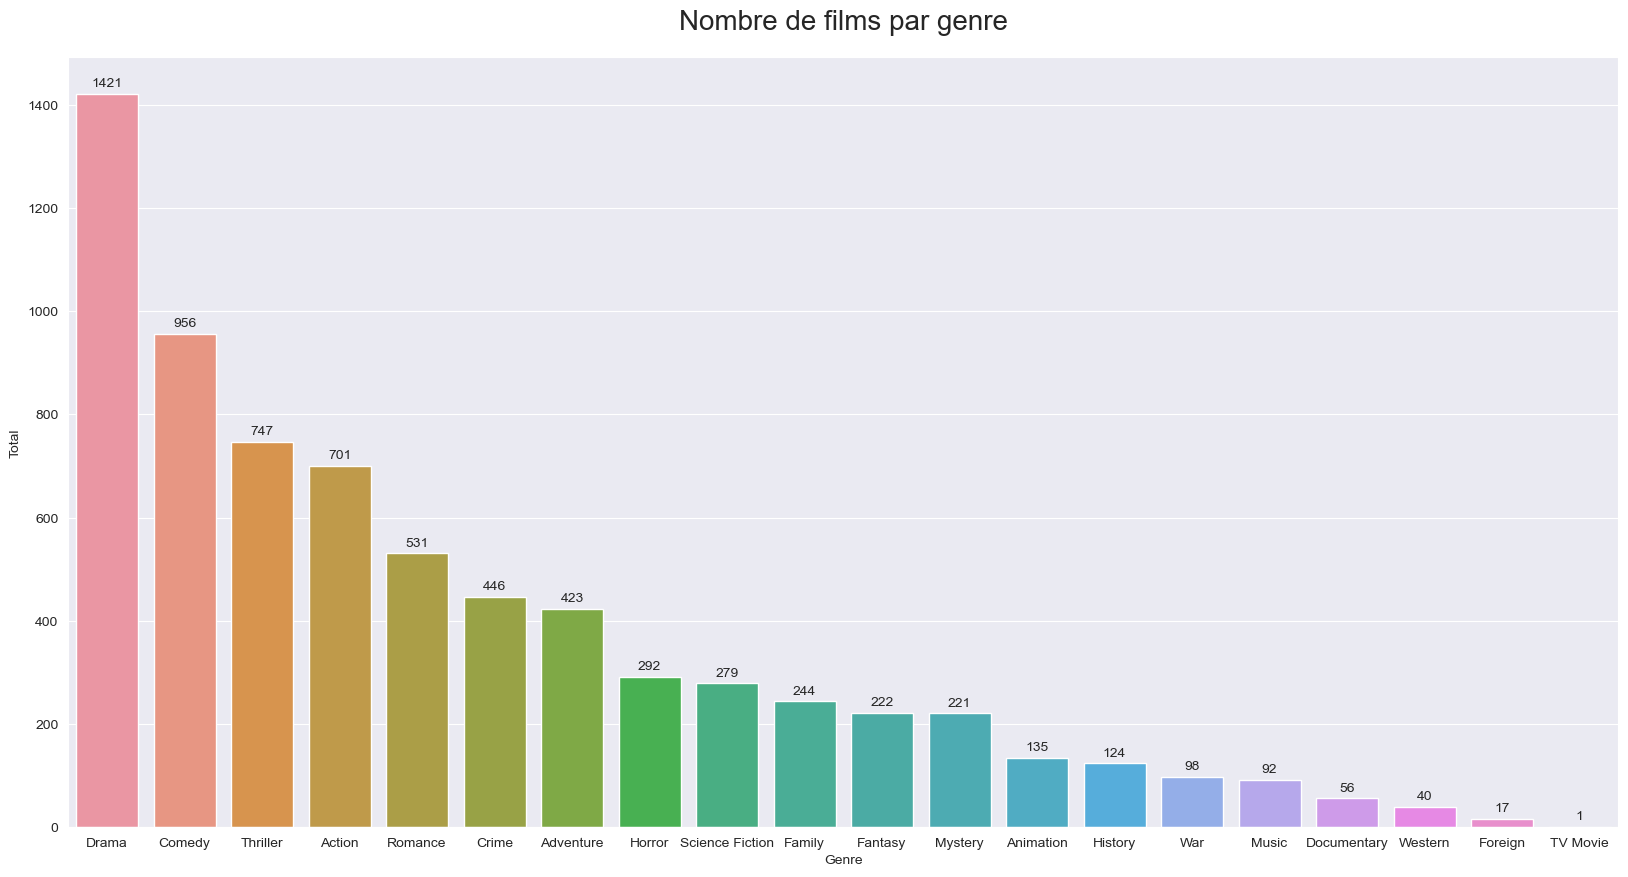

In [170]:
plt.figure(figsize=(20,10))
ax=sns.barplot(data=info_genre_df.sort_values("Total", ascending=False), x="Genre", y="Total")
ax.bar_label(ax.containers[0], fmt='%.0f', padding=3)
plt.title("Nombre de films par genre", size=20, pad=20)
plt.show()
    

**Note**<br>
C'est le drame qui est le plus représenté, puis la comédie. Ce qui peut corroborer l'intuition sur les mots dans les taglines.

## Sauvegarde des fichiers

In [171]:
end_train_obs = movies_train.shape[0]
end_train_var=movies_train.shape[1]
end_test_obs = movies_test.shape[0]
end_test_var=movies_test.shape[1]

print (f"""Au départ, nous avions un jeu d'entraînement de {train_obs} films et {train_var} variables
et un jeu de test de {test_obs} films et {test_var} variables.

Après les diverses modifications, nous avons un jeu d'entraînement de {end_train_obs} films et {end_train_var} variables
et un jeu de test de {end_test_obs} films et {end_test_var} variables.
""")

Au départ, nous avions un jeu d'entraînement de 3000 films et 23 variables
et un jeu de test de 4398 films et 22 variables.

Après les diverses modifications, nous avons un jeu d'entraînement de 2783 films et 35 variables
et un jeu de test de 4115 films et 33 variables.



Je vérifie que tous les types sont bien des entiers.

In [172]:
movies_train.dtypes

is_collection               int64
budget                      int64
popularity                float64
runtime                     int64
title                      object
revenue                     int64
count_genres               object
genre_Comedy                int64
genre_Drama                 int64
genre_Family                int64
genre_Romance               int64
genre_Horror                int64
genre_Thriller              int64
genre_Action                int64
genre_Music                 int64
genre_Adventure             int64
genre_Crime                 int64
genre_Science Fiction       int64
genre_Mystery               int64
genre_Foreign               int64
genre_Animation             int64
genre_Fantasy               int64
genre_War                   int64
genre_Western               int64
genre_Documentary           int64
genre_History               int64
genre_TV Movie              int64
english_language            int64
count_prod_companies        int64
count_prod_cou

In [173]:
movies_train[["number_of_cast_members", "count_genres", "actor_2_gender","actor_1_gender"]]=movies_train[["number_of_cast_members","count_genres","actor_2_gender","actor_1_gender"]].astype(int)

In [174]:
movies_test.dtypes

is_collection               int64
budget                      int64
popularity                float64
runtime                     int64
title                      object
count_genres               object
genre_Horror                int64
genre_Science Fiction       int64
genre_Comedy                int64
genre_Romance               int64
genre_Drama                 int64
genre_War                   int64
genre_Mystery               int64
genre_Animation             int64
genre_Family                int64
genre_Thriller              int64
genre_Action                int64
genre_Adventure             int64
genre_Music                 int64
genre_Crime                 int64
genre_Fantasy               int64
genre_Western               int64
genre_Documentary           int64
genre_History               int64
genre_Foreign               int64
english_language            int64
count_prod_companies        int64
count_prod_countries        int64
release_month               int64
release_week_o

In [175]:
movies_test[["number_of_cast_members", "count_genres", "actor_2_gender","actor_1_gender"]]=movies_test[["number_of_cast_members","count_genres","actor_2_gender","actor_1_gender"]].astype(int)

Je classe les colonnes par ordre alphabétique inversé pour avoir le titre en premier.<br>
Je bouge la colonne "revenue" en dernière position.

In [176]:
movies_train=movies_train.sort_index(axis = 1, ascending = False)
revenue_col=movies_train.pop("revenue")
num_of_col=movies_train.shape[1]
movies_train.insert(num_of_col,"revenue",revenue_col)
movies_train.head(2)

title  runtime  release_week_of_year  \
0                    Hot Tub Time Machine 2       93                     8   
1  The Princess Diaries 2: Royal Engagement      113                    32   

   release_month  popularity  number_of_cast_members  is_collection  \
0              2    6.575393                      24              1   
1              8    8.248895                      20              1   

   genre_Western  genre_War  genre_Thriller  genre_TV Movie  \
0              0          0               0               0   
1              0          0               0               0   

   genre_Science Fiction  genre_Romance  genre_Mystery  genre_Music  \
0                      0              0              0            0   
1                      0              1              0            0   

   genre_Horror  genre_History  genre_Foreign  genre_Fantasy  genre_Family  \
0             0              0              0              0             0   
1             0              0              0              0             1   

   genre_Drama  genre_Documentary  genre_Crime  genre_Comedy  genre_Animation  \
0            0                  0            0             1                0   
1            1                  0            0             1                0   

   genre_Adventure  genre_Action  english_language  count_prod_countries  \
0                0             0                 1                     1   
1                0             0                 1                     1   

   count_prod_companies  count_genres    budget  actor_2_gender  \
0                     3             1  14000000               2   
1                     1             4  40000000               1   

   actor_1_gender   revenue  
0               2  12314651  
1               1  95149435

In [177]:
movies_test=movies_test.sort_index(axis = 1, ascending = False)
movies_test.head(2)

title  runtime  release_week_of_year  release_month  \
1  Attack of the 50 Foot Woman       65                    20              5   
2             Addicted to Love      100                    21              5   

   popularity  number_of_cast_members  is_collection  genre_Western  \
1    3.559789                      10              0              0   
2    8.085194                       9              0              0   

   genre_War  genre_Thriller  genre_Science Fiction  genre_Romance  \
1          0               0                      1              0   
2          0               0                      0              1   

   genre_Mystery  genre_Music  genre_Horror  genre_History  genre_Foreign  \
1              0            0             1              0              0   
2              0            0             0              0              0   

   genre_Fantasy  genre_Family  genre_Drama  genre_Documentary  genre_Crime  \
1              0             0            0                  0            0   
2              0             0            0                  0            0   

   genre_Comedy  genre_Animation  genre_Adventure  genre_Action  \
1             0                0                0             0   
2             1                0                0             0   

   english_language  count_prod_countries  count_prod_companies  count_genres  \
1                 1                     1                     1             2   
2                 1                     1                     3             2   

     budget  actor_2_gender  actor_1_gender  
1     88000               0               1  
2  18000000               2               1

Je regarde s'il y a la même structure entre les 2 jeux de données.

In [178]:
col_train=movies_train.columns
col_test=movies_test.columns

col_test_diff=col_test.difference(col_train)
col_train_diff=col_train.difference(col_test)

if col_test_diff.shape[0] == 0:
    print(f"Il n'y a pas de colonnes présentes dans movies_test et non présentes dans movies_train.")
elif col_test_diff.shape[0] == 1:
    print(f"La colonne  '{col_test_diff[0]}' est présente dans movies_test et pas dans movies_train.")
else:
    print(f"Les colonnes {col_test_diff.array.tolist()} sont présentes dans movies_test et non présente dans movies_traib.")

print()  

if col_train_diff.shape[0] == 0:
    print(f"Il n'y a pas de colonnes présentes dans movies_train et non présentes dans movies_test.")
elif col_train_diff.shape[0] == 1:
    print(f"La colonne '{col_train_diff[0]}' est présente dans movies_train et pas dans movies_test.")
else:    
    print(f"Les colonnes '{', '.join(col_train_diff[i] for i in range(0,col_train_diff.shape[0]))}' sont présentes dans movies_train et non présente dans movies_test.")

Il n'y a pas de colonnes présentes dans movies_test et non présentes dans movies_train.

Les colonnes 'genre_TV Movie, revenue' sont présentes dans movies_train et non présente dans movies_test.


**Observation**<br>
Il n'y a qu'un film de type TV Movie et il n'y en a aucun dans le jeu de test.<br>
Comme chaque genre est une colonne et qu'on doit avoir la même structure entre notre jeu d'entraînement et de test, je rajoute une colonne TV Movie dans le test en remplissant avec des 0.

In [179]:
movies_test["genre_TV Movie"] = 0

Vérification

In [180]:
movies_test=movies_test.sort_index(axis = 1, ascending = False)
movies_test.head(2)

title  runtime  release_week_of_year  release_month  \
1  Attack of the 50 Foot Woman       65                    20              5   
2             Addicted to Love      100                    21              5   

   popularity  number_of_cast_members  is_collection  genre_Western  \
1    3.559789                      10              0              0   
2    8.085194                       9              0              0   

   genre_War  genre_Thriller  genre_TV Movie  genre_Science Fiction  \
1          0               0               0                      1   
2          0               0               0                      0   

   genre_Romance  genre_Mystery  genre_Music  genre_Horror  genre_History  \
1              0              0            0             1              0   
2              1              0            0             0              0   

   genre_Foreign  genre_Fantasy  genre_Family  genre_Drama  genre_Documentary  \
1              0              0             0            0                  0   
2              0              0             0            0                  0   

   genre_Crime  genre_Comedy  genre_Animation  genre_Adventure  genre_Action  \
1            0             0                0                0             0   
2            0             1                0                0             0   

   english_language  count_prod_countries  count_prod_companies  count_genres  \
1                 1                     1                     1             2   
2                 1                     1                     3             2   

     budget  actor_2_gender  actor_1_gender  
1     88000               0               1  
2  18000000               2               1

In [181]:
movies_train.to_excel("movies_train.xlsx")
movies_test.to_excel("movies_test.xlsx")

# Data Preprocessing
Je prépare mes données pour les optimiser. L'encodage et l'imputation ont déjà été réalisés.<br>
Je vais standardiser certaines données quantitatives en fonction du besoin.<br>
Comme on est sur une régression on n'est pas "obligé" de centrer réduire les données, mais si on veut faire tourner un Ridge ou Lasso qui donne de l'importance aux coefficients, on devrait le faire sur certaines variables quantitatives.<br>
J'utiliserai des transformeurs quand ce sera nécessaire.

# Préparation du modèle - Features Selection

Je commence par tester la prédiction sur une sélection de colonnes.

Je regarde la corrélation de mes variables

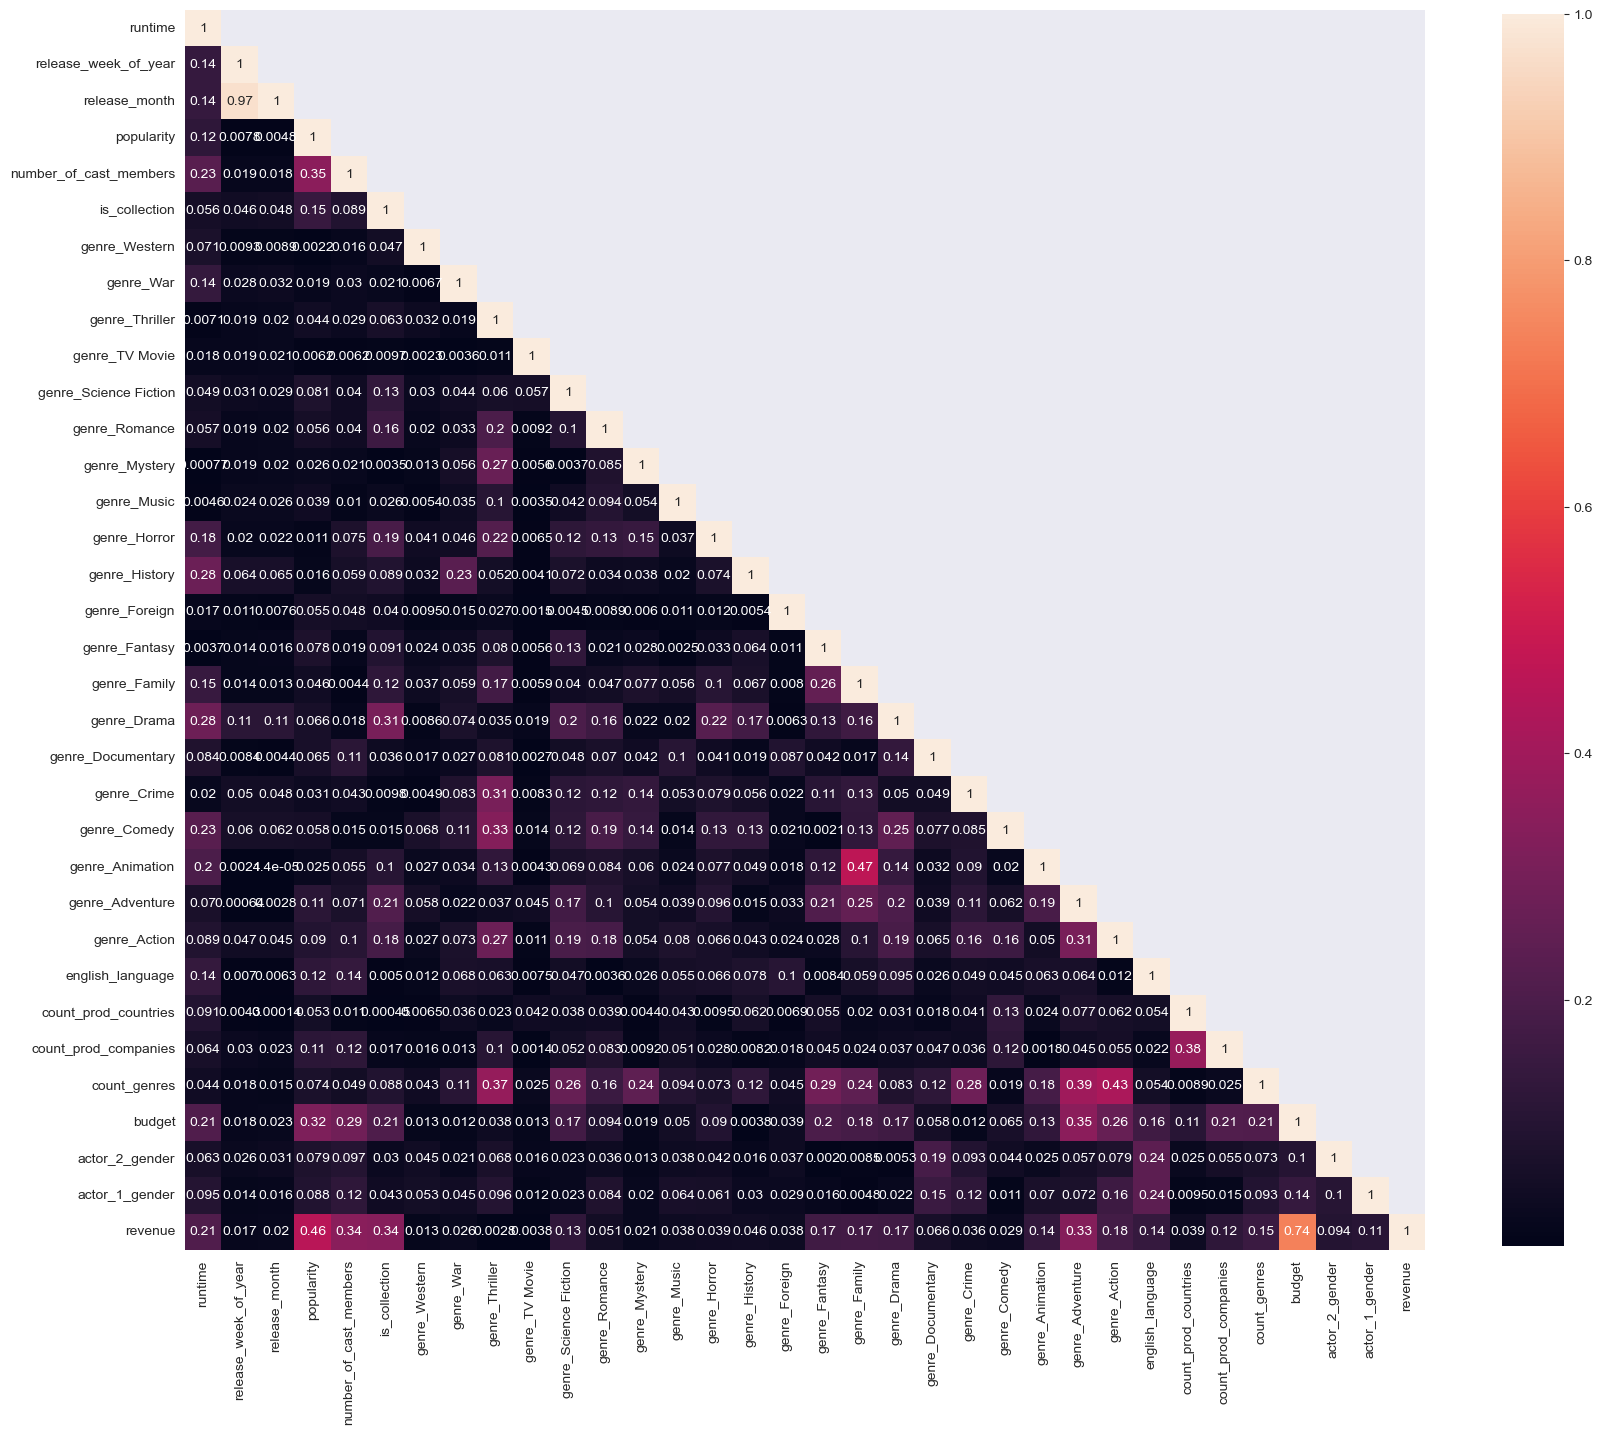

In [182]:
plt.figure(figsize=(20, 20))
corr_matrix = movies_train.corr().abs()
mask = np.triu(np.ones_like(corr_matrix,dtype=bool),k=1)
sns.heatmap(corr_matrix, mask=mask, square=True, annot=True, cbar=True, cbar_kws={"shrink": .80} )
plt.show()

## Echantillonnage

In [183]:
X_train, X_test, y_train, y_test = data_sampling()

Le jeu de données d'entraînement contient 2226 lignes.
Le jeu de test en contient 557.


In [184]:
X_train.var(axis=0).sort_values(ascending=False)

budget                    1.312530e+15
runtime                   4.312051e+02
number_of_cast_members    2.806339e+02
release_week_of_year      2.192043e+02
popularity                1.453574e+02
release_month             1.158233e+01
count_prod_companies      3.709320e+00
count_genres              1.230609e+00
count_prod_countries      5.381039e-01
actor_2_gender            4.352324e-01
actor_1_gender            3.668934e-01
genre_Drama               2.500833e-01
genre_Comedy              2.256610e-01
genre_Thriller            1.946744e-01
genre_Action              1.892583e-01
is_collection             1.653321e-01
genre_Romance             1.573003e-01
genre_Crime               1.325701e-01
genre_Adventure           1.297808e-01
english_language          1.100134e-01
genre_Horror              9.411309e-02
genre_Science Fiction     8.982465e-02
genre_Family              8.144260e-02
genre_Fantasy             7.510989e-02
genre_Mystery             7.360288e-02
genre_Animation          

## Sélecteur : variance
VarianceThreshold élimine les variables dont la variance est inférieure au seuil défini.

Je garde les variables dont la variance est supérieure à un certain seuil.

In [185]:
selector = VarianceThreshold(threshold=1)
selector.fit_transform(X_train)
features_selected_var = np.array(X_train.columns)[selector.get_support()]
features_selected_var

array(['runtime', 'release_week_of_year', 'release_month', 'popularity',
       'number_of_cast_members', 'count_prod_companies', 'count_genres',
       'budget'], dtype=object)

In [186]:
X_train=X_train.loc[:,features_selected_var]
X_test= X_test.loc[:,features_selected_var]

### Choix de l'estimateur
Je teste plusieurs estimateurs avec des transformeurs différents.

In [256]:
LassoReg_std_scl = make_pipeline(make_column_transformer((StandardScaler(), ["budget", "runtime", "popularity"])), Lasso(random_state=42))
LassoReg_robust_scl = make_pipeline(make_column_transformer((RobustScaler(), ["budget", "runtime", "popularity"])), Lasso(random_state=42))
LassoReg_min_max_scl = make_pipeline(make_column_transformer((MinMaxScaler(), ["budget", "runtime", "popularity"])), Lasso(random_state=42))
LassoReg_max_abs_scl = make_pipeline(make_column_transformer((MaxAbsScaler(), ["budget", "runtime", "popularity"])), Lasso(random_state=42))
LassoReg = make_pipeline(StandardScaler(),Lasso(random_state=42))
ElasticNet_std_scl = make_pipeline(make_column_transformer((StandardScaler(), ["budget", "runtime", "popularity"])), ElasticNet(random_state=42))
ElasticNet_robust_scl = make_pipeline(make_column_transformer((RobustScaler(), ["budget", "runtime", "popularity"])), ElasticNet(random_state=42))
ElasticNet_min_max_scl = make_pipeline(make_column_transformer((MinMaxScaler(), ["budget", "runtime", "popularity"])), ElasticNet(random_state=42))
ElasticNet_max_abs_scl = make_pipeline(make_column_transformer((MaxAbsScaler(), ["budget", "runtime", "popularity"])), ElasticNet(random_state=42))
ElasticNetReg = make_pipeline(StandardScaler(),ElasticNet(random_state=42))

Je créé un dictionnaire de mes modèles pour pouvoir itérer dessus et choisir le meilleur.

In [257]:
dict_of_models = {
    'LassoReg_std_scl':LassoReg_std_scl,
    'LassoReg_robust_scl' : LassoReg_robust_scl,
    'LassoReg_min_max_scl':LassoReg_min_max_scl,
    'LassoReg_max_abs_scl' : LassoReg_max_abs_scl,
    'LassoReg':LassoReg ,
    'ElasticNet_std_scl':ElasticNet_std_scl,
    'ElasticNet_robust_scl' :ElasticNet_robust_scl,
    'ElasticNet_min_max_scl' :ElasticNet_min_max_scl,
    'ElasticNet_max_abs_scl' :ElasticNet_max_abs_scl,
    'ElasticNetReg' :ElasticNetReg
}

In [258]:
select_best_model(dict_of_models)

LassoReg_std_scl : r2_score =  0.52
LassoReg_robust_scl : r2_score =  0.52
LassoReg_min_max_scl : r2_score =  0.52
LassoReg_max_abs_scl : r2_score =  0.52
LassoReg : r2_score =  0.52
ElasticNet_std_scl : r2_score =  0.47
ElasticNet_robust_scl : r2_score =  0.51
ElasticNet_min_max_scl : r2_score =  0.02
ElasticNet_max_abs_scl : r2_score =  0.02
ElasticNetReg : r2_score =  0.47

Le meilleur modèle est LassoReg_robust_scl.


Je pars donc sur le modèle Lasso, le transformeur n'a pas d'importance, que je vais tenter d'optimiser pour avoir un meilleur résultat.
Le principe de Lasso est de faire de la sélection de variable en abaissant les coefficients attribués à chaque variable explicative. Plus le paramètre alpha est élevé, plus les coeffcients tendent vers 0.
La difficulté réside dans l'optimisation du paramètre alpha :

- un alpha trop faible peut entrainer un sur apprentissage
- un alpha trop fort peut entrainer un sous apprentissage


### Apprentissage

In [261]:
transformer = make_column_transformer((RobustScaler(), ["budget", "runtime", "popularity"]))

In [262]:
parameters = {
    'lasso__alpha': np.arange(start = 100, stop = 3010, step = 100),
    'lasso__max_iter': np.arange(start = 200, stop = 510, step = 50),
    'lasso__tol' : np.arange(start = 0.2, stop = 0.5, step = 0.1),
    'lasso__random_state':[42]
}
number_of_combination(parameters, number_of_split=5)

Il y a 630 combinaisons à tester sur 5 cross-validation, soit 3150 possibilités.


In [263]:
estimator = make_pipeline(transformer, Lasso())
model_lasso_fs = GridSearchCV(estimator, parameters, scoring = 'r2', cv=5, verbose = 1)
model_lasso_fs.fit(X_train, y_train)
end_training = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print (f"Fin de l'apprentissage : {end_training}")

Fitting 5 folds for each of 630 candidates, totalling 3150 fits
Fin de l'apprentissage : 28/10/2022 18:45:45


In [194]:
model_lasso_fs

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['budget',
                                                                          'runtime',
                                                                          'popularity'])])),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200,
       2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000]),
                         'lasso__max_iter': array([200, 250, 300, 350, 400, 450, 500]),
                         'lasso__random_state': [42],
                         'lasso__tol': array([0.2, 0.3, 0.4])},
             scoring='r2', verbose=1)

In [265]:
print(f"""Le score moyen du meilleur modèle vaut {round(model_lasso_fs.best_score_,2)}.
On obtient une performance de {model_lasso_fs.score(X_train, y_train):.2%} sur le jeu d'entraînement et {model_lasso_fs.score(X_test, y_test):.2%} sur le jeu de test
avec les paramètres optimisés {model_lasso_fs.best_params_}
""")

Le score moyen du meilleur modèle vaut 0.6.
On obtient une performance de 61.61% sur le jeu d'entraînement et 52.36% sur le jeu de test
avec les paramètres optimisés {'lasso__alpha': 3000, 'lasso__max_iter': 200, 'lasso__random_state': 42, 'lasso__tol': 0.30000000000000004}



### Prédiction sur données de test

In [200]:
y_pred_fs = model_lasso_fs.predict(X_test)

In [201]:
y_df=pd.DataFrame(y_pred_fs)
print (f"Il y a {len(y_df[y_df.loc[:,0]<0])} prédictions inférieures à 0.")

Il y a 73 prédictions inférieures à 0.


**Obervation**<br>
On voit des prédictions négatives, ce qui n'est pas correct. Ca ne sert à rien d'aller plus loin.

## Sélecteur : statistique
SelectKBest sélectionne les k variables x dont le score de test de dépendance avec y est le plus élevé.

### Echantillonnage

In [202]:
X_train, X_test, y_train, y_test = data_sampling()

Le jeu de données d'entraînement contient 2226 lignes.
Le jeu de test en contient 557.


Comme je suis sur une problématique de régression, je lance un test de régression.<br>
Le premier tableau retourne le score statisitque de la corrélation entre la variable courante de X, et y<br>
Le second la p-value, les probabilités.<br>

In [203]:
f_regression(X_train, y_train)

(array([1.21627546e+02, 6.72671821e-01, 7.18771454e-01, 6.09859437e+02,
        3.73192152e+02, 2.88620277e+02, 2.61561640e-02, 8.40671980e-01,
        1.53116202e+00, 4.24169471e-02, 3.78266451e+01, 6.40466440e+00,
        1.50933278e+00, 2.76437900e+00, 5.49268392e+00, 3.82500812e+00,
        3.57419056e+00, 6.14788510e+01, 6.51157943e+01, 7.11627340e+01,
        1.05133126e+01, 3.41744231e+00, 2.16765431e+00, 4.07824069e+01,
        2.88035580e+02, 7.74480426e+01, 4.09672408e+01, 5.25139527e+00,
        3.17781474e+01, 4.61404347e+01, 2.83591111e+03, 1.66282693e+01,
        3.10517563e+01]),
 array([1.42315390e-027, 4.12209528e-001, 3.96638420e-001, 3.39151044e-119,
        5.41743993e-077, 5.88224624e-061, 8.71534214e-001, 3.59304067e-001,
        2.16068758e-001, 8.36845889e-001, 9.14063391e-010, 1.14505252e-002,
        2.19370913e-001, 9.65249948e-002, 1.91838379e-002, 5.06181415e-002,
        5.88139308e-002, 6.88465557e-015, 1.14344754e-015, 5.83434221e-017,
        1.20270488

In [204]:
nb_var=int(X_train.shape[1] / 4)
selector = SelectKBest(f_regression, k=nb_var) 
selector.fit_transform(X_train, y_train)
features_selected_kbest = np.array(X_train.columns)[selector.get_support()]
features_selected_kbest

array(['runtime', 'popularity', 'number_of_cast_members', 'is_collection',
       'genre_Drama', 'genre_Adventure', 'genre_Action', 'budget'],
      dtype=object)

In [205]:
X_train=X_train.loc[:,features_selected_kbest]
X_test= X_test.loc[:,features_selected_kbest]

### Choix de l'estimateur
Je teste plusieurs estimateurs avec des transformeurs différents.

In [206]:
LassoReg_std_scl = make_pipeline(make_column_transformer((StandardScaler(), ["budget", "runtime", "popularity"])), Lasso(random_state=42))
LassoReg_robust_scl = make_pipeline(make_column_transformer((RobustScaler(), ["budget", "runtime", "popularity"])), Lasso(random_state=42))
LassoReg_min_max_scl = make_pipeline(make_column_transformer((MinMaxScaler(), ["budget", "runtime", "popularity"])), Lasso(random_state=42))
LassoReg_max_abs_scl = make_pipeline(make_column_transformer((MaxAbsScaler(), ["budget", "runtime", "popularity"])), Lasso(random_state=42))
LassoReg = make_pipeline(StandardScaler(),Lasso(random_state=42))
ElasticNet_std_scl = make_pipeline(make_column_transformer((StandardScaler(), ["budget", "runtime", "popularity"])), ElasticNet(random_state=42))
ElasticNet_robust_scl = make_pipeline(make_column_transformer((RobustScaler(), ["budget", "runtime", "popularity"])), ElasticNet(random_state=42))
ElasticNet_min_max_scl = make_pipeline(make_column_transformer((MinMaxScaler(), ["budget", "runtime", "popularity"])), ElasticNet(random_state=42))
ElasticNet_max_abs_scl = make_pipeline(make_column_transformer((MaxAbsScaler(), ["budget", "runtime", "popularity"])), ElasticNet(random_state=42))
ElasticNetReg = make_pipeline(StandardScaler(),ElasticNet(random_state=42))

Je créé un dictionnaire de mes modèles pour pouvoir itérer dessus et choisir le meilleur.

In [266]:
dict_of_models = {
    'LassoReg_std_scl':LassoReg_std_scl,
    'LassoReg_robust_scl' : LassoReg_robust_scl,
    'LassoReg_min_max_scl':LassoReg_min_max_scl,
    'LassoReg_max_abs_scl' : LassoReg_max_abs_scl,
    'LassoReg':LassoReg ,
    'ElasticNet_std_scl':ElasticNet_std_scl,
    'ElasticNet_robust_scl' :ElasticNet_robust_scl,
    'ElasticNet_min_max_scl' :ElasticNet_min_max_scl,
    'ElasticNet_max_abs_scl' :ElasticNet_max_abs_scl,
    'ElasticNetReg' :ElasticNetReg
}

In [267]:
select_best_model(dict_of_models)

LassoReg_std_scl : r2_score =  0.52
LassoReg_robust_scl : r2_score =  0.52
LassoReg_min_max_scl : r2_score =  0.52
LassoReg_max_abs_scl : r2_score =  0.52
LassoReg : r2_score =  0.52
ElasticNet_std_scl : r2_score =  0.47
ElasticNet_robust_scl : r2_score =  0.51
ElasticNet_min_max_scl : r2_score =  0.02
ElasticNet_max_abs_scl : r2_score =  0.02
ElasticNetReg : r2_score =  0.47

Le meilleur modèle est LassoReg_robust_scl.


Je pars donc sur le modèle Lasso sans transformeur que je vais tenter d'optimiser pour avoir un meilleur résultat.
Le principe de Lasso est de faire de la sélection de variable en abaissant les coefficients attribués à chaque variable explicative. Plus le paramètre alpha est élevé, plus les coeffcients tendent vers 0.
La difficulté réside dans l'optimisation du paramètre alpha :

- un alpha trop faible peut entrainer un sur apprentissage
- un alpha trop fort peut entrainer un sous apprentissage


### Apprentissage

In [209]:
parameters = {
    'alpha': np.arange(start = 100, stop = 3010, step = 100),
    'max_iter': np.arange(start = 200, stop = 510, step = 50),
    'tol' : np.arange(start = 0.2, stop = 0.5, step = 0.1),
    'random_state':[42]
}
number_of_combination(parameters, number_of_split=5)

Il y a 630 combinaisons à tester sur 5 cross-validation, soit 3150 possibilités.


In [210]:
model_lasso_fs_stat = GridSearchCV(Lasso(), parameters, scoring = 'r2', cv=5, verbose = 1)
model_lasso_fs_stat.fit(X_train, y_train)
end_training = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print (f"Fin de l'apprentissage : {end_training}")

Fitting 5 folds for each of 630 candidates, totalling 3150 fits
Fin de l'apprentissage : 28/10/2022 18:21:56


In [211]:
model_lasso_fs_stat

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200,
       2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000]),
                         'max_iter': array([200, 250, 300, 350, 400, 450, 500]),
                         'random_state': [42], 'tol': array([0.2, 0.3, 0.4])},
             scoring='r2', verbose=1)

In [212]:
print(f"""Le score moyen du meilleur modèle vaut {round(model_lasso_fs_stat.best_score_,2)}.
On obtient une performance de {model_lasso_fs_stat.score(X_train, y_train):.2%} sur le jeu d'entraînement et {model_lasso_fs_stat.score(X_test, y_test):.2%} sur le jeu de test
avec les paramètres optimisés {model_lasso_fs_stat.best_params_}
""")


Le score moyen du meilleur modèle vaut 0.65.
On obtient une performance de 65.88% sur le jeu d'entraînement et 55.15% sur le jeu de test
avec les paramètres optimisés {'alpha': 100, 'max_iter': 200, 'random_state': 42, 'tol': 0.4000000000000001}



### Prédiction sur données de test

In [213]:
y_pred_fs_stat = model_lasso_fs_stat.predict(X_test)

In [214]:
y_df=pd.DataFrame(y_pred_fs_stat)
print (f"Il y a {len(y_df[y_df.loc[:,0]<0])} prédictions inférieures à 0.")

Il y a 93 prédictions inférieures à 0.


**Obervation**<br>
On voit encore des prédictions négatives, ce qui n'est pas correct (le B-O ne peut qu'être négatif). Ca ne sert à rien d'aller plus loin.

# Préparation du modèle - With all features
Le score n'était pas pertinent, je regarde en conservant toutes mes colonnes sans toutes les standardiser.

## Echantillonnage

In [215]:
X_train, X_test, y_train, y_test = data_sampling()

Le jeu de données d'entraînement contient 2226 lignes.
Le jeu de test en contient 557.


## Choix de l'estimateur
Je recherche le meilleur estimateur à partir d'une préselection faite en se basant sur l'aide de scikit-learn : https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html<br>
J'ai choisi Ridge car je veux tester avec toutes mes variables (contrairement à Lasso et Elasticnet).<br>
Je voulais également tester un modèle de forêt d'arbres décisionnels, car j'ai pas mal de variables qualitatives, et la classique régression linéaire.

In [216]:
preprocessor = make_column_transformer((RobustScaler(), ["budget","runtime", "popularity"]))

In [217]:
LinearReg = LinearRegression()
LinearReg_prep = make_pipeline(preprocessor, LinearRegression())

RandomForestReg = RandomForestRegressor(random_state=42) 
RandomForestReg_std = make_pipeline(StandardScaler(),RandomForestRegressor(random_state=42)) # Je teste avec standardisation sur toutes mes données
RandomForestReg_prep = make_pipeline(preprocessor,RandomForestRegressor(random_state=42))

RidgeReg_prep =  make_pipeline(preprocessor, Ridge(random_state=42)) # Si je ne standardise pas, il y a un warning 


Je créé un dictionnaire de mes modèles pour pouvoir itérer dessus et choisir le meilleur.

In [268]:
dict_of_models = {
    'LinearRegression' : LinearReg,
    'LinearRegression_prep' : LinearReg_prep,
    'RandomForestRegressor':RandomForestReg,
    'RandomForestRegressor_std':RandomForestReg_std,
    'RandomForestRegressor_prep':RandomForestReg_prep,
    'RidgeReg_prep' : RidgeReg_prep
}

In [269]:
select_best_model(dict_of_models)

LinearRegression : r2_score =  0.52
LinearRegression_prep : r2_score =  0.52
RandomForestRegressor : r2_score =  0.6
RandomForestRegressor_std : r2_score =  0.59
RandomForestRegressor_prep : r2_score =  0.59
RidgeReg_prep : r2_score =  0.52

Le meilleur modèle est RandomForestRegressor.


Je vais donc partir sur le modèle ayant obtenu, sans customisation des paramètres, le meilleur coefficient de détermination (au carré) r2.<br>
Je prépare les paramètres à tester pour ma cross validation.

In [221]:
parameters = {
    'n_estimators': [50,200,350,500],
    'max_depth' : np.arange(start = 10, stop = 100, step = 10), 
    'min_samples_leaf' : np.arange(start = 2, stop = 6, step = 1),
    'min_samples_split' : np.arange(start = 2, stop = 6, step = 1),
}

number_of_combination(parameters, number_of_split=5, longtime="y")

Il y a 576 combinaisons à tester sur 5 cross-validation, soit 2880 possibilités.
Oula! Ca risque d'être un peu long, tu peux répondre à tes mails pendant l'apprentissage ou partir manger, fin estimée le 28/10/2022 vers 18:36:45.


## Apprentissage

In [222]:
model = GridSearchCV(RandomForestRegressor(random_state=42, criterion="squared_error"), parameters, scoring = 'r2', cv=5, n_jobs=-1, verbose = 1)
model.fit(X_train, y_train)
end_training = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print (f"Fin de l'apprentissage : {end_training}")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Fin de l'apprentissage : 28/10/2022 18:36:27


In [223]:
print(f"""Le score moyen du meilleur modèle vaut {round(model.best_score_,2)}.
On obtient une performance de {model.score(X_train, y_train):.2%} sur le jeu d'entraînement et {model.score(X_test, y_test):.2%} sur le jeu de test
avec les paramètres optimisés {model.best_params_}
""")

Le score moyen du meilleur modèle vaut 0.69.
On obtient une performance de 93.11% sur le jeu d'entraînement et 67.62% sur le jeu de test
avec les paramètres optimisés {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}



**Observation**<br>
J'ai un excellent score sur le jeu d'entraînement, beaucoup moins bon sur le jeu de test.<br>

### Visualisation des prédictions
Je vais regarder le comportement de prédiction sur le jeu d'entrainement et le jeu de test.

In [224]:
y_train_pred = model.predict(X_train)

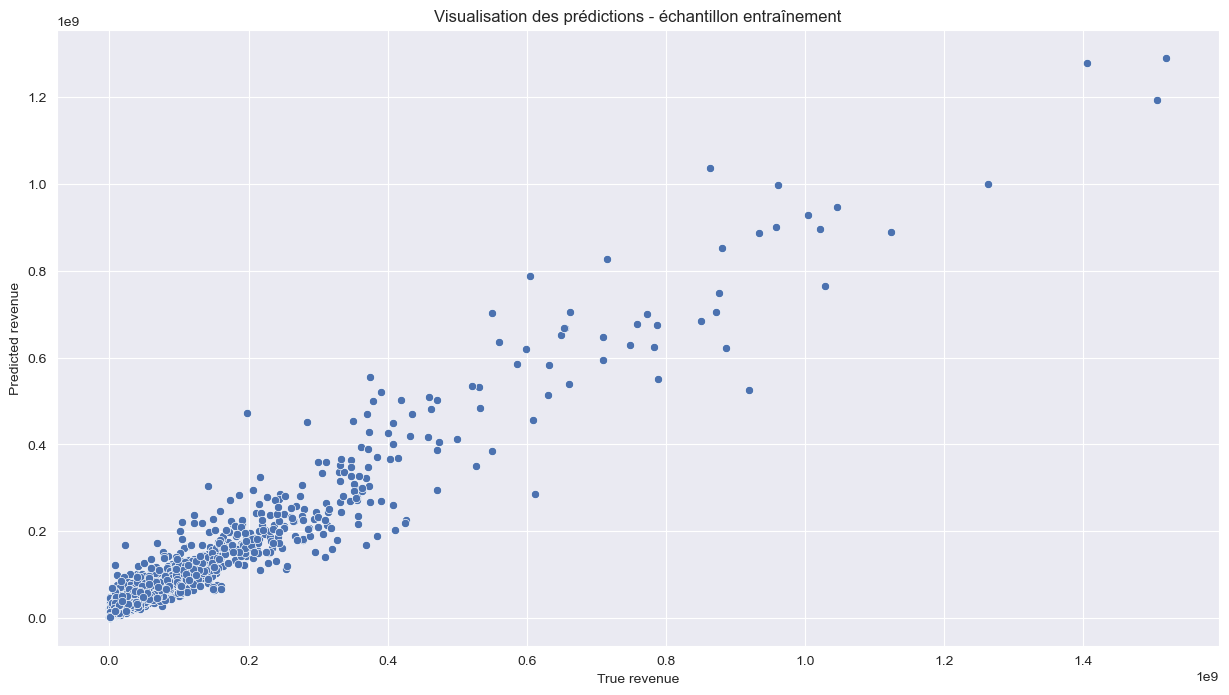

In [225]:
sns.scatterplot(x=y_train, y=y_train_pred)
plt.title("Visualisation des prédictions - échantillon entraînement")
plt.xlabel("True revenue")
plt.ylabel("Predicted revenue")
plt.show()
plt.close()

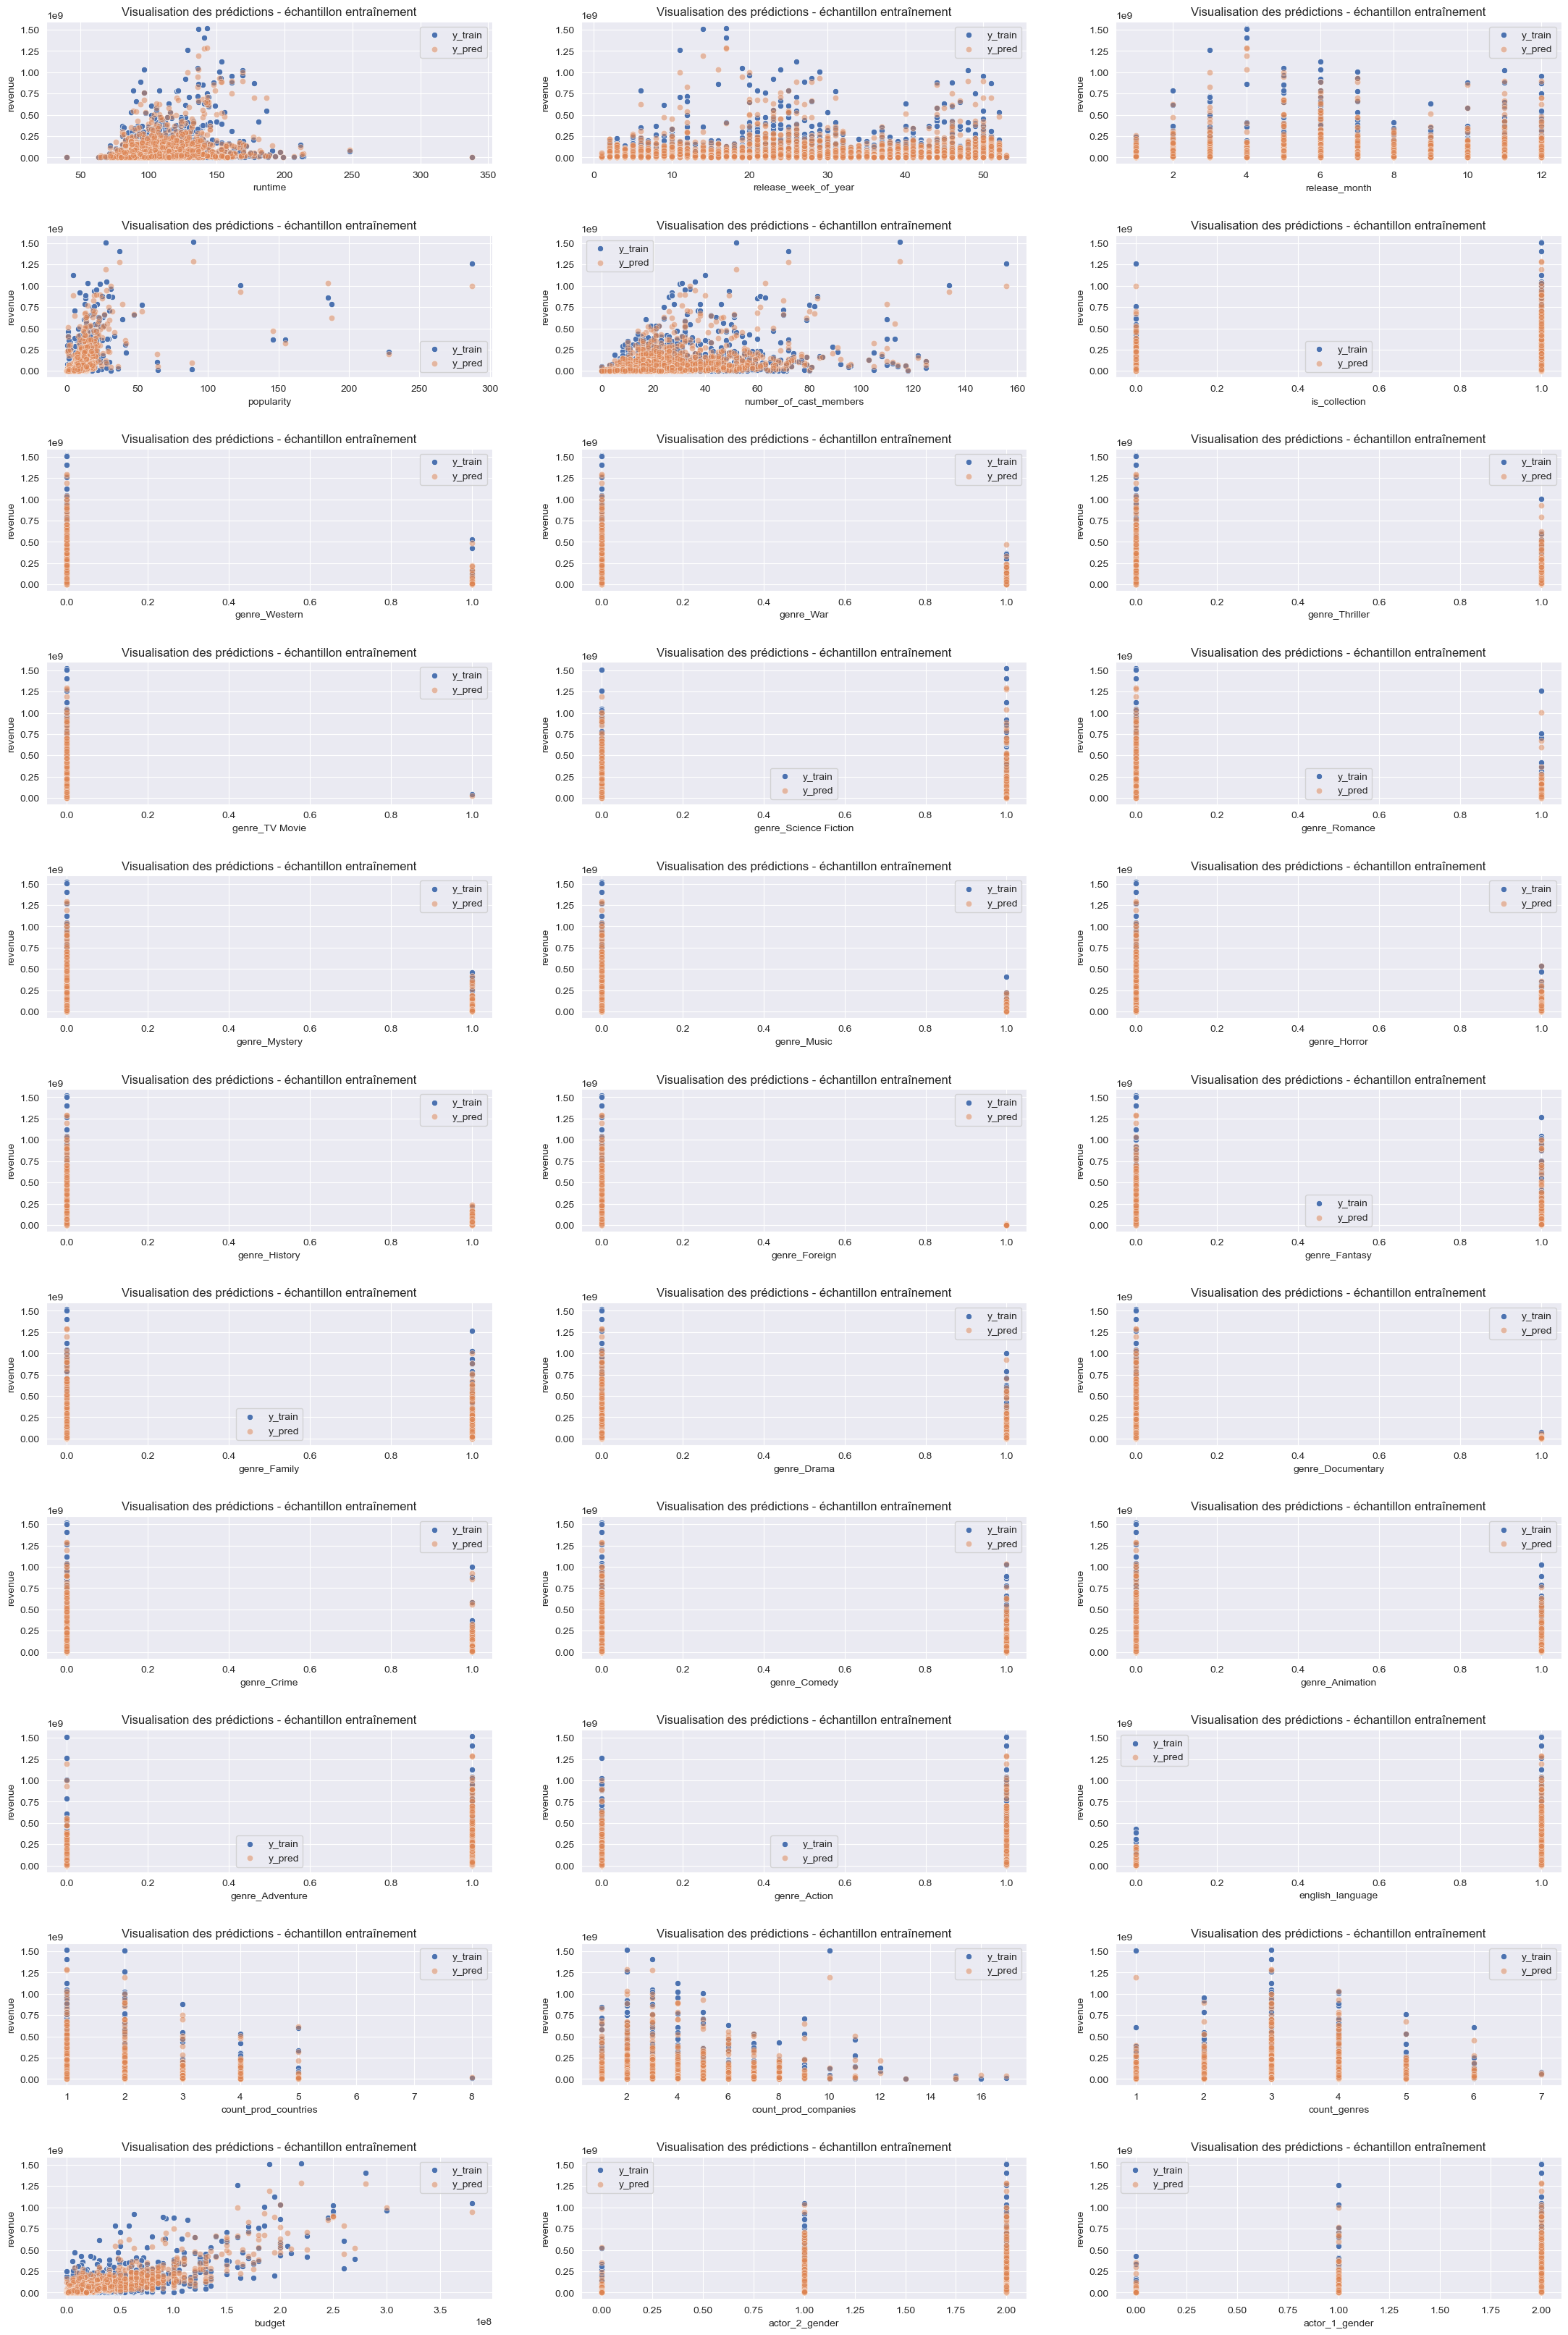

In [227]:
pred_viz(X_train, y_train, y_train_pred,["y_train","y_pred"], "revenue", "entraînement")

In [228]:
y_test_pred = model.predict(X_test)

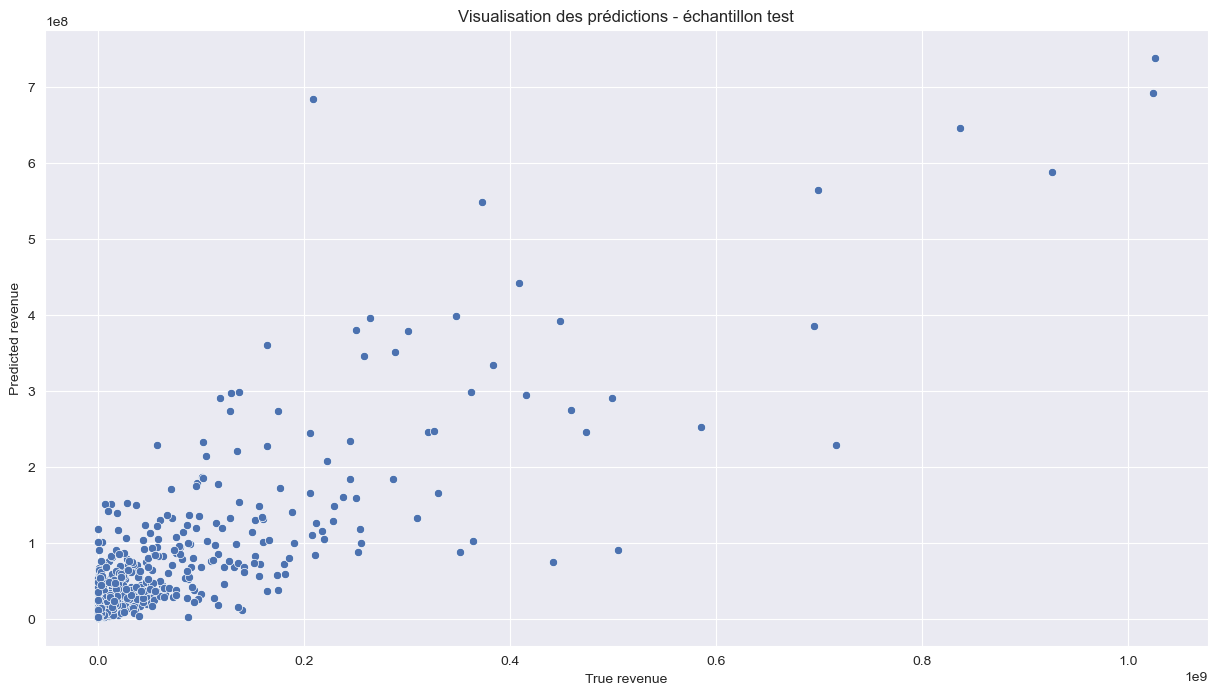

In [230]:
sns.scatterplot(x=y_test, y=y_test_pred)
plt.title("Visualisation des prédictions - échantillon test")
plt.xlabel("True revenue")
plt.ylabel("Predicted revenue")
plt.show()
plt.close()

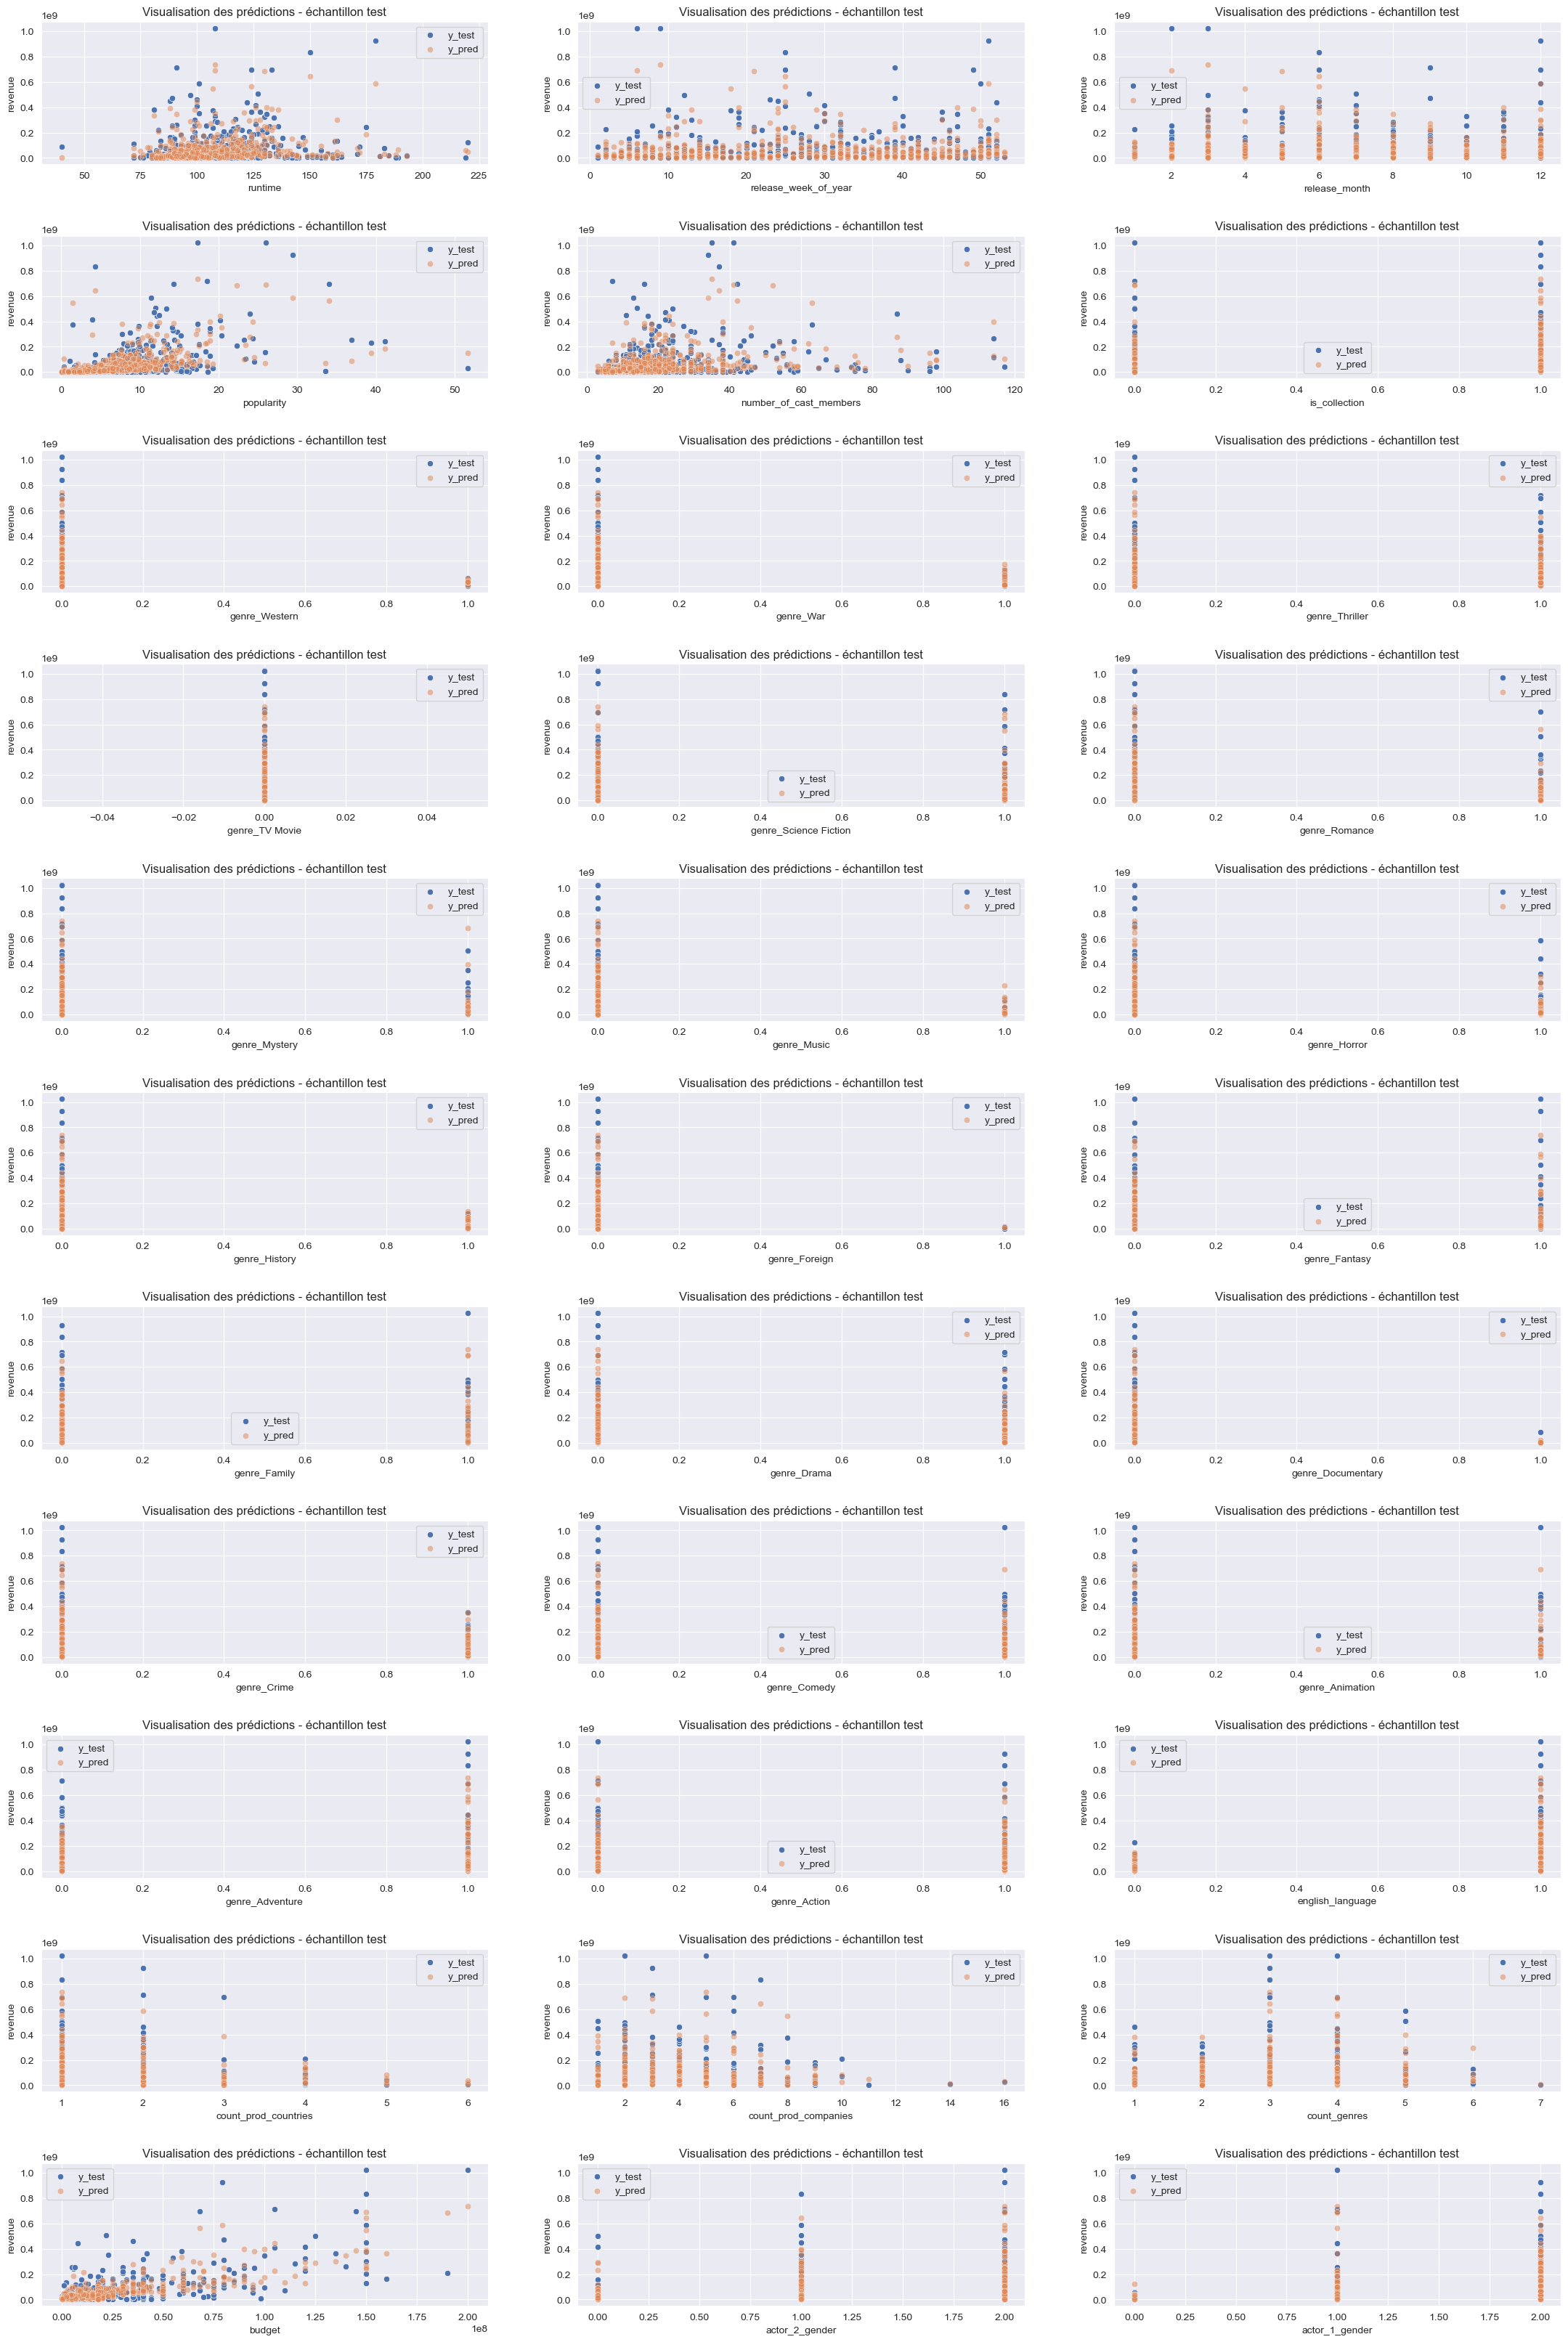

In [231]:
pred_viz(X_test, y_test,y_test_pred,["y_test","y_pred"], "revenue", "test")

## Coût
On va surtout regarder le score rmsle sur lequel se base la compétition.

In [296]:
rmse =  round(mean_squared_error(y_test, y_test_pred,squared=False),2) #on peut multiplier par 0.3 pour avoir un résultat en mètre
rmsle = (mean_squared_log_error(y_test, y_test_pred,squared=False)) # La RMSE ne se comporte pas très bien quand les étiquettes peuvent prendre des valeurs qui s'étalent sur plusieurs ordres de grandeur. On utilise alors le log.
r2 = r2_score(y_test, y_test_pred)
meanae = round(mean_absolute_error(y_test,y_test_pred),2)
medae = round(median_absolute_error(y_test,y_test_pred),2)

# Affichage des valeurs
print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
print("Racine carrée logarithmique de l'erreur quadratique moyenne (note Kaggle) : ", rmsle)
print("Moyenne absolue des erreurs :", meanae)
print("Médiane absolue des erreurs :", medae)
print(f"""Le coefficient de détermination (Score R² de précision) vaut: {r2:.2f}
=> Le modèle décrit {r2:.2%} des variations.""")

Racine carrée de l'erreur quadratique moyenne :  78740605.23
Racine carrée logarithmique de l'erreur quadratique moyenne (note Kaggle) :  2.177734572867528
Moyenne absolue des erreurs : 41104970.4
Médiane absolue des erreurs : 17553751.54
Le coefficient de détermination (Score R² de précision) vaut: 0.61
=> Le modèle décrit 61.42% des variations.


**Observation**<br>
La moitié des prédictions a une erreur supérieure à 19 millions de dollars, et la moyenne des erreurs vaut environ 40M$. Bof!<br>

# Préparation du modèle sur données de type numérique au chargement des fichiers

In [234]:
movies_train_num = movies_train[["title", "budget", "popularity", "runtime", "revenue"]]
#movies_test_num = movies_train[["id", "budget", "popularity", "runtime"]]

In [236]:
X = movies_train_num.iloc[:,1:4]
X

budget  popularity  runtime
0     14000000    6.575393       93
1     40000000    8.248895      113
2      3300000   64.299990      105
6     14000000    7.286477       92
8     18000000    6.902423      100
...        ...         ...      ...
2995  18000000    9.853270      102
2996  18000000    3.727996      102
2997  65000000   14.482345      120
2998  42000000   15.725542       90
2999  35000000   10.512109      106

[2783 rows x 3 columns]

In [237]:
y = movies_train_num.revenue
y

0        12314651
1        95149435
2        13092000
6        85446075
8        34327391
          ...    
2995      1596687
2996       180590
2997     89456761
2998    171963386
2999     82087155
Name: revenue, Length: 2783, dtype: int64

## Echantillonnage

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

## Choix de l'estimateur
On sait déjà (voir plus haut) que c'est le RandomForest sans transformeur qui a le meilleur score.

## Apprentissage

In [283]:
parameters = {
    'n_estimators': [50,200,350,500],
    'max_depth' : np.arange(start = 10, stop = 100, step = 10), 
    'min_samples_leaf' : np.arange(start = 2, stop = 6, step = 1),
    'min_samples_split' : np.arange(start = 2, stop = 6, step = 1),
    'random_state' : [42]
}

number_of_combination(parameters, number_of_split=5, longtime="y")

Il y a 576 combinaisons à tester sur 5 cross-validation, soit 2880 possibilités.
Oula! Ca risque d'être un peu long, tu peux répondre à tes mails pendant l'apprentissage ou partir manger, fin estimée le 28/10/2022 vers 19:27:20.


In [284]:
model_simple = GridSearchCV(RandomForestRegressor(), parameters, scoring = 'r2', cv=5, verbose = 1, n_jobs=-1)
model_simple.fit(X_train, y_train)
end_training = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print (f"Fin de l'apprentissage : {end_training}")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Fin de l'apprentissage : 28/10/2022 19:18:44


In [211]:
model_simple

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200,
       2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000]),
                         'max_iter': array([200, 250, 300, 350, 400, 450, 500]),
                         'random_state': [42], 'tol': array([0.2, 0.3, 0.4])},
             scoring='r2', verbose=1)

In [285]:
print(f"""Le score moyen du meilleur modèle vaut {round(model_simple.best_score_,2)}.
On obtient une performance de {model_simple.score(X_train, y_train):.2%} sur le jeu d'entraînement et {model_simple.score(X_test, y_test):.2%} sur le jeu de test
avec les paramètres optimisés {model_simple.best_params_}
""")


Le score moyen du meilleur modèle vaut 0.63.
On obtient une performance de 77.67% sur le jeu d'entraînement et 61.42% sur le jeu de test
avec les paramètres optimisés {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 350, 'random_state': 42}



## Coût
On va surtout regarder le score rmsle sur lequel se base la compétition.

In [286]:
y_test_pred = model_simple.predict(X_test)

In [287]:
rmse =  round(mean_squared_error(y_test, y_test_pred,squared=False),2) #on peut multiplier par 0.3 pour avoir un résultat en mètre
rmsle = round(mean_squared_log_error(y_test, y_test_pred,squared=False),2) # La RMSE ne se comporte pas très bien quand les étiquettes peuvent prendre des valeurs qui s'étalent sur plusieurs ordres de grandeur. On utilise alors le log.
r2 = r2_score(y_test, y_test_pred)
meanae = round(mean_absolute_error(y_test,y_test_pred),2)
medae = round(median_absolute_error(y_test,y_test_pred),2)

# Affichage des valeurs
print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
print("Racine carrée logarithmique de l'erreur quadratique moyenne (note Kaggle) : ", rmsle)
print("Moyenne absolue des erreurs :", meanae)
print("Médiane absolue des erreurs :", medae)
print(f"""Le coefficient de détermination (Score R² de précision) vaut: {r2:.2f}
=> Le modèle décrit {r2:.2%} des variations.""")

Racine carrée de l'erreur quadratique moyenne :  78740605.23
Racine carrée logarithmique de l'erreur quadratique moyenne (note Kaggle) :  2.18
Moyenne absolue des erreurs : 41104970.4
Médiane absolue des erreurs : 17553751.54
Le coefficient de détermination (Score R² de précision) vaut: 0.61
=> Le modèle décrit 61.42% des variations.


# Prédiction finale

Remarque : C'est le modèle RandomForestRegressor sur toutes les données qui donne le meilleur résultat.

In [289]:
movies_test.head()

title  runtime  release_week_of_year  release_month  \
1  Attack of the 50 Foot Woman       65                    20              5   
2             Addicted to Love      100                    21              5   
3                    Incendies      130                    35              9   
5                     SubUrbia      121                     6              2   
6                        Three      119                    51             12   

   popularity  number_of_cast_members  is_collection  genre_Western  \
1    3.559789                      10              0              0   
2    8.085194                       9              0              0   
3    8.596012                      23              0              0   
5    8.679350                       9              0              0   
6    4.898882                      25              0              0   

   genre_War  genre_Thriller  genre_TV Movie  genre_Science Fiction  \
1          0               0               0                      1   
2          0               0               0                      0   
3          1               0               0                      0   
5          0               0               0                      0   
6          0               0               0                      0   

   genre_Romance  genre_Mystery  genre_Music  genre_Horror  genre_History  \
1              0              0            0             1              0   
2              1              0            0             0              0   
3              0              1            0             0              0   
5              0              0            0             0              0   
6              1              0            0             0              0   

   genre_Foreign  genre_Fantasy  genre_Family  genre_Drama  genre_Documentary  \
1              0              0             0            0                  0   
2              0              0             0            0                  0   
3              0              0             0            1                  0   
5              0              0             0            1                  0   
6              0              0             0            1                  0   

   genre_Crime  genre_Comedy  genre_Animation  genre_Adventure  genre_Action  \
1            0             0                0                0             0   
2            0             1                0                0             0   
3            0             0                0                0             0   
5            0             1                0                0             0   
6            0             1                0                0             0   

   english_language  count_prod_countries  count_prod_companies  count_genres  \
1                 1                     1                     1             2   
2                 1                     1                     3             2   
3                 0                     2                     3             3   
5                 1                     1                     2             2   
6                 0                     1                     4             3   

     budget  actor_2_gender  actor_1_gender  
1     88000               0               1  
2  18000000               2               1  
3   6800000               1               1  
5  18000000               1               2  
6  18000000               0               1

Je me débarasse de la variable 'title'

In [290]:
test = movies_test.drop(columns=['title'])

In [291]:
y_pred = model.predict(test)
#y_pred = y_pred.astype('int')
revenue_df = pd.DataFrame(data=y_pred, columns=["revenue"])
revenue_df


revenue
0     7.411122e+06
1     1.318504e+07
2     1.733811e+07
3     2.961603e+07
4     3.215536e+07
...            ...
4110  6.601790e+07
4111  6.206348e+07
4112  5.460493e+07
4113  1.241597e+08
4114  2.517752e+07

[4115 rows x 1 columns]

In [292]:
title_df = pd.DataFrame(movies_test.iloc[:,0])
title_df

title
1     Attack of the 50 Foot Woman
2                Addicted to Love
3                       Incendies
5                        SubUrbia
6                           Three
...                           ...
4393                 Original Sin
4394             Without a Paddle
4395                  The Verdict
4396                   It Follows
4397                 Vivre Sa Vie

[4115 rows x 1 columns]

In [294]:
predict_revenue = pd.concat([title_df.reset_index(),revenue_df.reset_index()],  axis='columns')
predict_revenue.drop(columns="index", inplace=True)
predict_revenue

title       revenue
0     Attack of the 50 Foot Woman  7.411122e+06
1                Addicted to Love  1.318504e+07
2                       Incendies  1.733811e+07
3                        SubUrbia  2.961603e+07
4                           Three  3.215536e+07
...                           ...           ...
4110                 Original Sin  6.601790e+07
4111             Without a Paddle  6.206348e+07
4112                  The Verdict  5.460493e+07
4113                   It Follows  1.241597e+08
4114                 Vivre Sa Vie  2.517752e+07

[4115 rows x 2 columns]

In [295]:
predict_revenue.to_excel("predict_revenue.xlsx")

In [ ]:
'''
Graphe avec matplotlib

fig, ax = plt.subplots(figsize=(25,12))


ax.bar(release_week_df.index, release_week_df.revenue, color="b")
ax.set_ylabel('Recettes (en $)')
ax.set_xlabel('Semaine de sortie')

ax2 = ax.twinx() #pour que chaque graphe ait son échelle


ax2.set_ylabel('Nombre de films sortis')
ax2.plot(release_week_df.index, release_week_df.occurence, color = "r", marker='o')
#ax2.tick_params(axis ='y')


plt.title('Répartition des recettes par semaine de sortie', pad=20, size=20)

ax2.legend(['Nombre de films sortis'], facecolor='w')

# Pour aligner les 0 de l'axe y, je définis les limites
ax.set_ylim(0,math.ceil(max(release_week_df.revenue)*1.1))
ax2.set_ylim(0,math.ceil(max(release_week_df.occurence)*1.1))


plt.show()
plt.close()
'''

In [ ]:
'''Méthode pour avoir x colonnes genres avec le nom du genre dans chaque ligne)
movies_train['count_genres']=''
for index, genres in movies_train.genres.items():
    movies_train.loc[movies_train.index==index, "count_genres"]=retrieve_info_from_json(genres,movies_train)[0]
    print(retrieve_info_from_json(genres,movies_train)[1])

max_occurences_genres = max(movies_train.count_genres)
print (f"Les films ayant le plus de genres en contiennent {max_occurences_genres}.")

for i in range (1,max_occurences_genres+1):
    movies_train["genre"+str(i)]=""
    
for index, genres in movies_train.genres.items():
    tab_genre=retrieve_info_from_json(genres)[1]
    for i in range(len(tab_genre)):
        movies_train.loc[movies_train.index==index, "genre"+str(i+1)]=tab_genre[i]
    #print(retrieve_info_from_json(genres)[1])
'''